 Determine the average signal yield and the error on its measure

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [1]:
import pandas
import uproot
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interpolate
import pickle
import zfit
import mplhep
from numpy import random 

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})

/Users/mariehartmann/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/zfit/__init__.py:48: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."
/Users/mariehartmann/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/zfit/util/execution.py:73: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


# Initialization of the data parameters

In [2]:
#Dowloading the data
bc_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU.root')['events']
bu_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bu2TauNuTAUHADNU.root')['events']
bb_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen.root')['events']
cc_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zcc_ecm91.root')['events']
qq_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zuds_ecm91.root')['events']
tree_gen = uproot.open("root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU.root")["metadata"]

In [ ]:
#Transforming the data into a dataframe
bc_df = bc_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
bu_df = bu_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
bb_df = bb_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
cc_df = cc_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
qq_df = qq_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])

#Getting general information on the data
df_gen = tree_gen.arrays(library="pd", how="zip")

In [ ]:
#We consider as initial data the data whose MVAs are between 0.95 and 1

bc_sig = bc_df[bc_df['EVT_MVA2']> 0.95]
bc_sig = bc_sig[bc_sig['EVT_MVA1']> 0.95]

bu_bkg = bu_df[bu_df['EVT_MVA2']> 0.95]
bu_bkg = bu_bkg[bu_bkg['EVT_MVA1']> 0.95] 

bb_bkg = bb_df[bb_df['EVT_MVA2']> 0.95]
bb_bkg = bb_bkg[bb_bkg['EVT_MVA1']> 0.95] 

cc_bkg = cc_df[cc_df['EVT_MVA2']> 0.95]
cc_bkg = cc_bkg[cc_bkg['EVT_MVA1']> 0.95] 

qq_bkg = qq_df[qq_df['EVT_MVA2']> 0.95]
qq_bkg = qq_bkg[qq_bkg['EVT_MVA1']> 0.95]

In [1]:
#Number of Z0 produced
N_Z0_init = 5*10**(12)
N_Z0 = 5*10**(11)

#Branching fraction Z->quark-pair
BF_Zbb = 0.1512
BF_Zcc = 0.1203
BF_Zqq = 0.4276

#Production ratio of Bc+ and B+
f_Bc = 0.0004
f_Bu = 0.43

#Branching fraction Bc+->tau nu B+->tau nu and tau->3pions
BF_Bctaunu = 0.0194
BF_Butaunu = 1.09*10**(-4)
BF_tau3pion = 0.0931

In [2]:
#Definition of the functions computing the different yields
def S_bc_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zbb*2*f_Bc*BF_Bctaunu*BF_tau3pion)*initial_eff*cut_eff

def B_bu_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zbb*2*f_Bu*BF_Butaunu*BF_tau3pion)*initial_eff*cut_eff

def B_bb_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zbb*2)*initial_eff*cut_eff

def B_cc_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zcc*2)*initial_eff*cut_eff

def B_qq_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zqq*2)*initial_eff*cut_eff

#Dowloading the splines to compute the number of inclusive background events

bb_spline_MVA1_log = pickle.load(open(r'../Finding_the_best_MVA_cut/2D_plot/Spline_functions/MVA1_spline_log.pkl','rb'))
bb_spline_MVA2_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/MVA2_spline_log.pkl','rb'))

cc_spline_MVA1_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/cc_MVA1_spline_log.pkl','rb'))
cc_spline_MVA2_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/cc_MVA2_spline_log.pkl','rb'))

#qq_spline_MVA1_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/uds_MVA1_spline_log.pkl','rb'))
#qq_spline_MVA2_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/uds_MVA2_spline_log.pkl','rb'))

#http://localhost:8912/tree/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions

NameError: name 'pickle' is not defined

In [100]:
#Initialization of the number of events in the MVAs for all contributions
nb_total_events = df_gen.iloc[0]["eventsProcessed"]
nb_bc_events = len(bc_sig)
nb_bu_events = len(bu_bkg)
nb_bb_events = len(bb_bkg)
nb_cc_events = len(cc_bkg)
#nb_qq_events = len(qq_bkg)

#Initialization of the number of events for both MVAs for inclusive backgrounds
nb_bb_events_1 = interpolate.splint(-np.log(1-0.95), 9, bb_spline_MVA1_log)
nb_cc_events_1 = interpolate.splint(-np.log(1-0.95), 9, cc_spline_MVA1_log)
#nb_qq_events_1 = interpolate.splint(-np.log(1-0.95), 8, qq_spline_MVA1_log)

nb_bb_events_2 = interpolate.splint(-np.log(1-0.95), 8, bb_spline_MVA2_log)
nb_cc_events_2 = interpolate.splint(-np.log(1-0.95), 7, cc_spline_MVA2_log)
#nb_qq_events_2 = interpolate.splint(-np.log(1-0.95), 5.8, qq_spline_MVA2_log)

#Computing of the initial efficiencies for all backgrounds
initial_eff_bc_sig = nb_bc_events / nb_total_events
initial_eff_bu_bkg = nb_bu_events / nb_total_events
initial_eff_bb_bkg = nb_bb_events / nb_total_events
initial_eff_cc_bkg = nb_cc_events / nb_total_events
#initial_eff_qq_bkg = nb_qq_events / nb_total_events

print('eff sig {}'.format(initial_eff_bc_sig))
#print('eff bkg {}'.format(initial_eff_qq_bkg))

eff sig 0.2320645


In [101]:
#Optimized MVAs
Optimized_MVA1 = 0.9998599999999961  #+-0.00001
Optimized_MVA2 = 0.9963399999999984 #+-0.00001

Optimized_MVA1_log = -np.log(1-Optimized_MVA1)
Optimized_MVA2_log = -np.log(1-Optimized_MVA2)

#Applying the MVA2 cut on the dataframe
df_bc_sig = bc_sig[bc_sig['EVT_MVA1']>Optimized_MVA1]
df_bc_sig = df_bc_sig[df_bc_sig['EVT_MVA2']>Optimized_MVA2]

df_bu_bkg = bu_bkg[bu_bkg['EVT_MVA1']>Optimized_MVA1]
df_bu_bkg = df_bu_bkg[df_bu_bkg['EVT_MVA2']>Optimized_MVA2]
          
#Counting the number of events in the Bc+ and B+ dataframes after the cut
nb_bc_after_cut = len(df_bc_sig)
nb_bu_after_cut = len(df_bu_bkg)
          
#Counting the number of events left for each MVAs for inclusive backgrounds
nb_bb_after_cut_1 = interpolate.splint(Optimized_MVA1_log, 9, bb_spline_MVA1_log)
nb_bb_after_cut_2 = interpolate.splint(Optimized_MVA2_log, 8, bb_spline_MVA2_log)
        
nb_cc_after_cut_1 = interpolate.splint(Optimized_MVA1_log, 9, cc_spline_MVA1_log)
nb_cc_after_cut_2 = interpolate.splint(Optimized_MVA2_log, 7, cc_spline_MVA2_log)
        
#nb_qq_after_cut_1 = interpolate.splint(Optimized_MVA1_log, 8, qq_spline_MVA1_log)
#nb_qq_after_cut_2 = interpolate.splint(Optimized_MVA2_log, 5.8, qq_spline_MVA2_log)

        
#Computing the efficiencies
cut_eff_bc_sig = nb_bc_after_cut / nb_bc_events
        
cut_eff_bu_bkg = nb_bu_after_cut / nb_bu_events
cut_eff_bb_bkg = (nb_bb_after_cut_1 / nb_bb_events_1) * (nb_bb_after_cut_2 / nb_bb_events_2)
cut_eff_cc_bkg = (nb_cc_after_cut_1 / nb_cc_events_1) * (nb_cc_after_cut_2 / nb_cc_events_2)
#cut_eff_qq_bkg = (nb_qq_after_cut_1 / nb_qq_events_1) * (nb_qq_after_cut_2 / nb_qq_events_2)
print(cut_eff_bu_bkg)
print(cut_eff_bb_bkg)
print(cut_eff_cc_bkg)
#print(cut_eff_qq_bkg)
        
    
#Signal, Background and Purity
S = S_bc_cut(initial_eff_bc_sig, cut_eff_bc_sig)
B = B_bb_cut(initial_eff_bb_bkg, cut_eff_bb_bkg) + B_cc_cut(initial_eff_cc_bkg, cut_eff_cc_bkg) + B_bu_cut(initial_eff_bu_bkg, cut_eff_bu_bkg) #+ B_qq_cut(initial_eff_qq_bkg, cut_eff_qq_bkg)
P = S/(S+B)

print('Number of signal events = {}'.format(S))
print('Number of bkg events = {}'.format(B))
print('Purity = {}'.format(P))

N_BC = S_bc_cut(initial_eff_bc_sig, cut_eff_bc_sig)

N_BU = B_bu_cut(initial_eff_bu_bkg, cut_eff_bu_bkg)
N_BB = B_bb_cut(initial_eff_bb_bkg, cut_eff_bb_bkg)
N_CC = B_cc_cut(initial_eff_cc_bkg, cut_eff_cc_bkg)
#N_QQ = B_qq_cut(initial_eff_qq_bkg, cut_eff_qq_bkg)

N_BB_CC = N_BB + N_CC

print('N_BC = {}'.format(N_BC))
print('N_BU = {}'.format(N_BU))
print('N_BB = {}'.format(N_BB))
print('N_CC = {}'.format(N_CC))
#print('N_QQ = {}'.format(N_QQ))

0.0007226931575174898
3.137790945458242e-06
1.797967906975173e-06
Number of signal events = 400.92649482816006
Number of bkg events = 447.2890969373205
Purity = 0.4726705082061383
N_BC = 400.92649482816006
N_BU = 24.147796710239998
N_BB = 361.5187011064041
N_CC = 61.622599120676384


# Initialization of the fits parameters

### Initialization of the data of reference

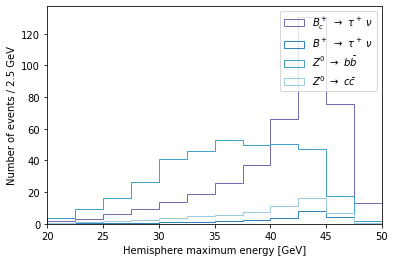

[]

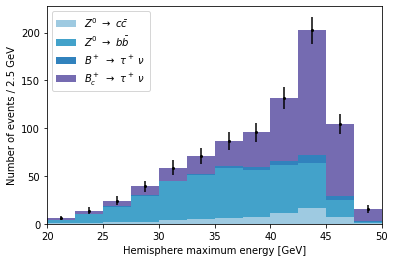

In [102]:
variable = 'EVT_ThrustEmax_E'

nb_bins = int(40/np.sqrt(N_Z0_init/N_Z0))
min_bin = 20
max_bin = 50

name_bc = r"$B_c^+$ $\rightarrow$ $\tau^+$ $\nu$ "
name_bu = r"$B^+$ $\rightarrow$ $\tau^+$ $\nu$ "
name_bb = r"$Z^0$ $\rightarrow$ $b\bar{b}$ "
name_cc = r"$Z^0$ $\rightarrow$ $c\bar{c}$ "

colour_bc = "#756bb1"
colour_bu = "#3182bd" #"#2c7fb8" #
colour_bb = "#43a2ca" #"#edf8b1" #"#a6bddb"
colour_cc = "#9ecae1" #"#7fcdbb" #

#On utilise uniquement les data avec le cut a 0.95 car les df avec le optimised cut sont quasiement vides.
#Ces df quasiement vides n'ont pas de sens physique, ils sont juste une conséquence du nb limité de MC.
counts_bc, bins_bc = np.histogram(bc_sig[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_bu, bins_bu = np.histogram(bu_bkg[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_bb, bins_bb = np.histogram(bb_bkg[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_cc, bins_cc = np.histogram(cc_bkg[variable], bins = nb_bins, range = (min_bin, max_bin))

#Cependant on les normalise par le nombre d'évènements qu'on est sensés avoir avec les données expérimentales
#Juste après l'optimised cut.
counts_bc = (counts_bc/np.sum(counts_bc)) * N_BC
counts_bu = (counts_bu/np.sum(counts_bu)) * N_BU
counts_bb = (counts_bb/np.sum(counts_bb)) * N_BB
counts_cc = (counts_cc/np.sum(counts_cc)) * N_CC

plt.figure()
plt.hist(bins_bc[:-1], bins_bc, weights=counts_bc, histtype='step', color= colour_bc, label=name_bc)
plt.hist(bins_bu[:-1], bins_bu, weights=counts_bu, histtype='step', color= colour_bu, label=name_bu)
plt.hist(bins_bb[:-1], bins_bb, weights=counts_bb, histtype='step', color= colour_bb, label=name_bb)
plt.hist(bins_cc[:-1], bins_bb, weights=counts_cc, histtype='step', color= colour_cc, label=name_cc)
plt.legend()
plt.xlim(min_bin,max_bin)
plt.xlabel("Hemisphere maximum energy [GeV]")
plt.ylabel("Number of events / {} GeV".format(round((max_bin-min_bin)/nb_bins,3)))
plt.show()

x = [bins_bb[:-1], bins_cc[:-1], bins_bu[:-1], bins_bc[:-1]]
bins = bins_bc
weights = [counts_bb, counts_cc, counts_bu, counts_bc ]
colour = [colour_bb, colour_cc, colour_bu, colour_bc]
name = [name_bb, name_cc, name_bu, name_bc]

plt.figure(16,3)
counts, bin_edges, _ = plt.hist(x, bins, weights=weights, color=colour, label=name, stacked=True)
bin_centres = (bin_edges[:-1]+ bin_edges[1:])/2
err = np.sqrt(counts[3])
plt.errorbar(bin_centres, counts[3], yerr=err, fmt='o', color='k', markersize=2)

plt.xlim(min_bin,max_bin)
plt.xlabel("Hemisphere maximum energy [GeV]")
plt.ylabel("Number of events / {} GeV".format(round((max_bin-min_bin)/nb_bins,3)))
plt.legend()
plt.plot()

In [ ]:
x = [bins_bb[:-1], bins_cc[:-1], bins_bu[:-1], bins_bc[:-1]]
bins = bins_bc
weights = [counts_bb, counts_cc, counts_bu, counts_bc ]
colour = [colour_bb, colour_cc, colour_bu, colour_bc]
name = [name_bb, name_cc, name_bu, name_bc]

plt.figure(figsize=(10,6))

#Stacked Histogram
counts, bin_edges, _ = plt.hist(x, bins, weights=weights, color=colour, label=name, stacked=True)

#Toy Data errorbar
bin_centres = (bin_edges[:-1]+ bin_edges[1:])/2
err = np.sqrt(counts[3])
plt.errorbar(bin_centres, np.random.poisson(counts[3]), yerr=err, fmt='o', color='k', markersize=2)

#Plot parameters
plt.xlim(min_bin,max_bin)
plt.xlabel("Hemisphere maximum energy [GeV]", fontsize=18, labelpad=10)
plt.ylabel("Number of events / {} GeV".format(round((max_bin-min_bin)/nb_bins,3)), fontsize=18, labelpad=10)

plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()

plt.plot()

### Creating the templates

In [103]:
#Getting the right bins_edges size
_ , bins_edges = np.histogram(a=bin_edges[:-1], bins=bin_edges, weights=counts[3])

#Templates and templates normalisation
template_yield_bc, _ = np.histogram(a=bins_bc[:-1], bins=bins_edges, weights=counts_bc)
template_yield_bu, _ = np.histogram(a=bins_bu[:-1], bins=bins_edges, weights=counts_bu)
template_yield_bb, _ = np.histogram(a=bins_bb[:-1], bins=bins_edges, weights=counts_bb)
template_yield_cc, _ = np.histogram(a=bins_cc[:-1], bins=bins_edges, weights=counts_cc)
    
template_yield_bc = template_yield_bc/np.sum(template_yield_bc)
template_yield_bu = template_yield_bu/np.sum(template_yield_bu)
template_yield_bb = template_yield_bb/np.sum(template_yield_bb)
template_yield_cc = template_yield_cc/np.sum(template_yield_cc)
 
#Checking if there are zero bins    
print(template_yield_bc)
print(template_yield_bu)
print(template_yield_bb)
print(template_yield_cc)

[0.0041015  0.00831142 0.01479065 0.02335879 0.0336377  0.04693788
 0.06484477 0.09188399 0.16491225 0.32601831 0.18861146 0.03259129]
[0.00591701 0.01243702 0.02042091 0.02964256 0.03944341 0.05117229
 0.06935375 0.09530091 0.15989209 0.32283493 0.17491371 0.0186714 ]
[0.01003963 0.02496697 0.04504624 0.07357992 0.11241744 0.12668428
 0.14663144 0.13698811 0.13883752 0.13130779 0.04900925 0.00449141]
[0.00822604 0.01680973 0.02610873 0.03826896 0.05937053 0.07725322
 0.09334764 0.11623748 0.18061516 0.26716738 0.10908441 0.00751073]


### Creating the function that we will use for the fit

In [104]:
#When considering only Z->bb and Bu for background
#def get_template(yield_sig, yield_bkg):
# return yield_sig*template_process1 + N_BU*template_process2 + yield_bkg*template_process3

#When considering Z->bb, Z->cc and Bu for background
def get_template(yield_bc, yield_bu, yield_bb_cc): 
    return yield_bc*template_yield_bc + yield_bu*template_yield_bu + yield_bb_cc*((N_BB/N_BB_CC)*template_yield_bb + (N_CC/N_BB_CC)*template_yield_cc)
    
def binned_nll(template, sample_hist):
    return np.sum(template - sample_hist + sample_hist * np.log((sample_hist + 1*10**(-14)) / (template + 1*10**(-14))))
  # 1e-14 added in case there are empty bins

def loss(x):
    # by default, `x` is an `OrderedSet` of zfit parameters.
    x = np.array(x)

    print("Value of the parameters", x)
  
    # The first parameter is the Bc yield 
    yield_bc = x[0]
    # The second parameter is the Bu yield 
    yield_bu = x[1]
    # The second parameter is the Z->bb and Z->cc combined yield 
    yield_bb_cc = x[2]

    template = get_template(yield_bc, yield_bu, yield_bb_cc)

    nll = binned_nll(template, sample_hist)
    
    #Gaussian constraint on B+ -> tau nu yield
    nll += (yield_bu - N_BU)**2/2./N_BU*0.05

    return nll

loss.errordef = 0.5 # 0.5 for a log-likelihood
# We would set this parameter at 1 for a chi2 loss function.

# Toy samples

In [105]:
#Theoretical value of the yields parameters to give initial value to the fit parameters
print('N_BC = {}'.format(N_BC))
print('N_BU = {}'.format(N_BU))
print('N_BB_CC = {}'.format(N_BB_CC))

N_BC = 400.92649482816006
N_BU = 24.147796710239998
N_BB_CC = 423.1413002270805


### Creating and Fitting multiple toy samples

In [ ]:
n_loop = 2000
bc_yield = np.zeros(n_loop)
bu_yield = np.zeros(n_loop)
bb_cc_yield = np.zeros(n_loop)

for i in range (n_loop) :
    
    #Toy sample
    data = np.random.poisson(counts[3])
    sample_hist, bins_edges = np.histogram(a=bin_edges[:-1], bins=bin_edges, weights=data)
    print(sample_hist)

    
    #Initialisation of the parameters
    i_rand = random.randint(0,1000000000000,size=1)
    
    initial_params = {
            'value': [400, 20, 400],
            'lower' : [-1000., -1000., -1000.], # optional
            'upper': [10000., 10000., 10000.], # optional
            'name': [f"bc_yield_{i_rand}", f"bu_yield_{i_rand}", f"bb_cc_yield_{i_rand}"] # optional
        }

    
    #Fit
    minimiser = zfit.minimize.Minuit(verbosity=5)
    zfit.run.set_autograd_mode(False)
    zfit.run.set_graph_mode(False)
    
    #Extracting the informations
    result = minimiser.minimize(loss, initial_params)
    params = result.params
    params_hesse = result.hesse() #Computation of the errors
    corr = result.correlation(method="minuit_hesse")
    
    print(result.info['original'])
    print(params)
    print('correction {}'.format(corr))

    #Extracting the yield results
    bc_yield[i] = params[f"bc_yield_{i_rand}"]['value']
    bu_yield[i] = params[f"bu_yield_{i_rand}"]['value']
    bb_cc_yield[i] = params[f"bb_cc_yield_{i_rand}"]['value']
    
    

[  9  12  24  33  74  88  85 103 117 181  97  23]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.06040692  20.         400.        ]
Value of the parameters [399.93959419  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [400.          20.         400.05759385]
Value of the parameters [400.          20.         399.94240716]
Value of the parameters [402.53926299  23.07626975 440.69700078]
Value of the parameters [402.1788027   22.63947062 434.89158678]
Value of the parameters [402.

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[508737380129]       398.3     +/-      44       False
bu_yield_[508737380129]        23.3     +/-      22       False
bb_cc_yield_[508737380129]    392.3     +/-      39       False
correction [[ 1.         -0.43901937 -0.63555433]
 [-0.43901937  1.         -0.06281137]
 [-0.63555433 -0.06281137  1.        ]]
[  5  12  21  35  57  76  80  94 138 206  85   9]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[266467178034]       326.2     +/-      43       False
bu_yield_[266467178034]       27.56     +/-      22       False
bb_cc_yield_[266467178034]    464.2     +/-      40       False
correction [[ 1.         -0.45490923 -0.62901085]
 [-0.45490923  1.         -0.05793046]
 [-0.62901085 -0.05793046  1.        ]]
[  8  21  32  39  50  61  91  95 144 193 100  12]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[617182111036]       417.1     +/-      45       False
bu_yield_[617182111036]       25.01     +/-      22       False
bb_cc_yield_[617182111036]    404.9     +/-      40       False
correction [[ 1.         -0.43534309 -0.63579943]
 [-0.43534309  1.         -0.06130143]
 [-0.63579943 -0.06130143  1.        ]]
[  7  15  27  40  68  79  75  95 142 179 124  16]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [430.61425082  23.88964039 361.9946259 ]
Value of the parameters [430.61425082  23.89034979 361.99571641]
Value of the parameters [430.61425082  23.89034979 361.99353539]
Value of the parameters [430.61984962  23.89389684 361.9946259 ]
Value of the parameters [430.61984962  23.89034979 362.00007844]
Value of the parameters [430.61425082  23.89389684 362.00007844]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.749                      │              Nfcn = 50               │
│ EDM = 0.000151 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│ 

Value of the parameters [432.14859213  21.21218606 368.83188018]
Value of the parameters [432.14859213  21.21218606 368.80548762]
Value of the parameters [432.21624663  21.25525673 368.81868387]
Value of the parameters [432.21624663  21.21218606 368.88466596]
Value of the parameters [432.14859213  21.25525673 368.88466596]
Value of the parameters [432.14859213  21.21218606 368.81868387]
Value of the parameters [432.16212292  21.21218606 368.81868387]
Value of the parameters [432.13506139  21.21218606 368.81868387]
Value of the parameters [432.14859213  21.22080013 368.81868387]
Value of the parameters [432.14859213  21.20357203 368.81868387]
Value of the parameters [432.14859213  21.21218606 368.83188018]
Value of the parameters [432.14859213  21.21218606 368.80548762]
Value of the parameters [432.15129828  21.21218606 368.81868387]
Value of the parameters [432.14588598  21.21218606 368.81868387]
Value of the parameters [432.14859213  21.21390887 368.81868387]
Value of the parameters [

Value of the parameters [437.05976855  22.56538487 397.87608767]
Value of the parameters [437.04314093  22.56538487 397.87608767]
Value of the parameters [437.05145473  22.57062563 397.87608767]
Value of the parameters [437.05145473  22.56014412 397.87608767]
Value of the parameters [437.05145473  22.56538487 397.88427064]
Value of the parameters [437.05145473  22.56538487 397.86790471]
Value of the parameters [437.09302402  22.5915888  397.87608767]
Value of the parameters [437.09302402  22.56538487 397.91700275]
Value of the parameters [437.05145473  22.5915888  397.91700275]
Value of the parameters [437.05145473  22.56538487 397.87608767]
Value of the parameters [437.05976855  22.56538487 397.87608767]
Value of the parameters [437.04314093  22.56538487 397.87608767]
Value of the parameters [437.05145473  22.57062563 397.87608767]
Value of the parameters [437.05145473  22.56014412 397.87608767]
Value of the parameters [437.05145473  22.56538487 397.88427064]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[825311750540]       355.6     +/-      44       False
bu_yield_[825311750540]       23.35     +/-      22       False
bb_cc_yield_[825311750540]    489.1     +/-      41       False
correction [[ 1.         -0.43732681 -0.6328602 ]
 [-0.43732681  1.         -0.06196587]
 [-0.6328602  -0.06196587  1.        ]]
[  5  19  24  39  59  68  78  94 125 227  97  19]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[663423553543]       421.6     +/-      44       False
bu_yield_[663423553543]       24.73     +/-      22       False
bb_cc_yield_[663423553543]    344.6     +/-      38       False
correction [[ 1.         -0.44209023 -0.62939664]
 [-0.44209023  1.         -0.06707357]
 [-0.62939664 -0.06707357  1.        ]]
[  2  17  31  37  55  74  88  95 137 187 103  15]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[541379775396]       386.9     +/-      44       False
bu_yield_[541379775396]       21.63     +/-      22       False
bb_cc_yield_[541379775396]    480.6     +/-      41       False
correction [[ 1.         -0.4288452  -0.629408  ]
 [-0.4288452   1.         -0.06698969]
 [-0.629408   -0.06698969  1.        ]]
[  3   8  30  37  46  64  93  90 136 196 106  15]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[751742630291]       503.8     +/-      46       False
bu_yield_[751742630291]       22.09     +/-      22       False
bb_cc_yield_[751742630291]    349.2     +/-      40       False
correction [[ 1.         -0.41689167 -0.64408848]
 [-0.41689167  1.         -0.06449954]
 [-0.64408848 -0.06449954  1.        ]]
[  7  13  24  49  73  67  69 112 125 212 119  20]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.05732605  20.         400.        ]
Value of the parameters [399.94267496  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters 

Value of the parameters [378.43346172  21.63408049 446.08205126]
Value of the parameters [378.44010045  21.63408049 446.08205126]
Value of the parameters [378.426823    21.63408049 446.08205126]
Value of the parameters [378.43346172  21.63833775 446.08205126]
Value of the parameters [378.43346172  21.62982324 446.08205126]
Value of the parameters [378.43346172  21.63408049 446.08879909]
Value of the parameters [378.43346172  21.63408049 446.07530344]
Value of the parameters [378.43478946  21.63408049 446.08205126]
Value of the parameters [378.43213397  21.63408049 446.08205126]
Value of the parameters [378.43346172  21.63493194 446.08205126]
Value of the parameters [378.43346172  21.63322904 446.08205126]
Value of the parameters [378.43346172  21.63408049 446.08340083]
Value of the parameters [378.43346172  21.63408049 446.08070169]
Value of the parameters [378.44010045  21.63833775 446.08205126]
Value of the parameters [378.44010045  21.63408049 446.08879909]
Value of the parameters [

Value of the parameters [331.47581422  23.55789639 451.66087955]
Value of the parameters [331.48269034  23.5624042  451.66087955]
Value of the parameters [331.48269034  23.55338859 451.66087955]
Value of the parameters [331.48269034  23.55789639 451.6679958 ]
Value of the parameters [331.48269034  23.55789639 451.65376332]
Value of the parameters [331.51707117  23.58043552 451.66087955]
Value of the parameters [331.51707117  23.55789639 451.69646094]
Value of the parameters [331.48269034  23.58043552 451.69646094]
Value of the parameters [331.48269034  23.55789639 451.66087955]
Value of the parameters [331.48956648  23.55789639 451.66087955]
Value of the parameters [331.47581422  23.55789639 451.66087955]
Value of the parameters [331.48269034  23.5624042  451.66087955]
Value of the parameters [331.48269034  23.55338859 451.66087955]
Value of the parameters [331.48269034  23.55789639 451.6679958 ]
Value of the parameters [331.48269034  23.55789639 451.65376332]
Value of the parameters [

Value of the parameters [425.68434945  22.60522843 407.77385225]
Value of the parameters [425.69425888  22.61148764 407.77385225]
Value of the parameters [425.69425888  22.59896925 407.77385225]
Value of the parameters [425.69425888  22.60522843 407.78366072]
Value of the parameters [425.69425888  22.60522843 407.76404381]
Value of the parameters [425.74380649  22.63652462 407.77385225]
Value of the parameters [425.74380649  22.60522843 407.82289488]
Value of the parameters [425.69425888  22.63652462 407.82289488]
Value of the parameters [425.69425888  22.60522843 407.77385225]
Value of the parameters [425.70416834  22.60522843 407.77385225]
Value of the parameters [425.68434945  22.60522843 407.77385225]
Value of the parameters [425.69425888  22.61148764 407.77385225]
Value of the parameters [425.69425888  22.59896925 407.77385225]
Value of the parameters [425.69425888  22.60522843 407.78366072]
Value of the parameters [425.69425888  22.60522843 407.76404381]
Value of the parameters [

Value of the parameters [404.97037863  24.43088326 460.14332197]
Value of the parameters [404.97037863  24.43088326 460.02086796]
Value of the parameters [401.87506385  25.11370055 460.0207018 ]
Value of the parameters [400.52681041  25.41138636 459.99394273]
Value of the parameters [400.58768456  25.41138636 459.99394273]
Value of the parameters [400.46593739  25.41138636 459.99394273]
Value of the parameters [400.52681041  25.44950673 459.99394273]
Value of the parameters [400.52681041  25.37326662 459.99394273]
Value of the parameters [400.52681041  25.41138636 460.05546818]
Value of the parameters [400.52681041  25.41138636 459.93241837]
Value of the parameters [400.52681041  25.41138636 459.99394273]
Value of the parameters [400.58768456  25.41138636 459.99394273]
Value of the parameters [400.46593739  25.41138636 459.99394273]
Value of the parameters [400.52681041  25.44950673 459.99394273]
Value of the parameters [400.52681041  25.37326662 459.99394273]
Value of the parameters [

Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [449.6870663   42.61910452 446.18113582]
Value of the parameters [423.71840529  30.81150413 422.05074892]
Value of the parameters [423.74879028  30.81150413 422.05074892]
Value of the parameters [423.68802057  30.81150413 422.05074892]
Value of the parameters [423.71840529  30.83135167 422.05074892]
Value of the parameters [423.71840529  30.79165677 422.05074892]
Value of the parameters [423.71840529  30.81150413 422.08107203]
Value of the parameters [423.71840529  30.81150413 422.02042608]
Value of the parameters [426.19220783  27.02635544 423.48976384]
Value of the parameters [428.83617054  22.99083103 425.02727159]
Value of the parameters [428.86794961  22.99083103 425.02727159]
Value of the parameters [428.80439178  22.99083103 425.02727159]
Value of the parameters [428.83617054  23.01070452 425.02727159]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[127717189652]         346     +/-      43       False
bu_yield_[127717189652]       23.27     +/-      22       False
bb_cc_yield_[127717189652]    481.8     +/-      41       False
correction [[ 1.         -0.44364225 -0.62478017]
 [-0.44364225  1.         -0.06405905]
 [-0.62478017 -0.06405905  1.        ]]
[  4  13  20  41  61  77  99  90 131 198 111  17]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [394.34085173  22.59277467 436.14063967]
Value of the parameters [394.34085173  22.59277467 436.13680317]
Value of the parameters [394.35037136  22.59883209 436.13872142]
Value of the parameters [394.35037136  22.59277467 436.14831266]
Value of the parameters [394.34085173  22.59883209 436.14831266]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.954                      │              Nfcn = 57               │
│ EDM = 7.07e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not 

Value of the parameters [348.72741824  24.76453796 441.37373476]
Value of the parameters [348.73460381  24.76453796 441.37373476]
Value of the parameters [348.72023269  24.76453796 441.37373476]
Value of the parameters [348.72741824  24.7691903  441.37373476]
Value of the parameters [348.72741824  24.75988562 441.37373476]
Value of the parameters [348.72741824  24.76453796 441.38109059]
Value of the parameters [348.72741824  24.76453796 441.36637894]
Value of the parameters [348.72885536  24.76453796 441.37373476]
Value of the parameters [348.72598113  24.76453796 441.37373476]
Value of the parameters [348.72741824  24.76546843 441.37373476]
Value of the parameters [348.72741824  24.76360749 441.37373476]
Value of the parameters [348.72741824  24.76453796 441.37520593]
Value of the parameters [348.72741824  24.76453796 441.3722636 ]
Value of the parameters [348.73460381  24.7691903  441.37373476]
Value of the parameters [348.73460381  24.76453796 441.38109059]
Value of the parameters [

Value of the parameters [411.42728785  22.73922298 384.90180912]
Value of the parameters [411.41297022  22.73922298 384.90180912]
Value of the parameters [411.42012903  22.74380257 384.90180912]
Value of the parameters [411.42012903  22.73464341 384.90180912]
Value of the parameters [411.42012903  22.73922298 384.90887358]
Value of the parameters [411.42012903  22.73922298 384.89474467]
Value of the parameters [411.42156079  22.73922298 384.90180912]
Value of the parameters [411.41869727  22.73922298 384.90180912]
Value of the parameters [411.42012903  22.7401389  384.90180912]
Value of the parameters [411.42012903  22.73830707 384.90180912]
Value of the parameters [411.42012903  22.73922298 384.90322201]
Value of the parameters [411.42012903  22.73922298 384.90039623]
Value of the parameters [411.42728785  22.74380257 384.90180912]
Value of the parameters [411.42728785  22.73922298 384.90887358]
Value of the parameters [411.42012903  22.74380257 384.90887358]
┌────────────────────────

Value of the parameters [336.26037004  22.9992592  507.77423269]
Value of the parameters [336.26037004  22.9992592  507.8320932 ]
Value of the parameters [336.31560777  22.9992592  507.8320932 ]
Value of the parameters [336.20513329  22.9992592  507.8320932 ]
Value of the parameters [336.26037004  23.03470168 507.8320932 ]
Value of the parameters [336.26037004  22.96381728 507.8320932 ]
Value of the parameters [336.26037004  22.9992592  507.88995463]
Value of the parameters [336.26037004  22.9992592  507.77423269]
Value of the parameters [336.2714175  22.9992592 507.8320932]
Value of the parameters [336.24932261  22.9992592  507.8320932 ]
Value of the parameters [336.26037004  23.00634766 507.8320932 ]
Value of the parameters [336.26037004  22.99217078 507.8320932 ]
Value of the parameters [336.26037004  22.9992592  507.84366541]
Value of the parameters [336.26037004  22.9992592  507.82052102]
Value of the parameters [336.31560777  23.03470168 507.8320932 ]
Value of the parameters [336

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[431209621924]       417.6     +/-      46       False
bu_yield_[431209621924]       23.77     +/-      22       False
bb_cc_yield_[431209621924]    454.7     +/-      42       False
correction [[ 1.         -0.42382798 -0.64121506]
 [-0.42382798  1.         -0.06210102]
 [-0.64121506 -0.06210102  1.        ]]
[  6  13  24  26  54  79  86  91 118 197  93  17]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [395.38958361  23.76890384 430.87611025]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.198                      │              Nfcn = 57               │
│ EDM = 4.34e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[871164205023]       395.4     +/-    

Value of the parameters [378.7261819   24.81103505 424.58990184]
Value of the parameters [378.72246561  24.81103505 424.58990184]
Value of the parameters [378.72432375  24.8122273  424.58990184]
Value of the parameters [378.72432375  24.80984279 424.58990184]
Value of the parameters [378.72432375  24.81103505 424.59177674]
Value of the parameters [378.72432375  24.81103505 424.58802694]
Value of the parameters [378.73361448  24.81699634 424.58990184]
Value of the parameters [378.73361448  24.81103505 424.59927633]
Value of the parameters [378.72432375  24.81699634 424.59927633]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.834                      │              Nfcn = 49               │
│ EDM = 1.71e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────

Value of the parameters [369.32873245  22.10794821 482.62514387]
Value of the parameters [369.32873245  22.13749277 482.67284813]
Value of the parameters [369.32873245  22.13749277 482.57744026]
Value of the parameters [369.32873245  22.13749277 482.62514387]
Value of the parameters [369.37500029  22.13749277 482.62514387]
Value of the parameters [369.28246528  22.13749277 482.62514387]
Value of the parameters [369.32873245  22.16703771 482.62514387]
Value of the parameters [369.32873245  22.10794821 482.62514387]
Value of the parameters [369.32873245  22.13749277 482.67284813]
Value of the parameters [369.32873245  22.13749277 482.57744026]
Value of the parameters [369.33798596  22.13749277 482.62514387]
Value of the parameters [369.31947896  22.13749277 482.62514387]
Value of the parameters [369.32873245  22.14340173 482.62514387]
Value of the parameters [369.32873245  22.13158383 482.62514387]
Value of the parameters [369.32873245  22.13749277 482.63468467]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[333500063646]       354.1     +/-      43       False
bu_yield_[333500063646]       23.21     +/-      22       False
bb_cc_yield_[333500063646]    420.8     +/-      39       False
correction [[ 1.         -0.44769718 -0.63160938]
 [-0.44769718  1.         -0.06223091]
 [-0.63160938 -0.06223091  1.        ]]
[  7  13  27  33  67  56 103  99 120 215 119   8]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.05782739  20.         400.        ]
Value of the parameters [399.94217363  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[997396254454]       384.1     +/-      45       False
bu_yield_[997396254454]       23.83     +/-      22       False
bb_cc_yield_[997396254454]    452.1     +/-      41       False
correction [[ 1.         -0.43208834 -0.63594644]
 [-0.43208834  1.         -0.06474157]
 [-0.63594644 -0.06474157  1.        ]]
[ 11  15  19  46  67  59  86  91 125 215  94  15]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [456.60436524  44.68816399 437.52139067]
Value of the parameters [427.35076951  31.9480578  418.15625085]
Value of the parameters [427.38327591  31.9480578  418.15625085]
Value of the parameters [427.31826343  31.9480578  418.15625085]
Value of the parameters [427.35076951  31.96937895 418.15625085]
Value of the parameters [427.35076951  31.92673686 418.15625085]
Value of the parameters [427.35076951  31.9480578  418.18921902]
Value of the parameters [427.35076951  31.9480578  418.123283  ]
Value of the parameters [435.8707942   29.28094563 411.38771997]
Value of the parameters [465.13887841  20.1929813  388.36955978]
Value of the parameters [465.17123257  2

bu_yield_[210719563917]       22.27     +/-      22       False
bb_cc_yield_[210719563917]    414.2     +/-      39       False
correction [[ 1.         -0.44155497 -0.62189634]
 [-0.44155497  1.         -0.06756692]
 [-0.62189634 -0.06756692  1.        ]]
[  5  21  27  35  65  71  73 111 137 190  88  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [397.04907126  23.41213496 431.40978468]
Value of the parameters [397.09825732  23.41213496 431.40978468]
Value of the parameters [396.999

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[226297620285]       390.4     +/-      44       False
bu_yield_[226297620285]       25.92     +/-      22       False
bb_cc_yield_[226297620285]    401.9     +/-      39       False
correction [[ 1.         -0.44745026 -0.62750888]
 [-0.44745026  1.         -0.06048254]
 [-0.62750888 -0.06048254  1.        ]]
[  5  12  19  30  55  73 100  90 131 205 112  11]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [377.12496861  24.57978998 434.76054648]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.581                      │              Nfcn = 49               │
│ EDM = 0.000139 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[977963665037]       377.1     +/-    

Value of the parameters [394.99381617  26.14578104 400.72625218]
Value of the parameters [394.99381617  26.14578104 400.70946942]
Value of the parameters [394.99550467  26.14578104 400.71786079]
Value of the parameters [394.99212768  26.14578104 400.71786079]
Value of the parameters [394.99381617  26.14686085 400.71786079]
Value of the parameters [394.99381617  26.14470122 400.71786079]
Value of the parameters [394.99381617  26.14578104 400.71953907]
Value of the parameters [394.99381617  26.14578104 400.71618252]
Value of the parameters [395.00225866  26.15118014 400.71786079]
Value of the parameters [395.00225866  26.14578104 400.72625218]
Value of the parameters [394.99381617  26.15118014 400.72625218]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.716                      │              Nfcn = 49               │
│ EDM = 1.55e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼─────────────────────

Value of the parameters [337.65039859  23.53469122 448.86467618]
Value of the parameters [337.63615668  23.53469122 448.86467618]
Value of the parameters [337.64327763  23.53933698 448.86467618]
Value of the parameters [337.64327763  23.53004547 448.86467618]
Value of the parameters [337.64327763  23.53469122 448.87202532]
Value of the parameters [337.64327763  23.53469122 448.85732705]
Value of the parameters [337.6788826   23.55792011 448.86467618]
Value of the parameters [337.6788826   23.53469122 448.90142203]
Value of the parameters [337.64327763  23.55792011 448.90142203]
Value of the parameters [337.64327763  23.53469122 448.86467618]
Value of the parameters [337.65039859  23.53469122 448.86467618]
Value of the parameters [337.63615668  23.53469122 448.86467618]
Value of the parameters [337.64327763  23.53933698 448.86467618]
Value of the parameters [337.64327763  23.53004547 448.86467618]
Value of the parameters [337.64327763  23.53469122 448.87202532]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[879103544091]       311.9     +/-      43       False
bu_yield_[879103544091]       22.21     +/-      22       False
bb_cc_yield_[879103544091]    502.9     +/-      41       False
correction [[ 1.         -0.44590302 -0.62929841]
 [-0.44590302  1.         -0.06310199]
 [-0.62929841 -0.06310199  1.        ]]
[  8  21  19  57  65  54  79 107 130 204 101  19]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.0623569  20.        400.       ]
Value of the parameters [399.93764429  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [40

Value of the parameters [386.02209341  20.02108875 415.15672979]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.19                       │              Nfcn = 49               │
│ EDM = 3.02e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[167586475316]         386     +/-    

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[609212394538]       414.8     +/-      44       False
bu_yield_[609212394538]       21.93     +/-      22       False
bb_cc_yield_[609212394538]      401     +/-      39       False
correction [[ 1.         -0.43773403 -0.62394327]
 [-0.43773403  1.         -0.06699084]
 [-0.62394327 -0.06699084  1.        ]]
[  6  18  37  36  48  80 102  86 143 193  98  19]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.05871664  20.         400.        ]
Value of the parameters [399.94128441  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters 

Value of the parameters [421.91988907  25.1632192  422.94280745]
Value of the parameters [421.91988907  25.15605758 422.95412928]
Value of the parameters [421.90850489  25.1632192  422.95412928]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 8.482                      │              Nfcn = 53               │
│ EDM = 0.000112 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_

Value of the parameters [442.27274337  23.51237359 408.21304073]
Value of the parameters [442.27274337  23.51237359 408.25207704]
Value of the parameters [442.31236971  23.51237359 408.25207704]
Value of the parameters [442.23311749  23.51237359 408.25207704]
Value of the parameters [442.27274337  23.53721316 408.25207704]
Value of the parameters [442.27274337  23.48753428 408.25207704]
Value of the parameters [442.27274337  23.51237359 408.29111381]
Value of the parameters [442.27274337  23.51237359 408.21304073]
Value of the parameters [442.2806686   23.51237359 408.25207704]
Value of the parameters [442.26481816  23.51237359 408.25207704]
Value of the parameters [442.27274337  23.51734148 408.25207704]
Value of the parameters [442.27274337  23.5074057  408.25207704]
Value of the parameters [442.27274337  23.51237359 408.25988436]
Value of the parameters [442.27274337  23.51237359 408.24426974]
Value of the parameters [442.31236971  23.53721316 408.25207704]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[281768735145]         367     +/-      44       False
bu_yield_[281768735145]       25.53     +/-      22       False
bb_cc_yield_[281768735145]    433.4     +/-      40       False
correction [[ 1.         -0.44515876 -0.63574947]
 [-0.44515876  1.         -0.05773887]
 [-0.63574947 -0.05773887  1.        ]]
[  3  17  26  41  56  58 102 111 130 204 105  12]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [449.64084468  25.18391594 383.12183518]
Value of the parameters [449.64084468  25.18391594 383.11838882]
Value of the parameters [449.6496887  25.1894462 383.120112 ]
Value of the parameters [449.6496887   25.18391594 383.12872792]
Value of the parameters [449.64084468  25.1894462  383.12872792]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.84                       │              Nfcn = 57               │
│ EDM = 5.15e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not for

Value of the parameters [335.96407204  22.8823477  508.25256216]
Value of the parameters [335.9720568   22.88747683 508.25423647]
Value of the parameters [335.9720568   22.8823477  508.26260803]
Value of the parameters [335.96407204  22.88747683 508.26260803]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.162                      │              Nfcn = 57               │
│ EDM = 1.25e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴────────

Value of the parameters [353.56873586  23.98011586 435.52494107]
Value of the parameters [353.57604701  23.98485937 435.52643434]
Value of the parameters [353.57604701  23.98011586 435.53390068]
Value of the parameters [353.56873586  23.98485937 435.53390068]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.538                      │              Nfcn = 49               │
│ EDM = 5.45e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴────────

Value of the parameters [417.59740097  21.48400263 419.46104761]
Value of the parameters [417.59975965  21.48400263 419.4727585 ]
Value of the parameters [417.5950423   21.48400263 419.4727585 ]
Value of the parameters [417.59740097  21.485491   419.4727585 ]
Value of the parameters [417.59740097  21.48251426 419.4727585 ]
Value of the parameters [417.59740097  21.48400263 419.47510069]
Value of the parameters [417.59740097  21.48400263 419.47041632]
Value of the parameters [417.60919438  21.49144449 419.4727585 ]
Value of the parameters [417.60919438  21.48400263 419.48446944]
Value of the parameters [417.59740097  21.49144449 419.48446944]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.232                      │              Nfcn = 45               │
│ EDM = 0.000484 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No

Value of the parameters [321.69995824  23.94526153 451.43207128]
Value of the parameters [321.70693131  23.94526153 451.43207128]
Value of the parameters [321.6929852   23.94526153 451.43207128]
Value of the parameters [321.69995824  23.94983997 451.43207128]
Value of the parameters [321.69995824  23.9406831  451.43207128]
Value of the parameters [321.69995824  23.94526153 451.43931191]
Value of the parameters [321.69995824  23.94526153 451.42483067]
Value of the parameters [321.70135286  23.94526153 451.43207128]
Value of the parameters [321.69856363  23.94526153 451.43207128]
Value of the parameters [321.69995824  23.94617722 451.43207128]
Value of the parameters [321.69995824  23.94434584 451.43207128]
Value of the parameters [321.69995824  23.94526153 451.4335194 ]
Value of the parameters [321.69995824  23.94526153 451.43062316]
Value of the parameters [321.70693131  23.94983997 451.43207128]
Value of the parameters [321.70693131  23.94526153 451.43931191]
Value of the parameters [

Value of the parameters [374.22210331  25.25927604 420.63406544]
Value of the parameters [374.22210331  25.23762237 420.60006779]
Value of the parameters [374.22885777  25.23762237 420.60006779]
Value of the parameters [374.21534887  25.23762237 420.60006779]
Value of the parameters [374.22210331  25.24195308 420.60006779]
Value of the parameters [374.22210331  25.23329166 420.60006779]
Value of the parameters [374.22210331  25.23762237 420.60686729]
Value of the parameters [374.22210331  25.23762237 420.5932683 ]
Value of the parameters [374.2234542   25.23762237 420.60006779]
Value of the parameters [374.22075242  25.23762237 420.60006779]
Value of the parameters [374.22210331  25.23848851 420.60006779]
Value of the parameters [374.22210331  25.23675622 420.60006779]
Value of the parameters [374.22210331  25.23762237 420.60142769]
Value of the parameters [374.22210331  25.23762237 420.59870789]
Value of the parameters [374.22885777  25.24195308 420.60006779]
Value of the parameters [

Value of the parameters [344.9826014   23.12837624 500.95527898]
Value of the parameters [344.98798967  23.13182929 500.95527898]
Value of the parameters [344.98798967  23.12492319 500.95527898]
Value of the parameters [344.98798967  23.12837624 500.96090181]
Value of the parameters [344.98798967  23.12837624 500.94965617]
Value of the parameters [345.01493118  23.14564156 500.95527898]
Value of the parameters [345.01493118  23.12837624 500.98339318]
Value of the parameters [344.98798967  23.14564156 500.98339318]
Value of the parameters [344.98798967  23.12837624 500.95527898]
Value of the parameters [344.99337795  23.12837624 500.95527898]
Value of the parameters [344.9826014   23.12837624 500.95527898]
Value of the parameters [344.98798967  23.13182929 500.95527898]
Value of the parameters [344.98798967  23.12492319 500.95527898]
Value of the parameters [344.98798967  23.12837624 500.96090181]
Value of the parameters [344.98798967  23.12837624 500.94965617]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[338045949766]       470.4     +/-      45       False
bu_yield_[338045949766]       23.39     +/-      22       False
bb_cc_yield_[338045949766]    354.3     +/-      39       False
correction [[ 1.         -0.42764633 -0.63165832]
 [-0.42764633  1.         -0.06817739]
 [-0.63165832 -0.06817739  1.        ]]
[  4  21  16  39  53  73  93 106 109 207  92  20]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [441.46416208  25.53673385 404.94090543]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.967                      │              Nfcn = 57               │
│ EDM = 2.98e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[56925267359]       441.5     +/-      4

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[121861471897]       288.4     +/-      43       False
bu_yield_[121861471897]       23.17     +/-      22       False
bb_cc_yield_[121861471897]    513.5     +/-      41       False
correction [[ 1.         -0.44841435 -0.63272619]
 [-0.44841435  1.         -0.0626219 ]
 [-0.63272619 -0.0626219   1.        ]]
[  4   9  27  46  58  74  92  93 130 210 105  18]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                        value    minuit_hesse    at limit
------------------------  -------  --------------  ----------
bc_yield_[1223011432]       423.5     +/-      44       False
bu_yield_[1223011432]       24.44     +/-      22       False
bb_cc_yield_[1223011432]    388.4     +/-      39       False
correction [[ 1.         -0.43368453 -0.63173414]
 [-0.43368453  1.         -0.06687056]
 [-0.63173414 -0.06687056  1.        ]]
[  4  14  22  38  70  71  74  91 123 204 105  12]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.     

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[759264208453]         441     +/-      44       False
bu_yield_[759264208453]       23.75     +/-      22       False
bb_cc_yield_[759264208453]    373.9     +/-      39       False
correction [[ 1.         -0.43612484 -0.62647311]
 [-0.43612484  1.         -0.06547038]
 [-0.62647311 -0.06547038  1.        ]]
[  9  14  25  25  63  72  75  76 119 175 100  15]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [323.02335019  24.76975338 517.32578352]
Value of the parameters [323.02335019  24.77501841 517.33441773]
Value of the parameters [323.02335019  24.77501841 517.31714933]
Value of the parameters [323.02498845  24.77501841 517.32578352]
Value of the parameters [323.02171194  24.77501841 517.32578352]
Value of the parameters [323.02335019  24.77607142 517.32578352]
Value of the parameters [323.02335019  24.7739654  517.32578352]
Value of the parameters [323.02335019  24.77501841 517.32751036]
Value of the parameters [323.02335019  24.77501841 517.32405668]
Value of the parameters [323.03154147  24.78028346 517.32578352]
Value of the parameters [323.03154147  24.77501841 517.33441773]
Value of the parameters [323.02335019  24.78028346 517.33441773]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.437                      │              Nfcn = 56               │
│ EDM = 2.14e-05 (Goal: 0.001)     │                                

Value of the parameters [365.32409379  23.93770453 469.7520015 ]
Value of the parameters [365.3775868   23.93770453 469.7520015 ]
Value of the parameters [365.27060168  23.93770453 469.7520015 ]
Value of the parameters [365.32409379  23.97179003 469.7520015 ]
Value of the parameters [365.32409379  23.90361954 469.7520015 ]
Value of the parameters [365.32409379  23.93770453 469.80688206]
Value of the parameters [365.32409379  23.93770453 469.6971218 ]
Value of the parameters [365.32409379  23.93770453 469.7520015 ]
Value of the parameters [365.3775868   23.93770453 469.7520015 ]
Value of the parameters [365.27060168  23.93770453 469.7520015 ]
Value of the parameters [365.32409379  23.97179003 469.7520015 ]
Value of the parameters [365.32409379  23.90361954 469.7520015 ]
Value of the parameters [365.32409379  23.93770453 469.80688206]
Value of the parameters [365.32409379  23.93770453 469.6971218 ]
Value of the parameters [365.33479232  23.93770453 469.7520015 ]
Value of the parameters [

Value of the parameters [394.51794775  24.75960708 407.39133194]
Value of the parameters [394.56154639  24.75960708 407.39133194]
Value of the parameters [394.47434969  24.75960708 407.39133194]
Value of the parameters [394.51794775  24.78747289 407.39133194]
Value of the parameters [394.51794775  24.7317416  407.39133194]
Value of the parameters [394.51794775  24.75960708 407.43473258]
Value of the parameters [394.51794775  24.75960708 407.34793187]
Value of the parameters [394.36332912  24.51345428 407.97364215]
Value of the parameters [394.19803191  24.25031761 408.59631325]
Value of the parameters [394.24154585  24.25031761 408.59631325]
Value of the parameters [394.15451854  24.25031761 408.59631325]
Value of the parameters [394.19803191  24.27809788 408.59631325]
Value of the parameters [394.19803191  24.22253767 408.59631325]
Value of the parameters [394.19803191  24.25031761 408.63973742]
Value of the parameters [394.19803191  24.25031761 408.55288965]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[80131253243]         406     +/-      45       False
bu_yield_[80131253243]       25.51     +/-      22       False
bb_cc_yield_[80131253243]    408.9     +/-      40       False
correction [[ 1.         -0.44233397 -0.63283373]
 [-0.44233397  1.         -0.05772484]
 [-0.63283373 -0.05772484  1.        ]]
[  5  13  26  33  58  74  93  94 127 200 108  16]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.02655945  20.         400.        ]
Value of the parameters [399.97344076  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[70544086654]       365.9     +/-      44       False
bu_yield_[70544086654]       23.26     +/-      22       False
bb_cc_yield_[70544086654]    453.7     +/-      41       False
correction [[ 1.         -0.43518182 -0.63818512]
 [-0.43518182  1.         -0.06310004]
 [-0.63818512 -0.06310004  1.        ]]
[  6  15  24  39  69  78  99  93 128 196 102  10]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.

bc_yield_[370426851374]       415.4     +/-      45       False
bu_yield_[370426851374]       23.75     +/-      22       False
bb_cc_yield_[370426851374]    418.3     +/-      40       False
correction [[ 1.         -0.43656148 -0.63212381]
 [-0.43656148  1.         -0.06029627]
 [-0.63212381 -0.06029627  1.        ]]
[  7  11  21  35  54  73  92  98 127 203  90  17]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.01997861 400.        ]
Value of the parameters [400.          19.98002156 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [400.          20.         400.03072264]
Value of the parameters [400.    

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[179691807618]       410.7     +/-      45       False
bu_yield_[179691807618]       26.98     +/-      22       False
bb_cc_yield_[179691807618]    398.4     +/-      40       False
correction [[ 1.         -0.43677441 -0.64438339]
 [-0.43677441  1.         -0.05678004]
 [-0.64438339 -0.05678004  1.        ]]
[  6  17  19  39  52  77  93 107 146 249 105  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.0598781  20.        400.       ]
Value of the parameters [399.940123  20.       400.      ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.    

Value of the parameters [402.45307063  24.72034991 418.54813628]
Value of the parameters [402.45307063  24.68242917 418.48865725]
Value of the parameters [402.46498322  24.68242917 418.48865725]
Value of the parameters [402.44115809  24.68242917 418.48865725]
Value of the parameters [402.45307063  24.69001326 418.48865725]
Value of the parameters [402.45307063  24.67484509 418.48865725]
Value of the parameters [402.45307063  24.68242917 418.50055297]
Value of the parameters [402.45307063  24.68242917 418.47676157]
Value of the parameters [402.45545314  24.68242917 418.48865725]
Value of the parameters [402.45068812  24.68242917 418.48865725]
Value of the parameters [402.45307063  24.68394598 418.48865725]
Value of the parameters [402.45307063  24.68091235 418.48865725]
Value of the parameters [402.45307063  24.68242917 418.49103639]
Value of the parameters [402.45307063  24.68242917 418.48627811]
Value of the parameters [402.46498322  24.69001326 418.48865725]
Value of the parameters [

Value of the parameters [395.84426825  24.4906537  403.63450209]
Value of the parameters [395.85176809  24.49544902 403.63450209]
Value of the parameters [395.85176809  24.4858584  403.63450209]
Value of the parameters [395.85176809  24.4906537  403.64196686]
Value of the parameters [395.85176809  24.4906537  403.62703734]
Value of the parameters [395.88926757  24.5146304  403.63450209]
Value of the parameters [395.88926757  24.4906537  403.67182609]
Value of the parameters [395.85176809  24.5146304  403.67182609]
Value of the parameters [395.85176809  24.4906537  403.63450209]
Value of the parameters [395.85926796  24.4906537  403.63450209]
Value of the parameters [395.84426825  24.4906537  403.63450209]
Value of the parameters [395.85176809  24.49544902 403.63450209]
Value of the parameters [395.85176809  24.4858584  403.63450209]
Value of the parameters [395.85176809  24.4906537  403.64196686]
Value of the parameters [395.85176809  24.4906537  403.62703734]
Value of the parameters [

Value of the parameters [447.37186544  24.51483213 404.56467036]
Value of the parameters [447.34592551  24.7961939  403.83221093]
Value of the parameters [447.3814811   24.7961939  403.83221093]
Value of the parameters [447.31037029  24.7961939  403.83221093]
Value of the parameters [447.34592551  24.81839365 403.83221093]
Value of the parameters [447.34592551  24.77399436 403.83221093]
Value of the parameters [447.34592551  24.7961939  403.86712472]
Value of the parameters [447.34592551  24.7961939  403.79729751]
Value of the parameters [447.34592551  24.7961939  403.83221093]
Value of the parameters [447.3814811   24.7961939  403.83221093]
Value of the parameters [447.31037029  24.7961939  403.83221093]
Value of the parameters [447.34592551  24.81839365 403.83221093]
Value of the parameters [447.34592551  24.77399436 403.83221093]
Value of the parameters [447.34592551  24.7961939  403.86712472]
Value of the parameters [447.34592551  24.7961939  403.79729751]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[193589125236]       415.7     +/-      44       False
bu_yield_[193589125236]       22.68     +/-      22       False
bb_cc_yield_[193589125236]    388.8     +/-      40       False
correction [[ 1.         -0.43542044 -0.63602056]
 [-0.43542044  1.         -0.06281903]
 [-0.63602056 -0.06281903  1.        ]]
[  5  14  22  52  58  74  86  91 129 198  98   6]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[379884880187]       350.2     +/-      45       False
bu_yield_[379884880187]       26.39     +/-      22       False
bb_cc_yield_[379884880187]    500.3     +/-      42       False
correction [[ 1.         -0.43540538 -0.64548305]
 [-0.43540538  1.         -0.05604014]
 [-0.64548305 -0.05604014  1.        ]]
[  8  14  18  36  63  64 100  93 149 190 108  20]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[963193356476]         367     +/-      44       False
bu_yield_[963193356476]       24.55     +/-      22       False
bb_cc_yield_[963193356476]    463.4     +/-      40       False
correction [[ 1.         -0.44023501 -0.62669455]
 [-0.44023501  1.         -0.06484851]
 [-0.62669455 -0.06484851  1.        ]]
[  5  16  24  46  72  72  67  92 136 218 104  17]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[553097230950]       364.3     +/-      42       False
bu_yield_[553097230950]       22.85     +/-      22       False
bb_cc_yield_[553097230950]    405.4     +/-      38       False
correction [[ 1.         -0.45310905 -0.61038625]
 [-0.45310905  1.         -0.07055181]
 [-0.61038625 -0.07055181  1.        ]]
[ 12  11  27  43  67  75  83  93 118 216 110  16]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[991880358639]       392.6     +/-      43       False
bu_yield_[991880358639]          25     +/-      22       False
bb_cc_yield_[991880358639]    411.1     +/-      39       False
correction [[ 1.         -0.44889551 -0.61592276]
 [-0.44889551  1.         -0.064625  ]
 [-0.61592276 -0.064625    1.        ]]
[  7  19  31  45  52  69  87  81 139 188  94  16]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[69640365396]       389.4     +/-      44       False
bu_yield_[69640365396]       24.72     +/-      22       False
bb_cc_yield_[69640365396]    421.2     +/-      40       False
correction [[ 1.         -0.43776803 -0.63347155]
 [-0.43776803  1.         -0.0639078 ]
 [-0.63347155 -0.0639078   1.        ]]
[ 10  13  24  38  53  71  88  92 142 184 106  16]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.

Value of the parameters [439.34107206  28.0680064  427.37512689]
Value of the parameters [439.3369737   28.0680064  427.37512689]
Value of the parameters [439.33902288  28.06927489 427.37512689]
Value of the parameters [439.33902288  28.06673792 427.37512689]
Value of the parameters [439.33902288  28.0680064  427.37715847]
Value of the parameters [439.33902288  28.0680064  427.37309532]
Value of the parameters [439.34926881  28.07434884 427.37512689]
Value of the parameters [439.34926881  28.0680064  427.38528478]
Value of the parameters [439.33902288  28.07434884 427.38528478]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.476                      │              Nfcn = 61               │
│ EDM = 3.04e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────

Value of the parameters [365.46566555  24.71275171 464.80574411]
Value of the parameters [365.44624118  24.71275171 464.80574411]
Value of the parameters [365.45595335  24.71894161 464.80574411]
Value of the parameters [365.45595335  24.70656182 464.80574411]
Value of the parameters [365.45595335  24.71275171 464.8156931 ]
Value of the parameters [365.45595335  24.71275171 464.79579516]
Value of the parameters [365.50451466  24.74370139 464.80574411]
Value of the parameters [365.50451466  24.71275171 464.85548933]
Value of the parameters [365.45595335  24.74370139 464.85548933]
Value of the parameters [365.45595335  24.71275171 464.80574411]
Value of the parameters [365.46566555  24.71275171 464.80574411]
Value of the parameters [365.44624118  24.71275171 464.80574411]
Value of the parameters [365.45595335  24.71894161 464.80574411]
Value of the parameters [365.45595335  24.70656182 464.80574411]
Value of the parameters [365.45595335  24.71275171 464.8156931 ]
Value of the parameters [

 [-0.6244284  -0.06429854  1.        ]]
[  6  14  20  37  65  72  88  99 134 192 103  21]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [422.13591846  30.56421665 430.49853285]
Value of the parameters [410.69887875  25.10869442 414.73125111]
Value of the parameters [410.72846981  25.10869442 414.73125111]
Value of the parameters [410.66928796  25.10869442 414.73125111]
Value of the parameters [410.69887875  25.12781459 414.73125111]
Value of the parameters [410.69887875  25.08957441 414

Value of the parameters [341.70029644  24.99962213 467.25250023]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.287                      │              Nfcn = 56               │
│ EDM = 3.28e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[827758932000]       341.7     +/-    

Value of the parameters [376.01451737  27.20626286 455.61534461]
Value of the parameters [376.01451737  27.20626286 455.59803572]
Value of the parameters [376.05704796  27.23320574 455.60669015]
Value of the parameters [376.05704796  27.20626286 455.64996265]
Value of the parameters [376.01451737  27.23320574 455.64996265]
Value of the parameters [376.01451737  27.20626286 455.60669015]
Value of the parameters [376.02302344  27.20626286 455.60669015]
Value of the parameters [376.00601132  27.20626286 455.60669015]
Value of the parameters [376.01451737  27.21165141 455.60669015]
Value of the parameters [376.01451737  27.20087432 455.60669015]
Value of the parameters [376.01451737  27.20626286 455.61534461]
Value of the parameters [376.01451737  27.20626286 455.59803572]
Value of the parameters [376.01621858  27.20626286 455.60669015]
Value of the parameters [376.01281616  27.20626286 455.60669015]
Value of the parameters [376.01451737  27.20734056 455.60669015]
Value of the parameters [

Value of the parameters [409.8401376   23.62225997 429.57365546]
Value of the parameters [409.8401376   23.62225997 429.55423495]
Value of the parameters [409.88868874  23.65296379 429.56394519]
Value of the parameters [409.88868874  23.62225997 429.61249682]
Value of the parameters [409.8401376   23.65296379 429.61249682]
Value of the parameters [409.8401376   23.62225997 429.56394519]
Value of the parameters [409.84984777  23.62225997 429.56394519]
Value of the parameters [409.83042746  23.62225997 429.56394519]
Value of the parameters [409.8401376   23.6284007  429.56394519]
Value of the parameters [409.8401376   23.61611926 429.56394519]
Value of the parameters [409.8401376   23.62225997 429.57365546]
Value of the parameters [409.8401376   23.62225997 429.55423495]
Value of the parameters [409.84207963  23.62225997 429.56394519]
Value of the parameters [409.83819557  23.62225997 429.56394519]
Value of the parameters [409.8401376   23.62348812 429.56394519]
Value of the parameters [

Value of the parameters [403.12584861  25.20644094 433.58077543]
Value of the parameters [403.12584861  25.23595985 433.62766561]
Value of the parameters [403.12584861  25.23595985 433.53388591]
Value of the parameters [403.1351988   25.23595985 433.58077543]
Value of the parameters [403.11649844  25.23595985 433.58077543]
Value of the parameters [403.12584861  25.24186367 433.58077543]
Value of the parameters [403.12584861  25.23005603 433.58077543]
Value of the parameters [403.12584861  25.23595985 433.59015342]
Value of the parameters [403.12584861  25.23595985 433.57139748]
Value of the parameters [403.17259983  25.26547914 433.58077543]
Value of the parameters [403.17259983  25.23595985 433.62766561]
Value of the parameters [403.12584861  25.26547914 433.62766561]
Value of the parameters [403.12584861  25.23595985 433.58077543]
Value of the parameters [403.1351988   25.23595985 433.58077543]
Value of the parameters [403.11649844  25.23595985 433.58077543]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[67756374975]       431.4     +/-      45       False
bu_yield_[67756374975]       24.57     +/-      22       False
bb_cc_yield_[67756374975]      414     +/-      40       False
correction [[ 1.         -0.42994581 -0.63276498]
 [-0.42994581  1.         -0.06464342]
 [-0.63276498 -0.06464342  1.        ]]
[  7  12  27  37  50  66  79  96 136 204  95  16]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.02736164  20.         400.        ]
Value of the parameters [399.97263859  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.

Value of the parameters [404.88260774  23.79939451 424.33655993]
Value of the parameters [404.87964903  23.79939451 424.33655993]
Value of the parameters [404.88112839  23.80033387 424.33655993]
Value of the parameters [404.88112839  23.79845516 424.33655993]
Value of the parameters [404.88112839  23.79939451 424.33803956]
Value of the parameters [404.88112839  23.79939451 424.33508029]
Value of the parameters [404.88852516  23.80409129 424.33655993]
Value of the parameters [404.88852516  23.79939451 424.34395812]
Value of the parameters [404.88112839  23.80409129 424.34395812]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.379                      │              Nfcn = 57               │
│ EDM = 1.09e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────

Value of the parameters [381.21039962  24.65374758 470.16949622]
Value of the parameters [381.21039962  24.6302608  470.13160509]
Value of the parameters [381.21782035  24.6302608  470.13160509]
Value of the parameters [381.20297891  24.6302608  470.13160509]
Value of the parameters [381.21039962  24.63495814 470.13160509]
Value of the parameters [381.21039962  24.62556348 470.13160509]
Value of the parameters [381.21039962  24.6302608  470.13918328]
Value of the parameters [381.21039962  24.6302608  470.12402691]
Value of the parameters [381.21188377  24.6302608  470.13160509]
Value of the parameters [381.20891548  24.6302608  470.13160509]
Value of the parameters [381.21039962  24.63120027 470.13160509]
Value of the parameters [381.21039962  24.62932134 470.13160509]
Value of the parameters [381.21039962  24.6302608  470.13312073]
Value of the parameters [381.21039962  24.6302608  470.13008945]
Value of the parameters [381.21782035  24.63495814 470.13160509]
Value of the parameters [

 [-0.64193265 -0.06042558  1.        ]]
[  6  12  31  30  53  59  85  90 129 203 101  16]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [401.92887625  23.02394369 388.96003131]
Value of the parameters [403.72429035  25.84066585 378.72334692]
Value of the parameters [403.75694499  25.84066585 378.72334692]
Value of the parameters [403.69163603  25.84066585 378.72334692]
Value of the parameters [403.72429035  25.86168334 378.72334692]
Value of the parameters [403.72429035  25.81964855 378

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[57152638657]       442.3     +/-      46       False
bu_yield_[57152638657]       26.33     +/-      22       False
bb_cc_yield_[57152638657]    368.9     +/-      40       False
correction [[ 1.         -0.43645477 -0.6445044 ]
 [-0.43645477  1.         -0.05394303]
 [-0.6445044  -0.05394303  1.        ]]
[  4  12  25  45  48  67  89  79 145 233 106  16]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.

Value of the parameters [367.9536587   26.68360481 453.2263326 ]
Value of the parameters [367.9536587   26.68360481 453.22355306]
Value of the parameters [367.9604733   26.68794624 453.22494283]
Value of the parameters [367.9604733   26.68360481 453.23189168]
Value of the parameters [367.9536587   26.68794624 453.23189168]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.858                      │              Nfcn = 57               │
│ EDM = 4.25e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not 

Value of the parameters [391.47582136  26.33841014 434.05939654]
Value of the parameters [391.47582136  26.3441972  434.06860828]
Value of the parameters [391.47582136  26.3441972  434.05018483]
Value of the parameters [391.52159109  26.3731327  434.05939654]
Value of the parameters [391.52159109  26.3441972  434.10545546]
Value of the parameters [391.47582136  26.3731327  434.10545546]
Value of the parameters [391.47582136  26.3441972  434.05939654]
Value of the parameters [391.48497526  26.3441972  434.05939654]
Value of the parameters [391.46666749  26.3441972  434.05939654]
Value of the parameters [391.47582136  26.34998427 434.05939654]
Value of the parameters [391.47582136  26.33841014 434.05939654]
Value of the parameters [391.47582136  26.3441972  434.06860828]
Value of the parameters [391.47582136  26.3441972  434.05018483]
Value of the parameters [391.47765214  26.3441972  434.05939654]
Value of the parameters [391.47399059  26.3441972  434.05939654]
Value of the parameters [

bc_yield_[153051847823]       421.8     +/-      46       False
bu_yield_[153051847823]       22.46     +/-      22       False
bb_cc_yield_[153051847823]    445.9     +/-      41       False
correction [[ 1.         -0.4208546  -0.64254985]
 [-0.4208546   1.         -0.06435448]
 [-0.64254985 -0.06435448  1.        ]]
[ 10  14  16  26  53  48 100  85 128 197  91  17]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.06193694  20.         400.        ]
Value of the parameters [399.93806423  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.    

Value of the parameters [416.10772393  25.23538833 438.66947332]
Value of the parameters [416.07498288  25.25592357 438.66947332]
Value of the parameters [416.07498288  25.23538833 438.63672663]
Value of the parameters [416.08153107  25.23538833 438.63672663]
Value of the parameters [416.06843471  25.23538833 438.63672663]
Value of the parameters [416.07498288  25.23949536 438.63672663]
Value of the parameters [416.07498288  25.2312813  438.63672663]
Value of the parameters [416.07498288  25.23538833 438.64327594]
Value of the parameters [416.07498288  25.23538833 438.63017732]
Value of the parameters [416.07629252  25.23538833 438.63672663]
Value of the parameters [416.07367325  25.23538833 438.63672663]
Value of the parameters [416.07498288  25.23620974 438.63672663]
Value of the parameters [416.07498288  25.23456692 438.63672663]
Value of the parameters [416.07498288  25.23538833 438.63803649]
Value of the parameters [416.07498288  25.23538833 438.63541676]
Value of the parameters [

Value of the parameters [416.03834003  22.46395089 392.6980995 ]
Value of the parameters [416.09813301  22.502001   392.6980995 ]
Value of the parameters [416.09813301  22.42590142 392.6980995 ]
Value of the parameters [416.09813301  22.46395089 392.7571281 ]
Value of the parameters [416.09813301  22.46395089 392.63907197]
Value of the parameters [416.11009173  22.46395089 392.6980995 ]
Value of the parameters [416.08617433  22.46395089 392.6980995 ]
Value of the parameters [416.09813301  22.47156086 392.6980995 ]
Value of the parameters [416.09813301  22.45634094 392.6980995 ]
Value of the parameters [416.09813301  22.46395089 392.70990514]
Value of the parameters [416.09813301  22.46395089 392.68629391]
Value of the parameters [416.15792707  22.502001   392.6980995 ]
Value of the parameters [416.15792707  22.46395089 392.7571281 ]
Value of the parameters [416.09813301  22.502001   392.7571281 ]
Value of the parameters [416.09813301  22.46395089 392.6980995 ]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[795043281730]       375.9     +/-      45       False
bu_yield_[795043281730]       25.66     +/-      22       False
bb_cc_yield_[795043281730]    488.4     +/-      42       False
correction [[ 1.         -0.43400876 -0.63578222]
 [-0.43400876  1.         -0.06000175]
 [-0.63578222 -0.06000175  1.        ]]
[  2  12  24  35  58  78  88 102 130 211 100  16]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[232733260036]       412.8     +/-      44       False
bu_yield_[232733260036]       22.36     +/-      22       False
bb_cc_yield_[232733260036]    402.5     +/-      40       False
correction [[ 1.         -0.43689561 -0.63163648]
 [-0.43689561  1.         -0.06287976]
 [-0.63163648 -0.06287976  1.        ]]
[  8   9  23  46  70  92  90  93 121 211  98  17]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[971047308802]       458.1     +/-      45       False
bu_yield_[971047308802]        23.6     +/-      22       False
bb_cc_yield_[971047308802]    370.4     +/-      40       False
correction [[ 1.         -0.42628852 -0.63673432]
 [-0.42628852  1.         -0.06643168]
 [-0.63673432 -0.06643168  1.        ]]
[  9  14  21  37  59  67  78 100 128 186 101  21]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[977148454121]         391     +/-      45       False
bu_yield_[977148454121]       23.84     +/-      22       False
bb_cc_yield_[977148454121]    431.1     +/-      41       False
correction [[ 1.         -0.42958212 -0.64558296]
 [-0.42958212  1.         -0.06226256]
 [-0.64558296 -0.06226256  1.        ]]
[  3  17  26  28  54  70  95 103 133 183 101  15]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[679181998413]       410.6     +/-      45       False
bu_yield_[679181998413]       21.88     +/-      22       False
bb_cc_yield_[679181998413]    416.4     +/-      40       False
correction [[ 1.         -0.43314415 -0.63959235]
 [-0.43314415  1.         -0.05960608]
 [-0.63959235 -0.05960608  1.        ]]
[  6   6  20  38  52  65  92  98 141 201 100  12]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[944305633851]       392.3     +/-      45       False
bu_yield_[944305633851]       28.24     +/-      22       False
bb_cc_yield_[944305633851]    441.2     +/-      41       False
correction [[ 1.         -0.43872722 -0.64241705]
 [-0.43872722  1.         -0.05431068]
 [-0.64241705 -0.05431068  1.        ]]
[  4  10  21  35  57  68  77  89 136 202  98  24]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [378.25589766  23.95173153 407.87316834]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.848                      │              Nfcn = 53               │
│ EDM = 2.73e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[677475976273]       378.3     +/-    

Value of the parameters [403.15598748  22.95809414 436.01402243]
Value of the parameters [403.15598748  22.93075392 435.97064911]
Value of the parameters [403.16462436  22.93075392 435.97064911]
Value of the parameters [403.14735062  22.93075392 435.97064911]
Value of the parameters [403.15598748  22.93622194 435.97064911]
Value of the parameters [403.15598748  22.92528592 435.97064911]
Value of the parameters [403.15598748  22.93075392 435.97932373]
Value of the parameters [403.15598748  22.93075392 435.96197452]
Value of the parameters [403.15771485  22.93075392 435.97064911]
Value of the parameters [403.1542601   22.93075392 435.97064911]
Value of the parameters [403.15598748  22.93184753 435.97064911]
Value of the parameters [403.15598748  22.92966032 435.97064911]
Value of the parameters [403.15598748  22.93075392 435.97238403]
Value of the parameters [403.15598748  22.93075392 435.96891419]
Value of the parameters [403.16462436  22.93622194 435.97064911]
Value of the parameters [

 [-0.63811284 -0.06172444  1.        ]]
[  7  11  19  34  70  66  89  95 120 205  88  15]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [390.01655954  19.18616075 408.18882044]
Value of the parameters [368.11570023  17.39304489 426.31332799]
Value of the parameters [368.15389717  17.39304489 426.31332799]
Value of the parameters [368.07750375  17.39304489 426.31332799]
Value of the parameters [368.11570023  17.41756015 426.31332799]
Value of the parameters [368.11570023  17.36852988 426

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[490293310810]       396.8     +/-      45       False
bu_yield_[490293310810]       26.74     +/-      22       False
bb_cc_yield_[490293310810]    450.4     +/-      41       False
correction [[ 1.         -0.43223537 -0.63999154]
 [-0.43223537  1.         -0.06045374]
 [-0.63999154 -0.06045374  1.        ]]
[  4   8  31  36  61  65  94  90 116 208  99  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[421875643594]       485.3     +/-      46       False
bu_yield_[421875643594]       24.37     +/-      22       False
bb_cc_yield_[421875643594]    373.3     +/-      40       False
correction [[ 1.         -0.42456077 -0.63431901]
 [-0.42456077  1.         -0.06385207]
 [-0.63431901 -0.06385207  1.        ]]
[  7  15  22  48  64  69  87  86 117 212  91  12]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[367923190984]       476.7     +/-      45       False
bu_yield_[367923190984]       24.22     +/-      22       False
bb_cc_yield_[367923190984]      357     +/-      39       False
correction [[ 1.         -0.42892748 -0.62983671]
 [-0.42892748  1.         -0.06644789]
 [-0.62983671 -0.06644789  1.        ]]
[  6  15  14  45  60  52  65 101 131 196 101  20]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[58061120336]       422.9     +/-      44       False
bu_yield_[58061120336]       22.62     +/-      22       False
bb_cc_yield_[58061120336]    360.7     +/-      38       False
correction [[ 1.         -0.43911522 -0.62888563]
 [-0.43911522  1.         -0.06655542]
 [-0.62888563 -0.06655542  1.        ]]
[  3  10  27  43  50  79  90 105 122 192 112  25]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.

Value of the parameters [383.14500891  23.3229221  442.57340304]
Value of the parameters [383.14500891  23.3229221  442.5708597 ]
Value of the parameters [383.1512861   23.32692652 442.57213137]
Value of the parameters [383.1512861   23.3229221  442.57848975]
Value of the parameters [383.14500891  23.32692652 442.57848975]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.335                      │              Nfcn = 57               │
│ EDM = 1.45e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not 

Value of the parameters [389.38629424  23.34623304 482.30932758]
Value of the parameters [389.38629424  23.34623304 482.29007182]
Value of the parameters [389.38817939  23.34623304 482.29969969]
Value of the parameters [389.3844091   23.34623304 482.29969969]
Value of the parameters [389.38629424  23.34741792 482.29969969]
Value of the parameters [389.38629424  23.34504817 482.29969969]
Value of the parameters [389.38629424  23.34623304 482.30162526]
Value of the parameters [389.38629424  23.34623304 482.29777411]
Value of the parameters [389.39571999  23.35215743 482.29969969]
Value of the parameters [389.39571999  23.34623304 482.30932758]
Value of the parameters [389.38629424  23.35215743 482.30932758]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.571                      │              Nfcn = 59               │
│ EDM = 3.35e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼─────────────────────

Value of the parameters [388.53269632  24.24958831 429.94089527]
Value of the parameters [388.53269632  24.21663152 429.99261171]
Value of the parameters [388.48134262  24.24958831 429.99261171]
Value of the parameters [388.48134262  24.21663152 429.94089527]
Value of the parameters [388.49161329  24.21663152 429.94089527]
Value of the parameters [388.47107198  24.21663152 429.94089527]
Value of the parameters [388.48134262  24.22322284 429.94089527]
Value of the parameters [388.48134262  24.21004022 429.94089527]
Value of the parameters [388.48134262  24.21663152 429.9512385 ]
Value of the parameters [388.48134262  24.21663152 429.93055208]
Value of the parameters [388.48339675  24.21663152 429.94089527]
Value of the parameters [388.47928849  24.21663152 429.94089527]
Value of the parameters [388.48134262  24.21794978 429.94089527]
Value of the parameters [388.48134262  24.21531326 429.94089527]
Value of the parameters [388.48134262  24.21663152 429.94296392]
Value of the parameters [

Value of the parameters [465.65796736  25.28802047 383.99052767]
Value of the parameters [465.65796736  25.28802047 383.90168899]
Value of the parameters [465.6671192   25.28802047 383.94610802]
Value of the parameters [465.64881554  25.28802047 383.94610802]
Value of the parameters [465.65796736  25.29372314 383.94610802]
Value of the parameters [465.65796736  25.28231782 383.94610802]
Value of the parameters [465.65796736  25.28802047 383.9549919 ]
Value of the parameters [465.65796736  25.28802047 383.93722417]
Value of the parameters [465.70372682  25.31653394 383.94610802]
Value of the parameters [465.70372682  25.28802047 383.99052767]
Value of the parameters [465.65796736  25.31653394 383.99052767]
Value of the parameters [465.65796736  25.28802047 383.94610802]
Value of the parameters [465.6671192   25.28802047 383.94610802]
Value of the parameters [465.64881554  25.28802047 383.94610802]
Value of the parameters [465.65796736  25.29372314 383.94610802]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[110872079575]       475.7     +/-      46       False
bu_yield_[110872079575]       25.84     +/-      22       False
bb_cc_yield_[110872079575]    393.4     +/-      40       False
correction [[ 1.         -0.42567459 -0.63544244]
 [-0.42567459  1.         -0.06147973]
 [-0.63544244 -0.06147973  1.        ]]
[  5  10  26  43  69  84  94  77 126 199 109  22]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [446.24389701  23.87513561 346.93436836]
Value of the parameters [446.24389701  23.87589713 346.93552618]
Value of the parameters [446.24389701  23.87589713 346.93321053]
Value of the parameters [446.24989945  23.87970472 346.93436836]
Value of the parameters [446.24989945  23.87589713 346.94015749]
Value of the parameters [446.24389701  23.87970472 346.94015749]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.105                      │              Nfcn = 49               │
│ EDM = 4.09e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│ 

Value of the parameters [378.72250985  23.76857412 411.52155178]
Value of the parameters [378.72250985  23.76965121 411.52323141]
Value of the parameters [378.72250985  23.76965121 411.51987216]
Value of the parameters [378.73087479  23.77503665 411.52155178]
Value of the parameters [378.73087479  23.76965121 411.52994991]
Value of the parameters [378.72250985  23.77503665 411.52994991]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.704                      │              Nfcn = 49               │
│ EDM = 1.72e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│ 

Value of the parameters [343.89972081  24.68991792 471.39149479]
Value of the parameters [343.88470436  24.68991792 471.39149479]
Value of the parameters [343.89221258  24.69475264 471.39149479]
Value of the parameters [343.89221258  24.68508321 471.39149479]
Value of the parameters [343.89221258  24.68991792 471.39925742]
Value of the parameters [343.89221258  24.68991792 471.38373218]
Value of the parameters [343.92975394  24.71409163 471.39149479]
Value of the parameters [343.92975394  24.68991792 471.43030809]
Value of the parameters [343.89221258  24.71409163 471.43030809]
Value of the parameters [343.89221258  24.68991792 471.39149479]
Value of the parameters [343.89972081  24.68991792 471.39149479]
Value of the parameters [343.88470436  24.68991792 471.39149479]
Value of the parameters [343.89221258  24.69475264 471.39149479]
Value of the parameters [343.89221258  24.68508321 471.39149479]
Value of the parameters [343.89221258  24.68991792 471.39925742]
Value of the parameters [

 [-0.62498832 -0.06700172  1.        ]]
[  6  12  27  45  69  72  90 100 152 202  93  15]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [437.59824944  39.52371958 466.26463822]
Value of the parameters [419.65898836  30.21514882 434.57862413]
Value of the parameters [419.69571809  30.21514882 434.57862413]
Value of the parameters [419.62225905  30.21514882 434.57862413]
Value of the parameters [419.65898836  30.23880182 434.57862413]
Value of the parameters [419.65898836  30.19149606 434

Value of the parameters [455.74494651  23.72329328 438.6923026 ]
Value of the parameters [455.74494651  23.75213727 438.73866531]
Value of the parameters [455.74494651  23.75213727 438.64594054]
Value of the parameters [457.24055652  23.73388869 436.37879329]
Value of the parameters [459.58092245  23.70534908 432.76374932]
Value of the parameters [459.62780385  23.70534908 432.76374932]
Value of the parameters [459.53404168  23.70534908 432.76374932]
Value of the parameters [459.58092245  23.73424005 432.76374932]
Value of the parameters [459.58092245  23.67645848 432.76374932]
Value of the parameters [459.58092245  23.70534908 432.81013958]
Value of the parameters [459.58092245  23.70534908 432.7173597 ]
Value of the parameters [459.58092245  23.70534908 432.76374932]
Value of the parameters [459.62780385  23.70534908 432.76374932]
Value of the parameters [459.53404168  23.70534908 432.76374932]
Value of the parameters [459.58092245  23.73424005 432.76374932]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[676274573195]       413.5     +/-      44       False
bu_yield_[676274573195]       21.85     +/-      22       False
bb_cc_yield_[676274573195]    418.3     +/-      40       False
correction [[ 1.         -0.43049022 -0.63152817]
 [-0.43049022  1.         -0.06733519]
 [-0.63152817 -0.06733519  1.        ]]
[  5  17  22  36  62  73  89 109 122 222 114  13]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[724146317932]       418.8     +/-      45       False
bu_yield_[724146317932]        25.6     +/-      22       False
bb_cc_yield_[724146317932]    390.8     +/-      40       False
correction [[ 1.         -0.43801269 -0.63459622]
 [-0.43801269  1.         -0.06104712]
 [-0.63459622 -0.06104712  1.        ]]
[  4  11  15  46  66  59  88 109 139 226 104  13]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [456.15429844  26.18381383 364.55288505]
Value of the parameters [456.16396949  26.18987201 364.55475306]
Value of the parameters [456.16396949  26.18381383 364.56409311]
Value of the parameters [456.15429844  26.18987201 364.56409311]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.937                      │              Nfcn = 57               │
│ EDM = 9.43e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴────────

Value of the parameters [408.27157212  23.35894845 440.40841705]
Value of the parameters [408.27880007  23.35894845 440.40841705]
Value of the parameters [408.26434418  23.35894845 440.40841705]
Value of the parameters [408.27157212  23.36350441 440.40841705]
Value of the parameters [408.27157212  23.3543925  440.40841705]
Value of the parameters [408.27157212  23.35894845 440.41567169]
Value of the parameters [408.27157212  23.35894845 440.40116243]
Value of the parameters [408.27301771  23.35894845 440.40841705]
Value of the parameters [408.27012653  23.35894845 440.40841705]
Value of the parameters [408.27157212  23.35985965 440.40841705]
Value of the parameters [408.27157212  23.35803726 440.40841705]
Value of the parameters [408.27157212  23.35894845 440.40986798]
Value of the parameters [408.27157212  23.35894845 440.40696613]
Value of the parameters [408.27880007  23.36350441 440.40841705]
Value of the parameters [408.27880007  23.35894845 440.41567169]
Value of the parameters [

Value of the parameters [452.31271648  25.03737333 379.64183407]
Value of the parameters [452.31271648  24.96198005 379.64183407]
Value of the parameters [452.31271648  24.99967638 379.70043102]
Value of the parameters [452.31271648  24.99967638 379.58323818]
Value of the parameters [452.31271648  24.99967638 379.64183407]
Value of the parameters [452.37299716  24.99967638 379.64183407]
Value of the parameters [452.25243686  24.99967638 379.64183407]
Value of the parameters [452.31271648  25.03737333 379.64183407]
Value of the parameters [452.31271648  24.96198005 379.64183407]
Value of the parameters [452.31271648  24.99967638 379.70043102]
Value of the parameters [452.31271648  24.99967638 379.58323818]
Value of the parameters [452.32477253  24.99967638 379.64183407]
Value of the parameters [452.30066047  24.99967638 379.64183407]
Value of the parameters [452.31271648  25.00721572 379.64183407]
Value of the parameters [452.31271648  24.99213707 379.64183407]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[131077993647]         355     +/-      43       False
bu_yield_[131077993647]       22.44     +/-      22       False
bb_cc_yield_[131077993647]      433     +/-      39       False
correction [[ 1.         -0.45235225 -0.61577284]
 [-0.45235225  1.         -0.0655749 ]
 [-0.61577284 -0.0655749   1.        ]]
[  6  19  29  50  48  79  84  90 140 209 109  22]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [401.63004004  25.10144467 431.21966826]
Value of the parameters [401.63004004  25.10144467 431.21709116]
Value of the parameters [401.63646429  25.10551002 431.21837971]
Value of the parameters [401.63646429  25.10144467 431.22482247]
Value of the parameters [401.63004004  25.10551002 431.22482247]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.408                      │              Nfcn = 57               │
│ EDM = 5.76e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not 

Value of the parameters [448.72663617  25.07396886 412.15794007]
Value of the parameters [448.76371789  25.09704574 412.16524427]
Value of the parameters [448.76371789  25.07396886 412.20176552]
Value of the parameters [448.72663617  25.09704574 412.20176552]
Value of the parameters [448.72663617  25.07396886 412.16524427]
Value of the parameters [448.73405248  25.07396886 412.16524427]
Value of the parameters [448.71921987  25.07396886 412.16524427]
Value of the parameters [448.72663617  25.07858422 412.16524427]
Value of the parameters [448.72663617  25.06935352 412.16524427]
Value of the parameters [448.72663617  25.07396886 412.17254849]
Value of the parameters [448.72663617  25.07396886 412.15794007]
Value of the parameters [448.72811943  25.07396886 412.16524427]
Value of the parameters [448.72515291  25.07396886 412.16524427]
Value of the parameters [448.72663617  25.07489193 412.16524427]
Value of the parameters [448.72663617  25.07304579 412.16524427]
Value of the parameters [

Value of the parameters [393.95967605  25.06204822 406.9433386 ]
Value of the parameters [393.96625294  25.06625291 406.94464948]
Value of the parameters [393.96625294  25.06204822 406.95120391]
Value of the parameters [393.95967605  25.06625291 406.95120391]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.655                      │              Nfcn = 49               │
│ EDM = 1.25e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴────────

Value of the parameters [396.85099612  24.50618849 380.91244291]
Value of the parameters [396.86254685  24.51362042 380.91244291]
Value of the parameters [396.86254685  24.49875658 380.91244291]
Value of the parameters [396.86254685  24.50618849 380.92387265]
Value of the parameters [396.86254685  24.50618849 380.90101321]
Value of the parameters [396.9203011   24.54334838 380.91244291]
Value of the parameters [396.9203011   24.50618849 380.96959201]
Value of the parameters [396.86254685  24.54334838 380.96959201]
Value of the parameters [396.86254685  24.50618849 380.91244291]
Value of the parameters [396.87409762  24.50618849 380.91244291]
Value of the parameters [396.85099612  24.50618849 380.91244291]
Value of the parameters [396.86254685  24.51362042 380.91244291]
Value of the parameters [396.86254685  24.49875658 380.91244291]
Value of the parameters [396.86254685  24.50618849 380.92387265]
Value of the parameters [396.86254685  24.50618849 380.90101321]
Value of the parameters [

Value of the parameters [370.41225642  22.59960268 477.02366409]
Value of the parameters [370.41225642  22.63456687 477.08006054]
Value of the parameters [370.41225642  22.63456687 476.96726854]
Value of the parameters [370.41225642  22.63456687 477.02366409]
Value of the parameters [370.46711459  22.63456687 477.02366409]
Value of the parameters [370.3573992   22.63456687 477.02366409]
Value of the parameters [370.41225642  22.66953161 477.02366409]
Value of the parameters [370.41225642  22.59960268 477.02366409]
Value of the parameters [370.41225642  22.63456687 477.08006054]
Value of the parameters [370.41225642  22.63456687 476.96726854]
Value of the parameters [370.42322798  22.63456687 477.02366409]
Value of the parameters [370.4012849   22.63456687 477.02366409]
Value of the parameters [370.41225642  22.64155978 477.02366409]
Value of the parameters [370.41225642  22.62757399 477.02366409]
Value of the parameters [370.41225642  22.63456687 477.0349433 ]
Value of the parameters [

Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [400.          20.         400.06156781]
Value of the parameters [400.          20.         399.93843335]
Value of the parameters [437.6263846   40.99984719 454.11071978]
Value of the parameters [418.38635873  30.26737128 426.40881842]
Value of the parameters [418.44468717  30.26737128 426.40881842]
Value of the parameters [418.32803131  30.26737128 426.40881842]
Value of the parameters [418.38635873  30.30490378 426.40881842]
Value of the parameters [418.38635873  30.2298394  426.40881842]
Value of the parameters [418.38635873  30.26737128 426.46586213]
Value of the parameters [418.38635873  30.26737128 426.35177568]
Value of the parameters [411.53095225  26.71182768 436.75106465]
Value of the parameters [398.05753289  19.71848571 457.23290972]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[468235322395]       471.6     +/-      44       False
bu_yield_[468235322395]       24.53     +/-      22       False
bb_cc_yield_[468235322395]    280.8     +/-      37       False
correction [[ 1.         -0.43823966 -0.63298329]
 [-0.43823966  1.         -0.06806892]
 [-0.63298329 -0.06806892  1.        ]]
[  4  10  33  30  50  74  92  99 137 219 102  12]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[492500324974]       444.5     +/-      45       False
bu_yield_[492500324974]       24.02     +/-      22       False
bb_cc_yield_[492500324974]    362.9     +/-      39       False
correction [[ 1.         -0.43497343 -0.63401701]
 [-0.43497343  1.         -0.06272978]
 [-0.63401701 -0.06272978  1.        ]]
[  4  14  17  39  76  76  85  83 127 210 100  19]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [431.39522139  27.67390456 380.29175604]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 10.32                      │              Nfcn = 53               │
│ EDM = 0.000197 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[600032712625]       431.4     +/-    

Value of the parameters [435.37308662  22.37657547 447.46659042]
Value of the parameters [435.37493747  22.37773259 447.46659042]
Value of the parameters [435.37493747  22.37541834 447.46659042]
Value of the parameters [435.37493747  22.37657547 447.46843735]
Value of the parameters [435.37493747  22.37657547 447.46474349]
Value of the parameters [435.38419176  22.3823611  447.46659042]
Value of the parameters [435.38419176  22.37657547 447.47582508]
Value of the parameters [435.37493747  22.3823611  447.47582508]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.255                      │              Nfcn = 49               │
│ EDM = 0.00038 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (g

Value of the parameters [312.61462547  24.78514412 495.45470744]
Value of the parameters [312.64999846  24.80815019 495.45470744]
Value of the parameters [312.64999846  24.76213827 495.45470744]
Value of the parameters [312.64999846  24.78514412 495.49191988]
Value of the parameters [312.64999846  24.78514412 495.41749539]
Value of the parameters [312.65707311  24.78514412 495.45470744]
Value of the parameters [312.64292383  24.78514412 495.45470744]
Value of the parameters [312.64999846  24.78974531 495.45470744]
Value of the parameters [312.64999846  24.78054293 495.45470744]
Value of the parameters [312.64999846  24.78514412 495.46214989]
Value of the parameters [312.64999846  24.78514412 495.447265  ]
Value of the parameters [312.68537188  24.80815019 495.45470744]
Value of the parameters [312.68537188  24.78514412 495.49191988]
Value of the parameters [312.64999846  24.80815019 495.49191988]
Value of the parameters [312.64999846  24.78514412 495.45470744]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[300986097456]         403     +/-      45       False
bu_yield_[300986097456]       25.83     +/-      22       False
bb_cc_yield_[300986097456]    444.1     +/-      41       False
correction [[ 1.         -0.43526849 -0.63776956]
 [-0.43526849  1.         -0.05742591]
 [-0.63776956 -0.05742591  1.        ]]
[  6  20  26  46  64  90  90  89 121 180  98  18]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [381.98823041  25.9747777  448.93653401]
Value of the parameters [381.99752612  25.98068162 448.93842007]
Value of the parameters [381.99752612  25.9747777  448.94785037]
Value of the parameters [381.98823041  25.98068162 448.94785037]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.67                       │              Nfcn = 57               │
│ EDM = 4.6e-07 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴────────

Value of the parameters [387.53111403  24.65120745 394.93697711]
Value of the parameters [387.53111403  24.65120745 394.91619626]
Value of the parameters [387.53320337  24.65120745 394.92658667]
Value of the parameters [387.5290247   24.65120745 394.92658667]
Value of the parameters [387.53111403  24.65255112 394.92658667]
Value of the parameters [387.53111403  24.64986379 394.92658667]
Value of the parameters [387.53111403  24.65120745 394.92866476]
Value of the parameters [387.53111403  24.65120745 394.92450858]
Value of the parameters [387.54156073  24.65792578 394.92658667]
Value of the parameters [387.54156073  24.65120745 394.93697711]
Value of the parameters [387.53111403  24.65792578 394.93697711]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 7.611                      │              Nfcn = 49               │
│ EDM = 1.2e-05 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼─────────────────────

Value of the parameters [428.04377047  25.17874588 418.66998325]
Value of the parameters [428.1000484   25.21411105 418.66998325]
Value of the parameters [428.1000484   25.14338125 418.66998325]
Value of the parameters [428.1000484   25.17874588 418.72580487]
Value of the parameters [428.1000484   25.17874588 418.61416257]
Value of the parameters [428.1113041   25.17874588 418.66998325]
Value of the parameters [428.08879274  25.17874588 418.66998325]
Value of the parameters [428.1000484   25.18581887 418.66998325]
Value of the parameters [428.1000484   25.17167291 418.66998325]
Value of the parameters [428.1000484   25.17874588 418.6811475 ]
Value of the parameters [428.1000484   25.17874588 418.65881904]
Value of the parameters [428.15632727  25.21411105 418.66998325]
Value of the parameters [428.15632727  25.17874588 418.72580487]
Value of the parameters [428.1000484   25.21411105 418.72580487]
Value of the parameters [428.1000484   25.17874588 418.66998325]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[305591048907]       350.8     +/-      44       False
bu_yield_[305591048907]        23.8     +/-      22       False
bb_cc_yield_[305591048907]    469.5     +/-      41       False
correction [[ 1.         -0.43785614 -0.63136159]
 [-0.43785614  1.         -0.06682026]
 [-0.63136159 -0.06682026  1.        ]]
[  6  15  22  49  73  65  81 101 123 219 108  21]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[624019701315]       446.4     +/-      45       False
bu_yield_[624019701315]       22.61     +/-      22       False
bb_cc_yield_[624019701315]    359.4     +/-      39       False
correction [[ 1.         -0.43161981 -0.63491609]
 [-0.43161981  1.         -0.06554349]
 [-0.63491609 -0.06554349  1.        ]]
[ 10  14  21  36  58  64  96  78 150 206 106  13]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [377.65089744  22.83116903 450.58171185]
Value of the parameters [377.65089744  22.83116903 450.57923733]
Value of the parameters [377.65698038  22.83504962 450.58047459]
Value of the parameters [377.65698038  22.83116903 450.5866609 ]
Value of the parameters [377.65089744  22.83504962 450.5866609 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.159                      │              Nfcn = 57               │
│ EDM = 2.78e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not 

Value of the parameters [368.99608807  25.19369794 450.79108679]
Value of the parameters [369.04229639  25.2232489  450.80050894]
Value of the parameters [369.04229639  25.19369794 450.8476201 ]
Value of the parameters [368.99608807  25.2232489  450.8476201 ]
Value of the parameters [368.99608807  25.19369794 450.80050894]
Value of the parameters [369.00532968  25.19369794 450.80050894]
Value of the parameters [368.98684648  25.19369794 450.80050894]
Value of the parameters [368.99608807  25.1996081  450.80050894]
Value of the parameters [368.99608807  25.18778779 450.80050894]
Value of the parameters [368.99608807  25.19369794 450.80993112]
Value of the parameters [368.99608807  25.19369794 450.79108679]
Value of the parameters [368.99793639  25.19369794 450.80050894]
Value of the parameters [368.99423975  25.19369794 450.80050894]
Value of the parameters [368.99608807  25.19487997 450.80050894]
Value of the parameters [368.99608807  25.19251591 450.80050894]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[836109108369]       398.8     +/-      41       False
bu_yield_[836109108369]       20.79     +/-      22       False
bb_cc_yield_[836109108369]    315.6     +/-      36       False
correction [[ 1.         -0.45783225 -0.60174353]
 [-0.45783225  1.         -0.07791942]
 [-0.60174353 -0.07791942  1.        ]]
[  4  13  29  42  77  72  81  82 133 183 109   9]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [462.53569118  28.95076696 410.25671913]
Value of the parameters [462.53813111  28.9522689  410.25671913]
Value of the parameters [462.53813111  28.94926502 410.25671913]
Value of the parameters [462.53813111  28.95076696 410.2591099 ]
Value of the parameters [462.53813111  28.95076696 410.25432838]
Value of the parameters [462.55033078  28.95827668 410.25671913]
Value of the parameters [462.55033078  28.95076696 410.26867296]
Value of the parameters [462.53813111  28.95827668 410.26867296]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.218                      │              Nfcn = 61               │
│ EDM = 1.25e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (g

Value of the parameters [444.27719325  21.48372806 428.41138464]
Value of the parameters [444.18674488  21.48372806 428.41138464]
Value of the parameters [444.23196876  21.51199293 428.41138464]
Value of the parameters [444.23196876  21.45546353 428.41138464]
Value of the parameters [444.23196876  21.48372806 428.45624142]
Value of the parameters [444.23196876  21.48372806 428.36652846]
Value of the parameters [444.24101361  21.48372806 428.41138464]
Value of the parameters [444.22292394  21.48372806 428.41138464]
Value of the parameters [444.23196876  21.489381   428.41138464]
Value of the parameters [444.23196876  21.47807512 428.41138464]
Value of the parameters [444.23196876  21.48372806 428.42035595]
Value of the parameters [444.23196876  21.48372806 428.40241336]
Value of the parameters [444.27719325  21.51199293 428.41138464]
Value of the parameters [444.27719325  21.48372806 428.45624142]
Value of the parameters [444.23196876  21.51199293 428.45624142]
Value of the parameters [

Value of the parameters [410.39148189  23.49766782 482.11836729]
Value of the parameters [410.41622587  23.49766782 482.11836729]
Value of the parameters [410.36673808  23.49766782 482.11836729]
Value of the parameters [410.39148189  23.51315346 482.11836729]
Value of the parameters [410.39148189  23.48218228 482.11836729]
Value of the parameters [410.39148189  23.49766782 482.1433652 ]
Value of the parameters [410.39148189  23.49766782 482.09336956]
Value of the parameters [405.90359618  24.56201037 482.36909134]
Value of the parameters [403.23692868  25.19535669 482.51823991]
Value of the parameters [403.26156472  25.19535669 482.51823991]
Value of the parameters [403.21229281  25.19535669 482.51823991]
Value of the parameters [403.23692868  25.21072515 482.51823991]
Value of the parameters [403.23692868  25.17998833 482.51823991]
Value of the parameters [403.23692868  25.19535669 482.54327679]
Value of the parameters [403.23692868  25.19535669 482.49320321]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[743073802591]       419.6     +/-      45       False
bu_yield_[743073802591]       23.99     +/-      22       False
bb_cc_yield_[743073802591]    421.6     +/-      41       False
correction [[ 1.         -0.42915882 -0.64208102]
 [-0.42915882  1.         -0.0602944 ]
 [-0.64208102 -0.0602944   1.        ]]
[  8  12  23  40  57  58  98  94 147 182  82  13]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[436579738214]       441.5     +/-      44       False
bu_yield_[436579738214]       21.51     +/-      22       False
bb_cc_yield_[436579738214]    363.6     +/-      39       False
correction [[ 1.         -0.43455218 -0.62858706]
 [-0.43455218  1.         -0.066396  ]
 [-0.62858706 -0.066396    1.        ]]
[ 10  11  29  35  53  91  91  99 137 189 114  18]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[33348334120]         393     +/-      44       False
bu_yield_[33348334120]       24.92     +/-      22       False
bb_cc_yield_[33348334120]    382.9     +/-      39       False
correction [[ 1.         -0.44513489 -0.62875375]
 [-0.44513489  1.         -0.06434449]
 [-0.62875375 -0.06434449  1.        ]]
[  3  12  17  42  60  89  81  93 122 195 111  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.

Value of the parameters [431.81795484  23.73291772 408.47397365]
Value of the parameters [431.81795484  23.73291772 408.47110804]
Value of the parameters [431.82520414  23.73747229 408.47254085]
Value of the parameters [431.82520414  23.73291772 408.47970487]
Value of the parameters [431.81795484  23.73747229 408.47970487]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.114                      │              Nfcn = 57               │
│ EDM = 4.8e-08 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not 

Value of the parameters [407.43314293  24.39171721 381.24178016]
Value of the parameters [407.43314293  24.34816672 381.30889439]
Value of the parameters [407.36514198  24.39171721 381.30889439]
Value of the parameters [407.36514198  24.34816672 381.24178016]
Value of the parameters [407.37874206  24.34816672 381.24178016]
Value of the parameters [407.35154196  24.34816672 381.24178016]
Value of the parameters [407.36514198  24.35687675 381.24178016]
Value of the parameters [407.36514198  24.33945672 381.24178016]
Value of the parameters [407.36514198  24.34816672 381.25520289]
Value of the parameters [407.36514198  24.34816672 381.22835748]
Value of the parameters [407.36786199  24.34816672 381.24178016]
Value of the parameters [407.36242198  24.34816672 381.24178016]
Value of the parameters [407.36514198  24.34990872 381.24178016]
Value of the parameters [407.36514198  24.34642472 381.24178016]
Value of the parameters [407.36514198  24.34816672 381.2444647 ]
Value of the parameters [

Value of the parameters [390.49328185  24.53375355 441.92566467]
Value of the parameters [390.52015355  24.55078716 441.92566467]
Value of the parameters [390.52015355  24.51672006 441.92566467]
Value of the parameters [390.52015355  24.53375355 441.95279729]
Value of the parameters [390.52015355  24.53375355 441.89853226]
Value of the parameters [390.52015355  24.53375355 441.92566467]
Value of the parameters [390.54702547  24.53375355 441.92566467]
Value of the parameters [390.49328185  24.53375355 441.92566467]
Value of the parameters [390.52015355  24.55078716 441.92566467]
Value of the parameters [390.52015355  24.51672006 441.92566467]
Value of the parameters [390.52015355  24.53375355 441.95279729]
Value of the parameters [390.52015355  24.53375355 441.89853226]
Value of the parameters [390.52552792  24.53375355 441.92566467]
Value of the parameters [390.51477919  24.53375355 441.92566467]
Value of the parameters [390.52015355  24.53716026 441.92566467]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[810606307156]       425.9     +/-      45       False
bu_yield_[810606307156]       26.09     +/-      22       False
bb_cc_yield_[810606307156]    388.4     +/-      40       False
correction [[ 1.         -0.43573473 -0.63976561]
 [-0.43573473  1.         -0.05874597]
 [-0.63976561 -0.05874597  1.        ]]
[ 11  17  24  46  58  58  86  80 141 203  90  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[632932795236]       409.4     +/-      45       False
bu_yield_[632932795236]       25.71     +/-      22       False
bb_cc_yield_[632932795236]    393.9     +/-      40       False
correction [[ 1.         -0.43867013 -0.63588649]
 [-0.43867013  1.         -0.06135109]
 [-0.63588649 -0.06135109  1.        ]]
[  4  14  23  52  69  71  94 102 148 213 127  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.05885114  20.         400.        ]
Value of the parameters [399.94114992  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters 

Value of the parameters [383.34924958  24.26805432 463.39124663]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.935                      │              Nfcn = 57               │
│ EDM = 1.39e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[653138276337]       383.3     +/-    

Value of the parameters [427.49059626  22.22268013 400.91747513]
Value of the parameters [427.49059626  22.20036664 400.95226716]
Value of the parameters [427.45537388  22.22268013 400.95226716]
Value of the parameters [427.45537388  22.20036664 400.91747513]
Value of the parameters [427.46241832  22.20036664 400.91747513]
Value of the parameters [427.44832944  22.20036664 400.91747513]
Value of the parameters [427.45537388  22.20482932 400.91747513]
Value of the parameters [427.45537388  22.19590397 400.91747513]
Value of the parameters [427.45537388  22.20036664 400.92443351]
Value of the parameters [427.45537388  22.20036664 400.91051677]
Value of the parameters [427.45678276  22.20036664 400.91747513]
Value of the parameters [427.45396499  22.20036664 400.91747513]
Value of the parameters [427.45537388  22.20125917 400.91747513]
Value of the parameters [427.45537388  22.1994741  400.91747513]
Value of the parameters [427.45537388  22.20036664 400.9188668 ]
Value of the parameters [

Value of the parameters [373.78460028  22.90783038 446.20148137]
Value of the parameters [373.78460028  22.87514171 446.25310047]
Value of the parameters [373.73380451  22.90783038 446.25310047]
Value of the parameters [373.73380451  22.87514171 446.20148137]
Value of the parameters [373.7439636   22.87514171 446.20148137]
Value of the parameters [373.72364545  22.87514171 446.20148137]
Value of the parameters [373.73380451  22.8816794  446.20148137]
Value of the parameters [373.73380451  22.86860403 446.20148137]
Value of the parameters [373.73380451  22.87514171 446.21180512]
Value of the parameters [373.73380451  22.87514171 446.19115764]
Value of the parameters [373.73583632  22.87514171 446.20148137]
Value of the parameters [373.73177269  22.87514171 446.20148137]
Value of the parameters [373.73380451  22.87644924 446.20148137]
Value of the parameters [373.73380451  22.87383417 446.20148137]
Value of the parameters [373.73380451  22.87514171 446.20354612]
Value of the parameters [

Value of the parameters [389.71189645  23.16857444 404.11277026]
Value of the parameters [389.71189645  23.19254206 404.14998288]
Value of the parameters [389.71189645  23.19254206 404.07555806]
Value of the parameters [389.71189645  23.19254206 404.11277026]
Value of the parameters [389.74920163  23.19254206 404.11277026]
Value of the parameters [389.67459169  23.19254206 404.11277026]
Value of the parameters [389.71189645  23.21650994 404.11277026]
Value of the parameters [389.71189645  23.16857444 404.11277026]
Value of the parameters [389.71189645  23.19254206 404.14998288]
Value of the parameters [389.71189645  23.19254206 404.07555806]
Value of the parameters [389.71935745  23.19254206 404.11277026]
Value of the parameters [389.70443546  23.19254206 404.11277026]
Value of the parameters [389.71189645  23.19733562 404.11277026]
Value of the parameters [389.71189645  23.18774852 404.11277026]
Value of the parameters [389.71189645  23.19254206 404.12021275]
Value of the parameters [

Value of the parameters [430.50850421  33.87582827 421.80158243]
Value of the parameters [430.55299729  33.87582827 421.80158243]
Value of the parameters [430.46401172  33.87582827 421.80158243]
Value of the parameters [430.50850421  33.90500863 421.80158243]
Value of the parameters [430.50850421  33.84664827 421.80158243]
Value of the parameters [430.50850421  33.87582827 421.84667084]
Value of the parameters [430.50850421  33.87582827 421.75649462]
Value of the parameters [438.53572376  30.96492876 415.64249919]
Value of the parameters [465.50537231  21.26179928 395.13822907]
Value of the parameters [465.55177573  21.26179928 395.13822907]
Value of the parameters [465.45896951  21.26179928 395.13822907]
Value of the parameters [465.50537231  21.29040595 395.13822907]
Value of the parameters [465.50537231  21.23319296 395.13822907]
Value of the parameters [465.50537231  21.26179928 395.18404379]
Value of the parameters [465.50537231  21.26179928 395.09241499]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[232495433298]       451.9     +/-      46       False
bu_yield_[232495433298]       22.98     +/-      22       False
bb_cc_yield_[232495433298]    465.3     +/-      42       False
correction [[ 1.         -0.41379445 -0.64215635]
 [-0.41379445  1.         -0.06353245]
 [-0.64215635 -0.06353245  1.        ]]
[  9  14  26  46  70  64  98  88 122 202 128  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[731406349165]       411.1     +/-      45       False
bu_yield_[731406349165]       23.16     +/-      22       False
bb_cc_yield_[731406349165]    412.5     +/-      40       False
correction [[ 1.         -0.43404125 -0.63620678]
 [-0.43404125  1.         -0.06184558]
 [-0.63620678 -0.06184558  1.        ]]
[  7   7  27  39  68  74  90  92 135 203 100  17]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [383.27822642  26.16421808 394.63990763]
Value of the parameters [383.27822642  26.16421808 394.63628044]
Value of the parameters [383.28734158  26.17008452 394.63809403]
Value of the parameters [383.28734158  26.16421808 394.64716201]
Value of the parameters [383.27822642  26.17008452 394.64716201]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.704                      │              Nfcn = 49               │
│ EDM = 2.47e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not 

Value of the parameters [392.87139694  25.27682003 431.82021754]
Value of the parameters [392.87139694  25.22401652 431.82021754]
Value of the parameters [392.87139694  25.25041812 431.8620149 ]
Value of the parameters [392.87139694  25.25041812 431.77842069]
Value of the parameters [392.87970594  25.25041812 431.82021754]
Value of the parameters [392.86308796  25.25041812 431.82021754]
Value of the parameters [392.87139694  25.25569848 431.82021754]
Value of the parameters [392.87139694  25.24513778 431.82021754]
Value of the parameters [392.87139694  25.25041812 431.82857697]
Value of the parameters [392.87139694  25.25041812 431.81185813]
Value of the parameters [392.91294214  25.27682003 431.82021754]
Value of the parameters [392.91294214  25.25041812 431.8620149 ]
Value of the parameters [392.87139694  25.27682003 431.8620149 ]
Value of the parameters [392.87139694  25.25041812 431.82021754]
Value of the parameters [392.87970594  25.25041812 431.82021754]
Value of the parameters [

bc_yield_[779953380966]       425.8     +/-      44       False
bu_yield_[779953380966]       23.87     +/-      22       False
bb_cc_yield_[779953380966]    359.3     +/-      38       False
correction [[ 1.         -0.44281254 -0.62453808]
 [-0.44281254  1.         -0.06547845]
 [-0.62453808 -0.06547845  1.        ]]
[  7  12  16  35  56  69  94 105 139 217 100  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [439.88633783  39.23978676 434.13192234]
Value of the parameters [418.6130

bc_yield_[667649232746]       455.2     +/-      45       False
bu_yield_[667649232746]       23.64     +/-      22       False
bb_cc_yield_[667649232746]    352.7     +/-      40       False
correction [[ 1.         -0.42775193 -0.64275757]
 [-0.42775193  1.         -0.06394368]
 [-0.64275757 -0.06394368  1.        ]]
[  3  10  26  34  53  58  78  85 140 204 103  12]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [398.99700137  21.85157233 375.3414862 ]
Value of the parameters [399.0335

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[941331184718]       419.9     +/-      44       False
bu_yield_[941331184718]        26.3     +/-      22       False
bb_cc_yield_[941331184718]    351.2     +/-      39       False
correction [[ 1.         -0.44200755 -0.63368192]
 [-0.44200755  1.         -0.0639839 ]
 [-0.63368192 -0.0639839   1.        ]]
[  2   7  29  39  57  69  82  77 146 204 102  17]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[410091736065]       384.8     +/-      44       False
bu_yield_[410091736065]       25.49     +/-      22       False
bb_cc_yield_[410091736065]    402.6     +/-      39       False
correction [[ 1.         -0.44409981 -0.62530786]
 [-0.44409981  1.         -0.0673483 ]
 [-0.62530786 -0.0673483   1.        ]]
[  5  14  29  46  64  92  70 101 126 196  95  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [412.77059206  23.94559108 432.29376521]
Value of the parameters [412.77890454  23.95083129 432.29542726]
Value of the parameters [412.77890454  23.94559108 432.30373754]
Value of the parameters [412.77059206  23.95083129 432.30373754]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.292                      │              Nfcn = 57               │
│ EDM = 8.05e-09 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴────────

Value of the parameters [393.96872758  22.91812954 423.760279  ]
Value of the parameters [393.96872758  22.89376717 423.79844724]
Value of the parameters [393.93068215  22.91812954 423.79844724]
Value of the parameters [393.93068215  22.89376717 423.760279  ]
Value of the parameters [393.9382912   22.89376717 423.760279  ]
Value of the parameters [393.92307312  22.89376717 423.760279  ]
Value of the parameters [393.93068215  22.89863963 423.760279  ]
Value of the parameters [393.93068215  22.88889473 423.760279  ]
Value of the parameters [393.93068215  22.89376717 423.76791261]
Value of the parameters [393.93068215  22.89376717 423.75264541]
Value of the parameters [393.93220396  22.89376717 423.760279  ]
Value of the parameters [393.92916035  22.89376717 423.760279  ]
Value of the parameters [393.93068215  22.89474166 423.760279  ]
Value of the parameters [393.93068215  22.89279268 423.760279  ]
Value of the parameters [393.93068215  22.89376717 423.76180572]
Value of the parameters [

Value of the parameters [368.89534166  24.92000766 441.6614088 ]
Value of the parameters [368.89534166  24.92000766 441.59800889]
Value of the parameters [368.89534166  24.92000766 441.6297087 ]
Value of the parameters [368.92651724  24.92000766 441.6297087 ]
Value of the parameters [368.86416639  24.92000766 441.6297087 ]
Value of the parameters [368.89534166  24.94003587 441.6297087 ]
Value of the parameters [368.89534166  24.89997963 441.6297087 ]
Value of the parameters [368.89534166  24.92000766 441.6614088 ]
Value of the parameters [368.89534166  24.92000766 441.59800889]
Value of the parameters [368.90157676  24.92000766 441.6297087 ]
Value of the parameters [368.88910659  24.92000766 441.6297087 ]
Value of the parameters [368.89534166  24.92401329 441.6297087 ]
Value of the parameters [368.89534166  24.91600204 441.6297087 ]
Value of the parameters [368.89534166  24.92000766 441.63604869]
Value of the parameters [368.89534166  24.92000766 441.62336871]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[607454959504]       440.1     +/-      45       False
bu_yield_[607454959504]       25.19     +/-      22       False
bb_cc_yield_[607454959504]    382.6     +/-      40       False
correction [[ 1.         -0.43051354 -0.63719855]
 [-0.43051354  1.         -0.0642275 ]
 [-0.63719855 -0.0642275   1.        ]]
[  8  17  23  30  42  65  80  98 125 215 111  15]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [436.93702835  24.89800198 384.12550089]
Value of the parameters [436.93702835  24.89598011 384.12550089]
Value of the parameters [436.93702835  24.89699104 384.12707078]
Value of the parameters [436.93702835  24.89699104 384.123931  ]
Value of the parameters [436.94505528  24.90204573 384.12550089]
Value of the parameters [436.94505528  24.89699104 384.13335033]
Value of the parameters [436.93702835  24.90204573 384.13335033]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.987                      │              Nfcn = 57               │
│ EDM = 1.15e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├────────────

Value of the parameters [365.76178648  24.53890296 459.64545859]
Value of the parameters [365.76178648  24.57431578 459.70222583]
Value of the parameters [365.76178648  24.57431578 459.58869228]
Value of the parameters [365.76178648  24.57431578 459.64545859]
Value of the parameters [365.81729954  24.57431578 459.64545859]
Value of the parameters [365.70627439  24.57431578 459.64545859]
Value of the parameters [365.76178648  24.60972915 459.64545859]
Value of the parameters [365.76178648  24.53890296 459.64545859]
Value of the parameters [365.76178648  24.57431578 459.70222583]
Value of the parameters [365.76178648  24.57431578 459.58869228]
Value of the parameters [365.77288902  24.57431578 459.64545859]
Value of the parameters [365.75068399  24.57431578 459.64545859]
Value of the parameters [365.76178648  24.58139841 459.64545859]
Value of the parameters [365.76178648  24.56723317 459.64545859]
Value of the parameters [365.76178648  24.57431578 459.65681196]
Value of the parameters [

Value of the parameters [384.22500681  18.02786219 403.66208643]
Value of the parameters [384.25970933  18.02786219 403.66208643]
Value of the parameters [384.19030467  18.02786219 403.66208643]
Value of the parameters [384.22500681  18.05000577 403.66208643]
Value of the parameters [384.22500681  18.00571883 403.66208643]
Value of the parameters [384.22500681  18.02786219 403.69620402]
Value of the parameters [384.22500681  18.02786219 403.62796919]
Value of the parameters [377.70747681  19.65205007 411.18013968]
Value of the parameters [362.67181538  23.416051   428.6479573 ]
Value of the parameters [362.70446419  23.416051   428.6479573 ]
Value of the parameters [362.63916691  23.416051   428.6479573 ]
Value of the parameters [362.67181538  23.43729348 428.6479573 ]
Value of the parameters [362.67181538  23.39480873 428.6479573 ]
Value of the parameters [362.67181538  23.416051   428.68073782]
Value of the parameters [362.67181538  23.416051   428.6151771 ]
Value of the parameters [

Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [396.71025233  20.10243099 403.50305342]
Value of the parameters [387.59243044  20.38689188 413.25013104]
Value of the parameters [387.63850945  20.38689188 413.25013104]
Value of the parameters [387.54635208  20.38689188 413.25013104]
Value of the parameters [387.59243044  20.4165354  413.25013104]
Value of the parameters [387.59243044  20.35724873 413.25013104]
Value of the parameters [387.59243044  20.38689188 413.29600787]
Value of the parameters [387.59243044  20.38689188 413.20425485]
Value of the parameters [386.22980719  20.87030602 412.67723685]
Value of the parameters [386.07020714  20.92694692 412.

bc_yield_[11585009816]       485.5     +/-      45       False
bu_yield_[11585009816]       24.51     +/-      22       False
bb_cc_yield_[11585009816]    269.9     +/-      37       False
correction [[ 1.         -0.43670939 -0.63513787]
 [-0.43670939  1.         -0.06686375]
 [-0.63513787 -0.06686375  1.        ]]
[  9  17  28  36  65  67  95 106 117 219 119  13]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [456.99630246  48.27723861 459.13443343]
Value of the parameters [427.4612855

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[76402901515]       431.7     +/-      46       False
bu_yield_[76402901515]       23.63     +/-      22       False
bb_cc_yield_[76402901515]    432.9     +/-      42       False
correction [[ 1.         -0.4181944  -0.65193557]
 [-0.4181944   1.         -0.06086545]
 [-0.65193557 -0.06086545  1.        ]]
[  5  11  31  42  68  73  77 114 143 178 114  16]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.

Value of the parameters [495.25929588  23.3782453  380.42393606]
Value of the parameters [495.25929588  23.3782453  380.40386205]
Value of the parameters [495.26138197  23.3782453  380.41389904]
Value of the parameters [495.25720979  23.3782453  380.41389904]
Value of the parameters [495.25929588  23.37953113 380.41389904]
Value of the parameters [495.25929588  23.37695946 380.41389904]
Value of the parameters [495.25929588  23.3782453  380.41590644]
Value of the parameters [495.25929588  23.3782453  380.41189164]
Value of the parameters [495.26972635  23.38467449 380.41389904]
Value of the parameters [495.26972635  23.3782453  380.42393606]
Value of the parameters [495.25929588  23.38467449 380.42393606]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.546                      │              Nfcn = 61               │
│ EDM = 2.35e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼─────────────────────

Value of the parameters [371.99451236  24.48797825 468.53511361]
Value of the parameters [371.99451236  24.48797825 468.46581733]
Value of the parameters [372.00128115  24.48797825 468.5004653 ]
Value of the parameters [371.98774357  24.48797825 468.5004653 ]
Value of the parameters [371.99451236  24.49228235 468.5004653 ]
Value of the parameters [371.99451236  24.48367417 468.5004653 ]
Value of the parameters [371.99451236  24.48797825 468.50739494]
Value of the parameters [371.99451236  24.48797825 468.49353568]
Value of the parameters [372.02835648  24.5094988  468.5004653 ]
Value of the parameters [372.02835648  24.48797825 468.53511361]
Value of the parameters [371.99451236  24.5094988  468.53511361]
Value of the parameters [371.99451236  24.48797825 468.5004653 ]
Value of the parameters [372.00128115  24.48797825 468.5004653 ]
Value of the parameters [371.98774357  24.48797825 468.5004653 ]
Value of the parameters [371.99451236  24.49228235 468.5004653 ]
Value of the parameters [

Value of the parameters [371.69161933  24.69442281 434.90327808]
Value of the parameters [371.64642524  24.69442281 434.90327808]
Value of the parameters [371.66902221  24.70898058 434.90327808]
Value of the parameters [371.66902221  24.67986514 434.90327808]
Value of the parameters [371.66902221  24.69442281 434.92621098]
Value of the parameters [371.66902221  24.69442281 434.88034534]
Value of the parameters [371.67354162  24.69442281 434.90327808]
Value of the parameters [371.6645028   24.69442281 434.90327808]
Value of the parameters [371.66902221  24.69733436 434.90327808]
Value of the parameters [371.66902221  24.69151127 434.90327808]
Value of the parameters [371.66902221  24.69442281 434.90786465]
Value of the parameters [371.66902221  24.69442281 434.89869152]
Value of the parameters [371.69161933  24.70898058 434.90327808]
Value of the parameters [371.69161933  24.69442281 434.92621098]
Value of the parameters [371.66902221  24.70898058 434.92621098]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[400946840616]       399.5     +/-      45       False
bu_yield_[400946840616]       24.62     +/-      22       False
bb_cc_yield_[400946840616]    425.9     +/-      40       False
correction [[ 1.         -0.43919051 -0.63618802]
 [-0.43919051  1.         -0.05718713]
 [-0.63618802 -0.05718713  1.        ]]
[  5  14  26  50  61  68  91  96 132 195 111  15]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [457.92084701  21.697941   376.58426153]
Value of the parameters [457.92084701  21.66284768 376.63849523]
Value of the parameters [457.86494268  21.697941   376.63849523]
Value of the parameters [457.86494268  21.66284768 376.58426153]
Value of the parameters [457.87612347  21.66284768 376.58426153]
Value of the parameters [457.85376193  21.66284768 376.58426153]
Value of the parameters [457.86494268  21.6698663  376.58426153]
Value of the parameters [457.86494268  21.65582908 376.58426153]
Value of the parameters [457.86494268  21.66284768 376.59510819]
Value of the parameters [457.86494268  21.66284768 376.57341489]
Value of the parameters [457.86717884  21.66284768 376.58426153]
Value of the parameters [457.86270653  21.66284768 376.58426153]
Value of the parameters [457.86494268  21.6642514  376.58426153]
Value of the parameters [457.86494268  21.66144396 376.58426153]
Value of the parameters [457.86494268  21.66284768 376.58643086]
Value of the parameters [

Value of the parameters [371.32700198  23.89282151 438.12808877]
Value of the parameters [371.32700198  23.9187716  438.169007  ]
Value of the parameters [371.32700198  23.9187716  438.08717104]
Value of the parameters [371.32700198  23.9187716  438.12808877]
Value of the parameters [371.36729443  23.9187716  438.12808877]
Value of the parameters [371.28671004  23.9187716  438.12808877]
Value of the parameters [371.32700198  23.94472198 438.12808877]
Value of the parameters [371.32700198  23.89282151 438.12808877]
Value of the parameters [371.32700198  23.9187716  438.169007  ]
Value of the parameters [371.32700198  23.9187716  438.08717104]
Value of the parameters [371.33506043  23.9187716  438.12808877]
Value of the parameters [371.31894355  23.9187716  438.12808877]
Value of the parameters [371.32700198  23.92396165 438.12808877]
Value of the parameters [371.32700198  23.91358156 438.12808877]
Value of the parameters [371.32700198  23.9187716  438.13627238]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[770882282872]       416.3     +/-      44       False
bu_yield_[770882282872]       22.66     +/-      22       False
bb_cc_yield_[770882282872]    398.2     +/-      39       False
correction [[ 1.         -0.4367863  -0.63037801]
 [-0.4367863   1.         -0.06342821]
 [-0.63037801 -0.06342821  1.        ]]
[  7  14  23  38  43  79  93  83 135 197 106  19]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[839815002692]       429.1     +/-      44       False
bu_yield_[839815002692]       25.08     +/-      22       False
bb_cc_yield_[839815002692]    345.1     +/-      39       False
correction [[ 1.         -0.43856127 -0.63723784]
 [-0.43856127  1.         -0.06354221]
 [-0.63723784 -0.06354221  1.        ]]
[  6  13  27  37  58  68  84  73 140 213 100  16]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [403.14520247  24.01510608 436.84737523]
Value of the parameters [403.14205095  24.01510608 436.84737523]
Value of the parameters [403.14362671  24.01610165 436.84737523]
Value of the parameters [403.14362671  24.0141105  436.84737523]
Value of the parameters [403.14362671  24.01510608 436.84895777]
Value of the parameters [403.14362671  24.01510608 436.84579269]
Value of the parameters [403.15150553  24.02008397 436.84737523]
Value of the parameters [403.15150553  24.01510608 436.85528794]
Value of the parameters [403.14362671  24.02008397 436.85528794]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.834                      │              Nfcn = 57               │
│ EDM = 8.14e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────

Value of the parameters [393.93931381  28.0503361  401.80587019]
Value of the parameters [393.93931381  28.01879647 401.85510516]
Value of the parameters [393.88978146  28.0503361  401.85510516]
Value of the parameters [393.88978146  28.01879647 401.80587019]
Value of the parameters [393.89968787  28.01879647 401.80587019]
Value of the parameters [393.87987508  28.01879647 401.80587019]
Value of the parameters [393.88978146  28.02510436 401.80587019]
Value of the parameters [393.88978146  28.0124886  401.80587019]
Value of the parameters [393.88978146  28.01879647 401.81571712]
Value of the parameters [393.88978146  28.01879647 401.79602328]
Value of the parameters [393.89176274  28.01879647 401.80587019]
Value of the parameters [393.88780018  28.01879647 401.80587019]
Value of the parameters [393.88978146  28.02005805 401.80587019]
Value of the parameters [393.88978146  28.0175349  401.80587019]
Value of the parameters [393.88978146  28.01879647 401.80783957]
Value of the parameters [

Value of the parameters [479.54669256  24.66220981 335.72778856]
Value of the parameters [479.59781702  24.69423709 335.72778856]
Value of the parameters [479.59781702  24.63018298 335.72778856]
Value of the parameters [479.59781702  24.66220981 335.77638979]
Value of the parameters [479.59781702  24.66220981 335.67918809]
Value of the parameters [479.60804201  24.66220981 335.72778856]
Value of the parameters [479.58759207  24.66220981 335.72778856]
Value of the parameters [479.59781702  24.66861523 335.72778856]
Value of the parameters [479.59781702  24.65580441 335.72778856]
Value of the parameters [479.59781702  24.66220981 335.73750874]
Value of the parameters [479.59781702  24.66220981 335.7180684 ]
Value of the parameters [479.64894223  24.69423709 335.72778856]
Value of the parameters [479.64894223  24.66220981 335.77638979]
Value of the parameters [479.59781702  24.69423709 335.77638979]
Value of the parameters [479.59781702  24.66220981 335.72778856]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[333138929065]       486.4     +/-      47       False
bu_yield_[333138929065]       25.18     +/-      22       False
bb_cc_yield_[333138929065]    385.4     +/-      41       False
correction [[ 1.         -0.42027065 -0.64656924]
 [-0.42027065  1.         -0.05840883]
 [-0.64656924 -0.05840883  1.        ]]
[ 10  15  30  36  69  84  95 100 132 211 104   9]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [418.62718022  23.02743803 436.39323114]
Value of the parameters [418.63565493  23.0327752  436.39323114]
Value of the parameters [418.63565493  23.02210087 436.39323114]
Value of the parameters [418.63565493  23.02743803 436.40170084]
Value of the parameters [418.63565493  23.02743803 436.38476147]
Value of the parameters [418.63734987  23.02743803 436.39323114]
Value of the parameters [418.63395998  23.02743803 436.39323114]
Value of the parameters [418.63565493  23.02850546 436.39323114]
Value of the parameters [418.63565493  23.0263706  436.39323114]
Value of the parameters [418.63565493  23.02743803 436.39492508]
Value of the parameters [418.63565493  23.02743803 436.39153721]
Value of the parameters [418.64412966  23.0327752  436.39323114]
Value of the parameters [418.64412966  23.02743803 436.40170084]
Value of the parameters [418.63565493  23.0327752  436.40170084]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.444 

Value of the parameters [379.8835138   22.27844804 427.0996349 ]
Value of the parameters [379.8835138   22.27844804 427.08681368]
Value of the parameters [379.91526507  22.29889111 427.09322428]
Value of the parameters [379.91526507  22.27844804 427.1252775 ]
Value of the parameters [379.8835138   22.29889111 427.1252775 ]
Value of the parameters [379.8835138   22.27844804 427.09322428]
Value of the parameters [379.88986403  22.27844804 427.09322428]
Value of the parameters [379.87716358  22.27844804 427.09322428]
Value of the parameters [379.8835138   22.28253664 427.09322428]
Value of the parameters [379.8835138   22.27435945 427.09322428]
Value of the parameters [379.8835138   22.27844804 427.0996349 ]
Value of the parameters [379.8835138   22.27844804 427.08681368]
Value of the parameters [379.88478384  22.27844804 427.09322428]
Value of the parameters [379.88224375  22.27844804 427.09322428]
Value of the parameters [379.8835138   22.27926576 427.09322428]
Value of the parameters [

Value of the parameters [419.60454022  24.96702528 403.31138652]
Value of the parameters [419.60454022  24.96702528 403.36823061]
Value of the parameters [419.66199526  24.96702528 403.36823061]
Value of the parameters [419.54708617  24.96702528 403.36823061]
Value of the parameters [419.60454022  25.00337499 403.36823061]
Value of the parameters [419.60454022  24.93067614 403.36823061]
Value of the parameters [419.60454022  24.96702528 403.42507569]
Value of the parameters [419.60454022  24.96702528 403.31138652]
Value of the parameters [419.61603115  24.96702528 403.36823061]
Value of the parameters [419.59304933  24.96702528 403.36823061]
Value of the parameters [419.60454022  24.97429517 403.36823061]
Value of the parameters [419.60454022  24.9597554  403.36823061]
Value of the parameters [419.60454022  24.96702528 403.37959955]
Value of the parameters [419.60454022  24.96702528 403.35686172]
Value of the parameters [419.66199526  25.00337499 403.36823061]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[916818705455]       375.5     +/-      44       False
bu_yield_[916818705455]        23.3     +/-      22       False
bb_cc_yield_[916818705455]    450.2     +/-      40       False
correction [[ 1.         -0.43442312 -0.63038211]
 [-0.43442312  1.         -0.06813946]
 [-0.63038211 -0.06813946  1.        ]]
[  6  19  19  37  60  77  84  87 117 208  97  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[873395929982]       448.5     +/-      46       False
bu_yield_[873395929982]       26.82     +/-      22       False
bb_cc_yield_[873395929982]    422.5     +/-      42       False
correction [[ 1.         -0.42464003 -0.64807203]
 [-0.42464003  1.         -0.05570435]
 [-0.64807203 -0.05570435  1.        ]]
[  5  13  24  42  60  70  81  98 134 208 109  19]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.02743549  20.         400.        ]
Value of the parameters [399.97256474  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters 

Value of the parameters [448.50740689  23.53335739 346.01541122]
Value of the parameters [448.50374169  23.53335739 346.01541122]
Value of the parameters [448.50557429  23.53451888 346.01541122]
Value of the parameters [448.50557429  23.5321959  346.01541122]
Value of the parameters [448.50557429  23.53335739 346.01717544]
Value of the parameters [448.50557429  23.53335739 346.013647  ]
Value of the parameters [448.5147373   23.53916485 346.01541122]
Value of the parameters [448.5147373   23.53335739 346.02423232]
Value of the parameters [448.50557429  23.53916485 346.02423232]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.559                      │              Nfcn = 49               │
│ EDM = 1.97e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────

Value of the parameters [356.04885571  24.53040976 511.43572557]
Value of the parameters [356.04885571  24.45735848 511.43572557]
Value of the parameters [356.04885571  24.49388383 511.49575429]
Value of the parameters [356.04885571  24.49388383 511.37569784]
Value of the parameters [356.04885571  24.49388383 511.43572557]
Value of the parameters [356.1065235   24.49388383 511.43572557]
Value of the parameters [355.99118896  24.49388383 511.43572557]
Value of the parameters [356.04885571  24.53040976 511.43572557]
Value of the parameters [356.04885571  24.45735848 511.43572557]
Value of the parameters [356.04885571  24.49388383 511.49575429]
Value of the parameters [356.04885571  24.49388383 511.37569784]
Value of the parameters [356.06038918  24.49388383 511.43572557]
Value of the parameters [356.03732227  24.49388383 511.43572557]
Value of the parameters [356.04885571  24.50118897 511.43572557]
Value of the parameters [356.04885571  24.48657872 511.43572557]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[709128817365]       360.7     +/-      44       False
bu_yield_[709128817365]       26.03     +/-      22       False
bb_cc_yield_[709128817365]    407.9     +/-      40       False
correction [[ 1.         -0.44578951 -0.63785214]
 [-0.44578951  1.         -0.06113583]
 [-0.63785214 -0.06113583  1.        ]]
[  6  11  29  38  44  69  89  82 127 182 100  18]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[915951558954]       332.2     +/-      44       False
bu_yield_[915951558954]       25.27     +/-      22       False
bb_cc_yield_[915951558954]    466.6     +/-      41       False
correction [[ 1.         -0.44791399 -0.63466152]
 [-0.44791399  1.         -0.05880698]
 [-0.63466152 -0.05880698  1.        ]]
[  6  13  30  40  41  63  91  95 121 208 104  18]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [395.11410457  23.48443256 467.43165192]
Value of the parameters [395.11410457  23.48443256 467.42888612]
Value of the parameters [395.12091202  23.48871971 467.43026902]
Value of the parameters [395.12091202  23.48443256 467.43718353]
Value of the parameters [395.11410457  23.48871971 467.43718353]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.689                      │              Nfcn = 57               │
│ EDM = 1.31e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not 

Value of the parameters [488.42754557  23.22942876 321.35955397]
Value of the parameters [488.42754557  23.21828992 321.35955397]
Value of the parameters [488.42754557  23.22385934 321.36793376]
Value of the parameters [488.42754557  23.22385934 321.35117421]
Value of the parameters [488.47192524  23.2517066  321.35955397]
Value of the parameters [488.47192524  23.22385934 321.40145314]
Value of the parameters [488.42754557  23.2517066  321.40145314]
Value of the parameters [488.42754557  23.22385934 321.35955397]
Value of the parameters [488.43642146  23.22385934 321.35955397]
Value of the parameters [488.4186697   23.22385934 321.35955397]
Value of the parameters [488.42754557  23.22942876 321.35955397]
Value of the parameters [488.42754557  23.21828992 321.35955397]
Value of the parameters [488.42754557  23.22385934 321.36793376]
Value of the parameters [488.42754557  23.22385934 321.35117421]
Value of the parameters [488.42932074  23.22385934 321.35955397]
Value of the parameters [

Value of the parameters [368.81699935  25.37505982 395.77825926]
Value of the parameters [368.81699935  25.379574   395.78523549]
Value of the parameters [368.81699935  25.379574   395.77128304]
Value of the parameters [368.85180923  25.40214503 395.77825926]
Value of the parameters [368.85180923  25.379574   395.81314057]
Value of the parameters [368.81699935  25.40214503 395.81314057]
Value of the parameters [368.81699935  25.379574   395.77825926]
Value of the parameters [368.8239613   25.379574   395.77825926]
Value of the parameters [368.81003743  25.379574   395.77825926]
Value of the parameters [368.81699935  25.38408819 395.77825926]
Value of the parameters [368.81699935  25.37505982 395.77825926]
Value of the parameters [368.81699935  25.379574   395.78523549]
Value of the parameters [368.81699935  25.379574   395.77128304]
Value of the parameters [368.81839174  25.379574   395.77825926]
Value of the parameters [368.81560697  25.379574   395.77825926]
Value of the parameters [

bc_yield_[875324736760]       405.6     +/-      45       False
bu_yield_[875324736760]        23.4     +/-      22       False
bb_cc_yield_[875324736760]      421     +/-      41       False
correction [[ 1.         -0.42954982 -0.63986597]
 [-0.42954982  1.         -0.0643741 ]
 [-0.63986597 -0.0643741   1.        ]]
[  7  15  21  43  53  71  74  80 114 198 102  16]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [378.98053001  14.0805064  374.97350074]
Value of the parameters [390.1405

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[59460320707]       472.1     +/-      46       False
bu_yield_[59460320707]       23.22     +/-      22       False
bb_cc_yield_[59460320707]    315.7     +/-      39       False
correction [[ 1.         -0.42712243 -0.65323036]
 [-0.42712243  1.         -0.05921618]
 [-0.65323036 -0.05921618  1.        ]]
[  4  13  28  43  53  64  76  87 139 194 107  15]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.

Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [424.78724988  34.56089946 459.75819136]
Value of the parameters [413.91304421  28.17502531 433.46650828]
Value of the parameters [413.96298362  28.17502531 433.46650828]
Value of the parameters [413.86310555  28.17502531 433.46650828]
Value of the parameters [413.91304421  28.20700721 433.46650828]
Value of the parameters [413.91304421  28.14304385 433.46650828]
Value of the parameters [413.91304421  28.17502531 433.51449082]
Value of the p

bc_yield_[740431405028]       402.3     +/-      44       False
bu_yield_[740431405028]       24.86     +/-      22       False
bb_cc_yield_[740431405028]      377     +/-      39       False
correction [[ 1.         -0.43956491 -0.63621478]
 [-0.43956491  1.         -0.06430004]
 [-0.63621478 -0.06430004  1.        ]]
[  4  15  31  40  51  86  88  83 114 185 101  11]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [372.08365411  13.74107294 407.86286327]
Value of the parameters [370.3981

Value of the parameters [416.09948923  24.9910784  435.87329562]
Value of the parameters [416.09948923  24.98267052 435.87329562]
Value of the parameters [416.09948923  24.98687445 435.87998359]
Value of the parameters [416.09948923  24.98687445 435.86660765]
Value of the parameters [416.10082767  24.98687445 435.87329562]
Value of the parameters [416.0981508   24.98687445 435.87329562]
Value of the parameters [416.09948923  24.98771524 435.87329562]
Value of the parameters [416.09948923  24.98603367 435.87329562]
Value of the parameters [416.09948923  24.98687445 435.87463321]
Value of the parameters [416.09948923  24.98687445 435.87195802]
Value of the parameters [416.10618143  24.9910784  435.87329562]
Value of the parameters [416.10618143  24.98687445 435.87998359]
Value of the parameters [416.09948923  24.9910784  435.87998359]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.579                      │              Nfcn = 57               │
│ E

Value of the parameters [359.06975451  24.75940335 439.2049903 ]
Value of the parameters [359.07189438  24.76078811 439.2049903 ]
Value of the parameters [359.07189438  24.75801858 439.2049903 ]
Value of the parameters [359.07189438  24.75940335 439.20717443]
Value of the parameters [359.07189438  24.75940335 439.20280618]
Value of the parameters [359.08259373  24.76632718 439.2049903 ]
Value of the parameters [359.08259373  24.75940335 439.21591095]
Value of the parameters [359.07189438  24.76632718 439.21591095]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 8.072                      │              Nfcn = 49               │
│ EDM = 6.13e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (g

Value of the parameters [367.55318677  22.95281148 453.38139573]
Value of the parameters [367.55318677  22.94791435 453.3891345 ]
Value of the parameters [367.54560719  22.95281148 453.3891345 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.714                      │              Nfcn = 49               │
│ EDM = 0.000417 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit

Value of the parameters [469.07966912  25.64088862 354.1986485 ]
Value of the parameters [469.08180365  25.64088862 354.20889321]
Value of the parameters [469.07753458  25.64088862 354.20889321]
Value of the parameters [469.07966912  25.6422211  354.20889321]
Value of the parameters [469.07966912  25.63955614 354.20889321]
Value of the parameters [469.07966912  25.64088862 354.21094216]
Value of the parameters [469.07966912  25.64088862 354.20684427]
Value of the parameters [469.0903418   25.64755103 354.20889321]
Value of the parameters [469.0903418   25.64088862 354.21913796]
Value of the parameters [469.07966912  25.64755103 354.21913796]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 7.254                      │              Nfcn = 57               │
│ EDM = 2.14e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No

Value of the parameters [435.32592209  23.21757396 419.46741548]
Value of the parameters [435.33362898  23.21757396 419.50560402]
Value of the parameters [435.31821522  23.21757396 419.50560402]
Value of the parameters [435.32592209  23.22240359 419.50560402]
Value of the parameters [435.32592209  23.21274435 419.50560402]
Value of the parameters [435.32592209  23.21757396 419.51324178]
Value of the parameters [435.32592209  23.21757396 419.49796628]
Value of the parameters [435.36445673  23.24172219 419.50560402]
Value of the parameters [435.36445673  23.21757396 419.543793  ]
Value of the parameters [435.32592209  23.24172219 419.543793  ]
Value of the parameters [435.32592209  23.21757396 419.50560402]
Value of the parameters [435.33362898  23.21757396 419.50560402]
Value of the parameters [435.31821522  23.21757396 419.50560402]
Value of the parameters [435.32592209  23.22240359 419.50560402]
Value of the parameters [435.32592209  23.21274435 419.50560402]
Value of the parameters [

Value of the parameters [363.92149876  22.74518358 467.4480705 ]
Value of the parameters [363.92149876  22.74518358 467.35864904]
Value of the parameters [363.92149876  22.74518358 467.40335948]
Value of the parameters [363.96503494  22.74518358 467.40335948]
Value of the parameters [363.87796318  22.74518358 467.40335948]
Value of the parameters [363.92149876  22.77305979 467.40335948]
Value of the parameters [363.92149876  22.71730772 467.40335948]
Value of the parameters [363.92149876  22.74518358 467.4480705 ]
Value of the parameters [363.92149876  22.74518358 467.35864904]
Value of the parameters [363.93020595  22.74518358 467.40335948]
Value of the parameters [363.9127916   22.74518358 467.40335948]
Value of the parameters [363.92149876  22.75075879 467.40335948]
Value of the parameters [363.92149876  22.73960838 467.40335948]
Value of the parameters [363.92149876  22.74518358 467.41230164]
Value of the parameters [363.92149876  22.74518358 467.39441735]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[704518921397]       420.6     +/-      44       False
bu_yield_[704518921397]       23.16     +/-      22       False
bb_cc_yield_[704518921397]    380.3     +/-      39       False
correction [[ 1.         -0.43871405 -0.6319828 ]
 [-0.43871405  1.         -0.06235666]
 [-0.6319828  -0.06235666  1.        ]]
[ 10  13  28  47  72  64  78 102 149 200  99  20]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[496260209645]       313.7     +/-      43       False
bu_yield_[496260209645]       26.13     +/-      22       False
bb_cc_yield_[496260209645]    479.2     +/-      41       False
correction [[ 1.         -0.45192263 -0.63039518]
 [-0.45192263  1.         -0.0603775 ]
 [-0.63039518 -0.0603775   1.        ]]
[  2  21  21  42  53  78  67 106 138 214 123   7]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.06709613  20.         400.        ]
Value of the parameters [399.93290524  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters 

Value of the parameters [439.13514031  26.01982739 383.73944969]
Value of the parameters [439.1371428   26.02108267 383.73944969]
Value of the parameters [439.1371428   26.01857211 383.73944969]
Value of the parameters [439.1371428   26.01982739 383.74140768]
Value of the parameters [439.1371428   26.01982739 383.7374917 ]
Value of the parameters [439.14715527  26.02610382 383.73944969]
Value of the parameters [439.14715527  26.01982739 383.74923967]
Value of the parameters [439.1371428   26.02610382 383.74923967]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.411                      │              Nfcn = 57               │
│ EDM = 1.85e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (g

Value of the parameters [360.66873859  24.73533844 449.00472059]
Value of the parameters [360.67055857  24.73651432 449.00472059]
Value of the parameters [360.67055857  24.73416255 449.00472059]
Value of the parameters [360.67055857  24.73533844 449.00658185]
Value of the parameters [360.67055857  24.73533844 449.00285932]
Value of the parameters [360.67965846  24.74121786 449.00472059]
Value of the parameters [360.67965846  24.73533844 449.01402692]
Value of the parameters [360.67055857  24.74121786 449.01402692]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.632                      │              Nfcn = 49               │
│ EDM = 0.000162 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (g

Value of the parameters [349.0701728   23.36796163 484.69997383]
Value of the parameters [349.10282951  23.36796163 484.69997383]
Value of the parameters [349.03751643  23.36796163 484.69997383]
Value of the parameters [349.0701728   23.3889083  484.69997383]
Value of the parameters [349.0701728   23.34701515 484.69997383]
Value of the parameters [349.0701728   23.36796163 484.73382596]
Value of the parameters [349.0701728   23.36796163 484.66612203]
Value of the parameters [349.07670411  23.36796163 484.69997383]
Value of the parameters [349.0636415   23.36796163 484.69997383]
Value of the parameters [349.0701728   23.37215095 484.69997383]
Value of the parameters [349.0701728   23.36377232 484.69997383]
Value of the parameters [349.0701728   23.36796163 484.70674423]
Value of the parameters [349.0701728   23.36796163 484.69320344]
Value of the parameters [349.10282951  23.3889083  484.69997383]
Value of the parameters [349.10282951  23.36796163 484.73382596]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[202332546316]       423.8     +/-      46       False
bu_yield_[202332546316]       25.54     +/-      22       False
bb_cc_yield_[202332546316]    422.8     +/-      41       False
correction [[ 1.         -0.42932003 -0.64186697]
 [-0.42932003  1.         -0.05966871]
 [-0.64186697 -0.05966871  1.        ]]
[ 10  12  19  33  71  76  90  83 131 192 122  19]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[465886722090]       404.3     +/-      44       False
bu_yield_[465886722090]       23.07     +/-      22       False
bb_cc_yield_[465886722090]    398.5     +/-      39       False
correction [[ 1.         -0.43725891 -0.62598288]
 [-0.43725891  1.         -0.06890993]
 [-0.62598288 -0.06890993  1.        ]]
[  5  19  26  41  61  51  89  94 151 196 115  16]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [444.74598954  22.33661307 419.01161434]
Value of the parameters [444.74598954  22.33661307 419.00826864]
Value of the parameters [444.75444704  22.34189436 419.00994149]
Value of the parameters [444.75444704  22.33661307 419.01830575]
Value of the parameters [444.74598954  22.34189436 419.01830575]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.302                      │              Nfcn = 57               │
│ EDM = 7.7e-07 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not 

Value of the parameters [476.33286265  24.14745108 348.4900993 ]
Value of the parameters [476.37567766  24.17420506 348.4900993 ]
Value of the parameters [476.37567766  24.12069742 348.4900993 ]
Value of the parameters [476.37567766  24.14745108 348.53102546]
Value of the parameters [476.37567766  24.14745108 348.44917367]
Value of the parameters [476.38424073  24.14745108 348.4900993 ]
Value of the parameters [476.36711462  24.14745108 348.4900993 ]
Value of the parameters [476.37567766  24.15280185 348.4900993 ]
Value of the parameters [476.37567766  24.14210032 348.4900993 ]
Value of the parameters [476.37567766  24.14745108 348.49828449]
Value of the parameters [476.37567766  24.14745108 348.48191413]
Value of the parameters [476.4184932   24.17420506 348.4900993 ]
Value of the parameters [476.4184932   24.14745108 348.53102546]
Value of the parameters [476.37567766  24.17420506 348.53102546]
Value of the parameters [476.37567766  24.14745108 348.4900993 ]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[969599333424]       394.6     +/-      44       False
bu_yield_[969599333424]       22.97     +/-      22       False
bb_cc_yield_[969599333424]    449.5     +/-      41       False
correction [[ 1.         -0.43306202 -0.63135739]
 [-0.43306202  1.         -0.06435055]
 [-0.63135739 -0.06435055  1.        ]]
[  9  17  22  34  53  66  70  99 119 223 117   7]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[44339934396]       362.8     +/-      43       False
bu_yield_[44339934396]        22.8     +/-      22       False
bb_cc_yield_[44339934396]    415.9     +/-      39       False
correction [[ 1.         -0.44909681 -0.62522597]
 [-0.44909681  1.         -0.06389593]
 [-0.62522597 -0.06389593  1.        ]]
[  5  19  20  34  62  69  90  90 148 184 110  18]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.

Value of the parameters [364.79011204  24.54579465 447.18001732]
Value of the parameters [364.79011204  24.54579465 447.1773942 ]
Value of the parameters [364.79654064  24.54993697 447.17870576]
Value of the parameters [364.79654064  24.54579465 447.18526357]
Value of the parameters [364.79011204  24.54993697 447.18526357]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.536                      │              Nfcn = 49               │
│ EDM = 0.000196 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not 

Value of the parameters [369.41427886  23.6362108  457.99517113]
Value of the parameters [369.41427886  23.60230251 457.99517113]
Value of the parameters [369.41427886  23.61925659 458.02225496]
Value of the parameters [369.41427886  23.61925659 457.96808751]
Value of the parameters [369.4195774   23.61925659 457.99517113]
Value of the parameters [369.40898033  23.61925659 457.99517113]
Value of the parameters [369.41427886  23.62264742 457.99517113]
Value of the parameters [369.41427886  23.61586577 457.99517113]
Value of the parameters [369.41427886  23.61925659 458.00058788]
Value of the parameters [369.41427886  23.61925659 457.98975439]
Value of the parameters [369.44077166  23.6362108  457.99517113]
Value of the parameters [369.44077166  23.61925659 458.02225496]
Value of the parameters [369.41427886  23.6362108  458.02225496]
Value of the parameters [369.41427886  23.61925659 457.99517113]
Value of the parameters [369.4195774   23.61925659 457.99517113]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[943367096502]       390.8     +/-      44       False
bu_yield_[943367096502]       23.11     +/-      22       False
bb_cc_yield_[943367096502]    443.2     +/-      41       False
correction [[ 1.         -0.43091765 -0.63487355]
 [-0.43091765  1.         -0.06630192]
 [-0.63487355 -0.06630192  1.        ]]
[  6  16  24  36  61  62  84 105 125 215 121   9]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[993047339251]       421.5     +/-      44       False
bu_yield_[993047339251]       25.64     +/-      22       False
bb_cc_yield_[993047339251]    396.3     +/-      39       False
correction [[ 1.         -0.43555729 -0.62785443]
 [-0.43555729  1.         -0.06696114]
 [-0.62785443 -0.06696114  1.        ]]
[  5  18  25  40  53  68  96  99 139 200  96  16]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[575113273137]       338.2     +/-      45       False
bu_yield_[575113273137]       27.38     +/-      22       False
bb_cc_yield_[575113273137]    489.4     +/-      42       False
correction [[ 1.         -0.44289677 -0.64091103]
 [-0.44289677  1.         -0.05585481]
 [-0.64091103 -0.05585481  1.        ]]
[  3  14  26  29  65  78  89  94 128 201 118  18]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[808179111290]       397.5     +/-      45       False
bu_yield_[808179111290]       27.52     +/-      22       False
bb_cc_yield_[808179111290]    387.7     +/-      40       False
correction [[ 1.         -0.43687099 -0.64245007]
 [-0.43687099  1.         -0.06326513]
 [-0.64245007 -0.06326513  1.        ]]
[  6  10  16  57  48  58  88  94 117 203  86  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.05966038  20.         400.        ]
Value of the parameters [399.94034071  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters 

Value of the parameters [327.40459329  26.39626322 500.14944132]
Value of the parameters [327.40459329  26.39626322 500.14546507]
Value of the parameters [327.41408481  26.40236195 500.1474532 ]
Value of the parameters [327.41408481  26.39626322 500.15739383]
Value of the parameters [327.40459329  26.40236195 500.15739383]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.173                      │              Nfcn = 58               │
│ EDM = 5.84e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not 

Value of the parameters [379.03184371  23.69216126 413.2545844 ]
Value of the parameters [379.03184371  23.69735415 413.26261883]
Value of the parameters [379.03184371  23.69735415 413.24655   ]
Value of the parameters [379.03345159  23.69735415 413.2545844 ]
Value of the parameters [379.03023582  23.69735415 413.2545844 ]
Value of the parameters [379.03184371  23.69839272 413.2545844 ]
Value of the parameters [379.03184371  23.69631557 413.2545844 ]
Value of the parameters [379.03184371  23.69735415 413.25619128]
Value of the parameters [379.03184371  23.69735415 413.25297752]
Value of the parameters [379.03988314  23.70254704 413.2545844 ]
Value of the parameters [379.03988314  23.69735415 413.26261883]
Value of the parameters [379.03184371  23.70254704 413.26261883]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.301                      │              Nfcn = 40               │
│ EDM = 6.06e-05 (Goal: 0.001)     │                                

Value of the parameters [304.9015848   22.65856002 548.68494268]
Value of the parameters [304.9015848   22.68112735 548.72235638]
Value of the parameters [304.9015848   22.68112735 548.64752935]
Value of the parameters [304.9015848   22.68112735 548.68494268]
Value of the parameters [304.93650317  22.68112735 548.68494268]
Value of the parameters [304.86666684  22.68112735 548.68494268]
Value of the parameters [304.9015848   22.70369491 548.68494268]
Value of the parameters [304.9015848   22.65856002 548.68494268]
Value of the parameters [304.9015848   22.68112735 548.72235638]
Value of the parameters [304.9015848   22.68112735 548.64752935]
Value of the parameters [304.90856844  22.68112735 548.68494268]
Value of the parameters [304.89460118  22.68112735 548.68494268]
Value of the parameters [304.9015848   22.68564084 548.68494268]
Value of the parameters [304.9015848   22.67661387 548.68494268]
Value of the parameters [304.9015848   22.68112735 548.69242539]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[817698708251]       456.9     +/-      45       False
bu_yield_[817698708251]       24.58     +/-      22       False
bb_cc_yield_[817698708251]    341.5     +/-      39       False
correction [[ 1.         -0.43320141 -0.63812099]
 [-0.43320141  1.         -0.0629744 ]
 [-0.63812099 -0.0629744   1.        ]]
[  7  16  25  45  59  59  76  96 127 201 114  12]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[55411511925]       427.2     +/-      46       False
bu_yield_[55411511925]       23.38     +/-      22       False
bb_cc_yield_[55411511925]    425.8     +/-      41       False
correction [[ 1.         -0.42235853 -0.64448908]
 [-0.42235853  1.         -0.06344236]
 [-0.64448908 -0.06344236  1.        ]]
[  5  21  19  55  68  78 102  87 131 191 100  17]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.06132607  20.         400.        ]
Value of the parameters [399.93867508  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.

Value of the parameters [405.33693612  21.11536708 424.68026216]
Value of the parameters [405.34770852  21.11536708 424.68026216]
Value of the parameters [405.32616376  21.11536708 424.68026216]
Value of the parameters [405.33693612  21.12222888 424.68026216]
Value of the parameters [405.33693612  21.10850529 424.68026216]
Value of the parameters [405.33693612  21.11536708 424.69104446]
Value of the parameters [405.33693612  21.11536708 424.66947989]
Value of the parameters [405.3390906   21.11536708 424.68026216]
Value of the parameters [405.33478165  21.11536708 424.68026216]
Value of the parameters [405.33693612  21.11673943 424.68026216]
Value of the parameters [405.33693612  21.11399472 424.68026216]
Value of the parameters [405.33693612  21.11536708 424.68241861]
Value of the parameters [405.33693612  21.11536708 424.6781057 ]
Value of the parameters [405.34770852  21.12222888 424.68026216]
Value of the parameters [405.34770852  21.11536708 424.69104446]
Value of the parameters [

Value of the parameters [314.67400722  25.3698563  530.13926183]
Value of the parameters [314.61183644  25.3698563  530.13926183]
Value of the parameters [314.64292167  25.38983451 530.13926183]
Value of the parameters [314.64292167  25.34987826 530.13926183]
Value of the parameters [314.64292167  25.3698563  530.17223228]
Value of the parameters [314.64292167  25.3698563  530.10629168]
Value of the parameters [314.64913876  25.3698563  530.13926183]
Value of the parameters [314.6367046   25.3698563  530.13926183]
Value of the parameters [314.64292167  25.37385193 530.13926183]
Value of the parameters [314.64292167  25.36586068 530.13926183]
Value of the parameters [314.64292167  25.3698563  530.14585589]
Value of the parameters [314.64292167  25.3698563  530.13266777]
Value of the parameters [314.67400722  25.38983451 530.13926183]
Value of the parameters [314.67400722  25.3698563  530.17223228]
Value of the parameters [314.64292167  25.38983451 530.17223228]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[167618629460]       338.5     +/-      44       False
bu_yield_[167618629460]       24.71     +/-      22       False
bb_cc_yield_[167618629460]    506.8     +/-      42       False
correction [[ 1.         -0.43893528 -0.63222204]
 [-0.43893528  1.         -0.06269384]
 [-0.63222204 -0.06269384  1.        ]]
[  2   9  24  51  67  77  59  86 124 227  96  15]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.06602364  20.         400.        ]
Value of the parameters [399.93397769  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters 

Value of the parameters [377.51125973  25.66034942 467.7606997 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.97                       │              Nfcn = 57               │
│ EDM = 2.26e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[242807675004]       377.5     +/-    

Value of the parameters [354.0032867   24.4517156  443.59123078]
Value of the parameters [354.0032867   24.4517156  443.57710923]
Value of the parameters [354.00466486  24.4517156  443.58417   ]
Value of the parameters [354.00190854  24.4517156  443.58417   ]
Value of the parameters [354.0032867   24.45261165 443.58417   ]
Value of the parameters [354.0032867   24.45081956 443.58417   ]
Value of the parameters [354.0032867   24.4517156  443.58558215]
Value of the parameters [354.0032867   24.4517156  443.58275784]
Value of the parameters [354.0101775   24.45619584 443.58417   ]
Value of the parameters [354.0101775   24.4517156  443.59123078]
Value of the parameters [354.0032867   24.45619584 443.59123078]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.094                      │              Nfcn = 49               │
│ EDM = 9.19e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼─────────────────────

Value of the parameters [423.70559492  22.98774194 389.77655319]
Value of the parameters [423.70559492  22.96422009 389.81302585]
Value of the parameters [423.66852114  22.98774194 389.81302585]
Value of the parameters [423.66852114  22.96422009 389.77655319]
Value of the parameters [423.67593586  22.96422009 389.77655319]
Value of the parameters [423.66110643  22.96422009 389.77655319]
Value of the parameters [423.66852114  22.96892444 389.77655319]
Value of the parameters [423.66852114  22.95951575 389.77655319]
Value of the parameters [423.66852114  22.96422009 389.78384769]
Value of the parameters [423.66852114  22.96422009 389.7692587 ]
Value of the parameters [423.67000408  22.96422009 389.77655319]
Value of the parameters [423.66703819  22.96422009 389.77655319]
Value of the parameters [423.66852114  22.96516096 389.77655319]
Value of the parameters [423.66852114  22.96327922 389.77655319]
Value of the parameters [423.66852114  22.96422009 389.77801208]
Value of the parameters [

Value of the parameters [398.37779988  23.72109746 433.92160743]
Value of the parameters [398.406674    23.72109746 433.92160743]
Value of the parameters [398.348926    23.72109746 433.92160743]
Value of the parameters [398.37779988  23.7394456  433.92160743]
Value of the parameters [398.37779988  23.70274947 433.92160743]
Value of the parameters [398.37779988  23.72109746 433.9506365 ]
Value of the parameters [398.37779988  23.72109746 433.89257861]
Value of the parameters [398.37779988  23.72109746 433.92160743]
Value of the parameters [398.406674    23.72109746 433.92160743]
Value of the parameters [398.348926    23.72109746 433.92160743]
Value of the parameters [398.37779988  23.7394456  433.92160743]
Value of the parameters [398.37779988  23.70274947 433.92160743]
Value of the parameters [398.37779988  23.72109746 433.9506365 ]
Value of the parameters [398.37779988  23.72109746 433.89257861]
Value of the parameters [398.38357468  23.72109746 433.92160743]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[83690369652]       431.8     +/-      45       False
bu_yield_[83690369652]       23.97     +/-      22       False
bb_cc_yield_[83690369652]    388.8     +/-      40       False
correction [[ 1.         -0.43221046 -0.63450879]
 [-0.43221046  1.         -0.0639372 ]
 [-0.63450879 -0.0639372   1.        ]]
[  3   6  24  29  58  73  85  91 133 208 105  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.

Value of the parameters [420.44919192  24.94383308 451.57673488]
Value of the parameters [420.44919192  24.94383308 451.57414567]
Value of the parameters [420.45564993  24.94786528 451.57544027]
Value of the parameters [420.45564993  24.94383308 451.58191332]
Value of the parameters [420.44919192  24.94786528 451.58191332]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.307                      │              Nfcn = 57               │
│ EDM = 9.91e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not 

Value of the parameters [412.68503783  26.37738071 429.8265671 ]
Value of the parameters [412.68503783  26.37738071 429.80860586]
Value of the parameters [412.73001452  26.40563147 429.81758647]
Value of the parameters [412.73001452  26.37738071 429.86248986]
Value of the parameters [412.68503783  26.40563147 429.86248986]
Value of the parameters [412.68503783  26.37738071 429.81758647]
Value of the parameters [412.69403312  26.37738071 429.81758647]
Value of the parameters [412.67604257  26.37738071 429.81758647]
Value of the parameters [412.68503783  26.38303084 429.81758647]
Value of the parameters [412.68503783  26.37173061 429.81758647]
Value of the parameters [412.68503783  26.37738071 429.8265671 ]
Value of the parameters [412.68503783  26.37738071 429.80860586]
Value of the parameters [412.68683689  26.37738071 429.81758647]
Value of the parameters [412.68323878  26.37738071 429.81758647]
Value of the parameters [412.68503783  26.37851074 429.81758647]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[555650860182]       478.6     +/-      46       False
bu_yield_[555650860182]       24.42     +/-      22       False
bb_cc_yield_[555650860182]    371.9     +/-      40       False
correction [[ 1.         -0.42067634 -0.64504158]
 [-0.42067634  1.         -0.06253146]
 [-0.64504158 -0.06253146  1.        ]]
[  8  13  21  37  57  85  76  91 116 213 104   9]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [393.32716471  26.72698071 449.81734877]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.454                      │              Nfcn = 57               │
│ EDM = 6.7e-07 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[745740321151]       393.3     +/-    

Value of the parameters [352.10151317  23.13200406 448.91294206]
Value of the parameters [352.09752895  23.13200406 448.91294206]
Value of the parameters [352.09952106  23.13330274 448.91294206]
Value of the parameters [352.09952106  23.13070539 448.91294206]
Value of the parameters [352.09952106  23.13200406 448.9149881 ]
Value of the parameters [352.09952106  23.13200406 448.91089602]
Value of the parameters [352.1094816   23.13849744 448.91294206]
Value of the parameters [352.1094816   23.13200406 448.92317229]
Value of the parameters [352.09952106  23.13849744 448.92317229]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 7.012                      │              Nfcn = 49               │
│ EDM = 2.49e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────

Value of the parameters [360.32874144  26.19104359 421.5623137 ]
Value of the parameters [360.32874144  26.1550164  421.61879722]
Value of the parameters [360.27295517  26.19104359 421.61879722]
Value of the parameters [360.27295517  26.1550164  421.5623137 ]
Value of the parameters [360.28411234  26.1550164  421.5623137 ]
Value of the parameters [360.26179803  26.1550164  421.5623137 ]
Value of the parameters [360.27295517  26.16222179 421.5623137 ]
Value of the parameters [360.27295517  26.14781103 421.5623137 ]
Value of the parameters [360.27295517  26.1550164  421.57361033]
Value of the parameters [360.27295517  26.1550164  421.55101711]
Value of the parameters [360.2751866  26.1550164 421.5623137]
Value of the parameters [360.27072374  26.1550164  421.5623137 ]
Value of the parameters [360.27295517  26.15645747 421.5623137 ]
Value of the parameters [360.27295517  26.15357532 421.5623137 ]
Value of the parameters [360.27295517  26.1550164  421.56457302]
Value of the parameters [360

Value of the parameters [439.4246188   24.52893932 370.58232423]
Value of the parameters [439.37328349  24.56134894 370.58232423]
Value of the parameters [439.37328349  24.52893932 370.53236589]
Value of the parameters [439.38355049  24.52893932 370.53236589]
Value of the parameters [439.36301652  24.52893932 370.53236589]
Value of the parameters [439.37328349  24.5354212  370.53236589]
Value of the parameters [439.37328349  24.52245745 370.53236589]
Value of the parameters [439.37328349  24.52893932 370.5423575 ]
Value of the parameters [439.37328349  24.52893932 370.52237432]
Value of the parameters [439.37533688  24.52893932 370.53236589]
Value of the parameters [439.37123009  24.52893932 370.53236589]
Value of the parameters [439.37328349  24.53023569 370.53236589]
Value of the parameters [439.37328349  24.52764294 370.53236589]
Value of the parameters [439.37328349  24.52893932 370.53436421]
Value of the parameters [439.37328349  24.52893932 370.53036758]
Value of the parameters [

Value of the parameters [493.21249118  25.17203166 348.5871535 ]
Value of the parameters [493.21249118  25.15588338 348.5871535 ]
Value of the parameters [493.21249118  25.1639575  348.59960371]
Value of the parameters [493.21249118  25.1639575  348.57470333]
Value of the parameters [493.27783252  25.20432854 348.5871535 ]
Value of the parameters [493.27783252  25.1639575  348.64940508]
Value of the parameters [493.21249118  25.20432854 348.64940508]
Value of the parameters [493.21249118  25.1639575  348.5871535 ]
Value of the parameters [493.22555935  25.1639575  348.5871535 ]
Value of the parameters [493.19942306  25.1639575  348.5871535 ]
Value of the parameters [493.21249118  25.17203166 348.5871535 ]
Value of the parameters [493.21249118  25.15588338 348.5871535 ]
Value of the parameters [493.21249118  25.1639575  348.59960371]
Value of the parameters [493.21249118  25.1639575  348.57470333]
Value of the parameters [493.21510481  25.1639575  348.5871535 ]
Value of the parameters [

Value of the parameters [363.47203812  22.54020812 480.43425798]
Value of the parameters [363.47203812  22.57959884 480.49726886]
Value of the parameters [363.47203812  22.57959884 480.37124824]
Value of the parameters [362.23005973  22.55034681 479.47947821]
Value of the parameters [362.12797099  22.54794184 479.40099172]
Value of the parameters [362.18933885  22.54794184 479.40099172]
Value of the parameters [362.06660432  22.54794184 479.40099172]
Value of the parameters [362.12797099  22.58701858 479.40099172]
Value of the parameters [362.12797099  22.50886578 479.40099172]
Value of the parameters [362.12797099  22.54794184 479.46418225]
Value of the parameters [362.12797099  22.54794184 479.33780232]
Value of the parameters [362.12797099  22.54794184 479.40099172]
Value of the parameters [362.18933885  22.54794184 479.40099172]
Value of the parameters [362.06660432  22.54794184 479.40099172]
Value of the parameters [362.12797099  22.58701858 479.40099172]
Value of the parameters [

Value of the parameters [444.90209153  40.54139975 433.89483011]
Value of the parameters [444.94253431  40.54139975 433.89483011]
Value of the parameters [444.86164923  40.54139975 433.89483011]
Value of the parameters [444.90209153  40.56830031 433.89483011]
Value of the parameters [444.90209153  40.5144995  433.89483011]
Value of the parameters [444.90209153  40.54139975 433.93602239]
Value of the parameters [444.90209153  40.54139975 433.85363834]
Value of the parameters [455.55465482  34.97599141 427.34793154]
Value of the parameters [485.07276337  19.71297162 409.37775585]
Value of the parameters [485.11483222  19.71297162 409.37775585]
Value of the parameters [485.03069502  19.71297162 409.37775585]
Value of the parameters [485.07276337  19.73857959 409.37775585]
Value of the parameters [485.07276337  19.68736394 409.37775585]
Value of the parameters [485.07276337  19.71297162 409.41932508]
Value of the parameters [485.07276337  19.71297162 409.33618713]
Value of the parameters [

Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [440.28513383  39.37414581 435.05813324]
Value of the parameters [418.87369594  29.08563863 416.43157703]
Value of the parameters [418.91015117  29.08563863 416.43157703]
Value of the parameters [418.83724112  29.08563863 416.43157703]
Value of the parameters [418.87369594  29.10932488 416.43157703]
Value of the parameters [418.87369594  29.06195263 416.43157703]
Value of the parameters [418.87369594  29.08563863 416.46802751]
Value of the parameters [418.87369594  29.08563863 416.39512694]
Value of the parameters [421.25157054  27.12744272 415.

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[612061442319]       351.9     +/-      45       False
bu_yield_[612061442319]       26.32     +/-      22       False
bb_cc_yield_[612061442319]    491.7     +/-      42       False
correction [[ 1.         -0.44070895 -0.63744208]
 [-0.44070895  1.         -0.05680624]
 [-0.63744208 -0.05680624  1.        ]]
[  5  13  28  35  57  77 106  84 121 207  97  12]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [437.50201615  24.65066357 403.20542095]
Value of the parameters [437.51249067  24.65725859 403.20748429]
Value of the parameters [437.51249067  24.65066357 403.21780099]
Value of the parameters [437.50201615  24.65725859 403.21780099]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 7.099                      │              Nfcn = 49               │
│ EDM = 0.000312 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴────────

Value of the parameters [447.66554907  22.85605011 383.5090971 ]
Value of the parameters [447.66554907  22.88541739 383.55471714]
Value of the parameters [447.66554907  22.88541739 383.46347772]
Value of the parameters [447.67490354  22.88541739 383.5090971 ]
Value of the parameters [447.65619462  22.88541739 383.5090971 ]
Value of the parameters [447.66554907  22.89129089 383.5090971 ]
Value of the parameters [447.66554907  22.8795439  383.5090971 ]
Value of the parameters [447.66554907  22.88541739 383.51822106]
Value of the parameters [447.66554907  22.88541739 383.49997317]
Value of the parameters [447.7123217   22.91478505 383.5090971 ]
Value of the parameters [447.7123217   22.88541739 383.55471714]
Value of the parameters [447.66554907  22.91478505 383.55471714]
Value of the parameters [447.66554907  22.88541739 383.5090971 ]
Value of the parameters [447.67490354  22.88541739 383.5090971 ]
Value of the parameters [447.65619462  22.88541739 383.5090971 ]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[935042170677]         392     +/-      44       False
bu_yield_[935042170677]       26.58     +/-      22       False
bb_cc_yield_[935042170677]    432.2     +/-      40       False
correction [[ 1.         -0.44173938 -0.62986322]
 [-0.44173938  1.         -0.06065775]
 [-0.62986322 -0.06065775  1.        ]]
[ 11  13  18  40  70  71  84  70 139 211  86  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.05940125  20.         400.        ]
Value of the parameters [399.94059982  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters 

Value of the parameters [392.45753796  27.20300463 503.16073521]
Value of the parameters [392.45753796  27.20983552 503.17201016]
Value of the parameters [392.45753796  27.20983552 503.14946029]
Value of the parameters [392.45974101  27.20983552 503.16073521]
Value of the parameters [392.4553349   27.20983552 503.16073521]
Value of the parameters [392.45753796  27.2112017  503.16073521]
Value of the parameters [392.45753796  27.20846934 503.16073521]
Value of the parameters [392.45753796  27.20983552 503.16299019]
Value of the parameters [392.45753796  27.20983552 503.15848022]
Value of the parameters [392.46855324  27.21666643 503.16073521]
Value of the parameters [392.46855324  27.20983552 503.17201016]
Value of the parameters [392.45753796  27.21666643 503.17201016]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 7.5                        │              Nfcn = 61               │
│ EDM = 9.15e-06 (Goal: 0.001)     │                                

Value of the parameters [445.50155734  22.49224849 359.37696625]
Value of the parameters [445.50155734  22.49224849 359.30954765]
Value of the parameters [445.50852051  22.49224849 359.34325677]
Value of the parameters [445.49459419  22.49224849 359.34325677]
Value of the parameters [445.50155734  22.49664763 359.34325677]
Value of the parameters [445.50155734  22.48784936 359.34325677]
Value of the parameters [445.50155734  22.49224849 359.34999864]
Value of the parameters [445.50155734  22.49224849 359.33651492]
Value of the parameters [445.53637331  22.51424426 359.34325677]
Value of the parameters [445.53637331  22.49224849 359.37696625]
Value of the parameters [445.50155734  22.51424426 359.37696625]
Value of the parameters [445.50155734  22.49224849 359.34325677]
Value of the parameters [445.50852051  22.49224849 359.34325677]
Value of the parameters [445.49459419  22.49224849 359.34325677]
Value of the parameters [445.50155734  22.49664763 359.34325677]
Value of the parameters [

Value of the parameters [320.32202201  23.67763998 444.00433269]
Value of the parameters [320.32202201  23.70214741 444.04291549]
Value of the parameters [320.32202201  23.70214741 443.96575033]
Value of the parameters [320.32202201  23.70214741 444.00433269]
Value of the parameters [320.35922832  23.70214741 444.00433269]
Value of the parameters [320.28481616  23.70214741 444.00433269]
Value of the parameters [320.32202201  23.72665511 444.00433269]
Value of the parameters [320.32202201  23.67763998 444.00433269]
Value of the parameters [320.32202201  23.70214741 444.04291549]
Value of the parameters [320.32202201  23.70214741 443.96575033]
Value of the parameters [320.32946324  23.70214741 444.00433269]
Value of the parameters [320.31458081  23.70214741 444.00433269]
Value of the parameters [320.32202201  23.70704893 444.00433269]
Value of the parameters [320.32202201  23.69724591 444.00433269]
Value of the parameters [320.32202201  23.70214741 444.01204921]
Value of the parameters [

Value of the parameters [410.17011389  26.07027648 415.00273899]
Value of the parameters [410.20425283  26.07027648 415.00273899]
Value of the parameters [410.13597529  26.07027648 415.00273899]
Value of the parameters [410.17011389  26.09223859 415.00273899]
Value of the parameters [410.17011389  26.04831459 415.00273899]
Value of the parameters [410.17011389  26.07027648 415.03636312]
Value of the parameters [410.17011389  26.07027648 414.9691152 ]
Value of the parameters [405.79202862  24.53146765 420.97260698]
Value of the parameters [396.66358721  21.31975508 433.48005629]
Value of the parameters [396.6979258   21.31975508 433.48005629]
Value of the parameters [396.62924899  21.31975508 433.48005629]
Value of the parameters [396.66358721  21.34142316 433.48005629]
Value of the parameters [396.66358721  21.29808722 433.48005629]
Value of the parameters [396.66358721  21.31975508 433.51417384]
Value of the parameters [396.66358721  21.31975508 433.44593908]
Value of the parameters [

Value of the parameters [400.07355201  20.         400.        ]
Value of the parameters [399.92644964  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [400.          20.         400.06898346]
Value of the parameters [400.          20.         399.93101799]
Value of the parameters [398.0448362   24.18688074 450.6291345 ]
Value of the parameters [398.11356654  24.18688074 450.6291345 ]
Value of the parameters [397.9761073   24.18688074 450.6291345 ]
Value of the parameters [398.0448362  24.2305455 450.6291345]
Value of the parameters [398.0448362   24.14321681 450.6291345 ]
Value of the parameters [398.0448362   24.18688074 450.694

bc_yield_[786756558546]       400.8     +/-      44       False
bu_yield_[786756558546]       21.81     +/-      22       False
bb_cc_yield_[786756558546]    407.5     +/-      40       False
correction [[ 1.         -0.43897187 -0.63298345]
 [-0.43897187  1.         -0.06146506]
 [-0.63298345 -0.06146506  1.        ]]
[  9  17  20  37  58  69  98  99 127 183  95  13]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [386.25998814  18.86571071 421.63387797]
Value of the parameters [358.1026

bc_yield_[597214580129]       387.2     +/-      44       False
bu_yield_[597214580129]       21.69     +/-      22       False
bb_cc_yield_[597214580129]    470.2     +/-      41       False
correction [[ 1.         -0.43160313 -0.6272129 ]
 [-0.43160313  1.         -0.06690889]
 [-0.6272129  -0.06690889  1.        ]]
[  5  12  25  34  60  74  80  95 124 198  93  12]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.02775064  20.         400.        ]
Value of the parameters [399.9722496  20.        400.       ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.01760036 400.        ]
Value of the parameters [400.          19.98239978 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.       

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[503043833419]       404.4     +/-      44       False
bu_yield_[503043833419]       23.44     +/-      22       False
bb_cc_yield_[503043833419]    373.6     +/-      39       False
correction [[ 1.         -0.43985214 -0.63404433]
 [-0.43985214  1.         -0.06472744]
 [-0.63404433 -0.06472744  1.        ]]
[  7  16  17  33  57  89  79  94 139 204 101   9]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[24550812988]       459.3     +/-      45       False
bu_yield_[24550812988]       24.41     +/-      22       False
bb_cc_yield_[24550812988]    325.2     +/-      39       False
correction [[ 1.         -0.43264816 -0.64179369]
 [-0.43264816  1.         -0.06281364]
 [-0.64179369 -0.06281364  1.        ]]
[  5  15  30  46  58  61  93 106 125 224 101  15]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.

Value of the parameters [366.08308153  23.37397748 468.58450311]
Value of the parameters [366.08308153  23.37397748 468.58131695]
Value of the parameters [366.09084345  23.37893508 468.58291003]
Value of the parameters [366.09084345  23.37397748 468.59087545]
Value of the parameters [366.08308153  23.37893508 468.59087545]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.841                      │              Nfcn = 57               │
│ EDM = 1.38e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not 

Value of the parameters [319.48924049  23.85655135 440.66837978]
Value of the parameters [319.53510888  23.88674899 440.6778776 ]
Value of the parameters [319.53510888  23.85655135 440.72536714]
Value of the parameters [319.48924049  23.88674899 440.72536714]
Value of the parameters [319.48924049  23.85655135 440.6778776 ]
Value of the parameters [319.49841411  23.85655135 440.6778776 ]
Value of the parameters [319.48006689  23.85655135 440.6778776 ]
Value of the parameters [319.48924049  23.86259084 440.6778776 ]
Value of the parameters [319.48924049  23.85051187 440.6778776 ]
Value of the parameters [319.48924049  23.85655135 440.68737546]
Value of the parameters [319.48924049  23.85655135 440.66837978]
Value of the parameters [319.49107521  23.85655135 440.6778776 ]
Value of the parameters [319.48740577  23.85655135 440.6778776 ]
Value of the parameters [319.48924049  23.85775924 440.6778776 ]
Value of the parameters [319.48924049  23.85534345 440.6778776 ]
Value of the parameters [

Value of the parameters [423.21963889  23.34069959 431.69149084]
Value of the parameters [423.21963889  23.36650513 431.73248354]
Value of the parameters [423.21963889  23.36650513 431.65049863]
Value of the parameters [423.22786625  23.36650513 431.69149084]
Value of the parameters [423.21141155  23.36650513 431.69149084]
Value of the parameters [423.21963889  23.37166628 431.69149084]
Value of the parameters [423.21963889  23.361344   431.69149084]
Value of the parameters [423.21963889  23.36650513 431.69968934]
Value of the parameters [423.21963889  23.36650513 431.68329236]
Value of the parameters [423.2607759   23.39231097 431.69149084]
Value of the parameters [423.2607759   23.36650513 431.73248354]
Value of the parameters [423.21963889  23.39231097 431.73248354]
Value of the parameters [423.21963889  23.36650513 431.69149084]
Value of the parameters [423.22786625  23.36650513 431.69149084]
Value of the parameters [423.21141155  23.36650513 431.69149084]
Value of the parameters [

Value of the parameters [417.7160047   24.18996662 420.4230208 ]
Value of the parameters [417.7160047   24.19598966 420.43252553]
Value of the parameters [417.7160047   24.19598966 420.4135161 ]
Value of the parameters [417.71791961  24.19598966 420.4230208 ]
Value of the parameters [417.71408979  24.19598966 420.4230208 ]
Value of the parameters [417.7160047   24.19719426 420.4230208 ]
Value of the parameters [417.7160047   24.19478505 420.4230208 ]
Value of the parameters [417.7160047   24.19598966 420.42492174]
Value of the parameters [417.7160047   24.19598966 420.42111986]
Value of the parameters [417.72557927  24.20201271 420.4230208 ]
Value of the parameters [417.72557927  24.19598966 420.43252553]
Value of the parameters [417.7160047   24.20201271 420.43252553]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.87                       │              Nfcn = 41               │
│ EDM = 0.000261 (Goal: 0.001)     │                                

Value of the parameters [385.70611708  22.23916133 379.70015204]
Value of the parameters [385.70611708  22.23916133 379.68186964]
Value of the parameters [385.70795069  22.23916133 379.69101083]
Value of the parameters [385.70428347  22.23916133 379.69101083]
Value of the parameters [385.70611708  22.24035512 379.69101083]
Value of the parameters [385.70611708  22.23796754 379.69101083]
Value of the parameters [385.70611708  22.23916133 379.69283907]
Value of the parameters [385.70611708  22.23916133 379.68918259]
Value of the parameters [385.71528513  22.2451303  379.69101083]
Value of the parameters [385.71528513  22.23916133 379.70015204]
Value of the parameters [385.70611708  22.2451303  379.70015204]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.887                      │              Nfcn = 41               │
│ EDM = 0.00014 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼─────────────────────

Value of the parameters [468.14298243  26.69241581 384.99503804]
Value of the parameters [468.14298243  26.69241581 384.97668286]
Value of the parameters [468.14487551  26.69241581 384.98586044]
Value of the parameters [468.14108934  26.69241581 384.98586044]
Value of the parameters [468.14298243  26.69359413 384.98586044]
Value of the parameters [468.14298243  26.69123749 384.98586044]
Value of the parameters [468.14298243  26.69241581 384.98769596]
Value of the parameters [468.14298243  26.69241581 384.98402492]
Value of the parameters [468.15244787  26.69830743 384.98586044]
Value of the parameters [468.15244787  26.69241581 384.99503804]
Value of the parameters [468.14298243  26.69830743 384.99503804]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.528                      │              Nfcn = 49               │
│ EDM = 0.000489 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼─────────────────────

Value of the parameters [411.18562314  23.97649716 453.88332999]
Value of the parameters [411.18562314  23.97649716 453.81782655]
Value of the parameters [411.18562314  23.97649716 453.85057812]
Value of the parameters [411.21817081  23.97649716 453.85057812]
Value of the parameters [411.15307579  23.97649716 453.85057812]
Value of the parameters [411.18562314  23.99690926 453.85057812]
Value of the parameters [411.18562314  23.95608525 453.85057812]
Value of the parameters [411.18562314  23.97649716 453.88332999]
Value of the parameters [411.18562314  23.97649716 453.81782655]
Value of the parameters [411.19213265  23.97649716 453.85057812]
Value of the parameters [411.17911364  23.97649716 453.85057812]
Value of the parameters [411.18562314  23.98057957 453.85057812]
Value of the parameters [411.18562314  23.97241477 453.85057812]
Value of the parameters [411.18562314  23.97649716 453.85712846]
Value of the parameters [411.18562314  23.97649716 453.84402778]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[698949630853]       418.6     +/-      45       False
bu_yield_[698949630853]        24.1     +/-      22       False
bb_cc_yield_[698949630853]    425.5     +/-      40       False
correction [[ 1.         -0.43417038 -0.63385009]
 [-0.43417038  1.         -0.05994662]
 [-0.63385009 -0.05994662  1.        ]]
[  1  15  20  44  64  75  85  95 128 198 112  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [409.92837281  23.00549323 418.72251915]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.924                      │              Nfcn = 49               │
│ EDM = 0.00038 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[469892055126]       409.9     +/-    

Value of the parameters [387.25412093  25.14278521 430.22691116]
Value of the parameters [387.25102633  25.14278521 430.22691116]
Value of the parameters [387.25257363  25.14377583 430.22691116]
Value of the parameters [387.25257363  25.14179459 430.22691116]
Value of the parameters [387.25257363  25.14278521 430.22847004]
Value of the parameters [387.25257363  25.14278521 430.22535228]
Value of the parameters [387.26031013  25.14773833 430.22691116]
Value of the parameters [387.26031013  25.14278521 430.23470556]
Value of the parameters [387.25257363  25.14773833 430.23470556]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.839                      │              Nfcn = 49               │
│ EDM = 0.00027 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────

Value of the parameters [352.90634428  25.65723162 467.49152043]
Value of the parameters [352.90634428  25.62205109 467.54799422]
Value of the parameters [352.85151204  25.65723162 467.54799422]
Value of the parameters [352.85151204  25.62205109 467.49152043]
Value of the parameters [352.86247841  25.62205109 467.49152043]
Value of the parameters [352.8405457   25.62205109 467.49152043]
Value of the parameters [352.85151204  25.62908715 467.49152043]
Value of the parameters [352.85151204  25.61501505 467.49152043]
Value of the parameters [352.85151204  25.62205109 467.50281512]
Value of the parameters [352.85151204  25.62205109 467.48022579]
Value of the parameters [352.85370531  25.62205109 467.49152043]
Value of the parameters [352.84931877  25.62205109 467.49152043]
Value of the parameters [352.85151204  25.6234583  467.49152043]
Value of the parameters [352.85151204  25.62064388 467.49152043]
Value of the parameters [352.85151204  25.62205109 467.49377937]
Value of the parameters [

Value of the parameters [431.89732354  24.82305528 400.34021574]
Value of the parameters [431.89732354  24.79716857 400.38074877]
Value of the parameters [431.85618947  24.82305528 400.38074877]
Value of the parameters [431.85618947  24.79716857 400.34021574]
Value of the parameters [431.86441625  24.79716857 400.34021574]
Value of the parameters [431.84796272  24.79716857 400.34021574]
Value of the parameters [431.85618947  24.80234589 400.34021574]
Value of the parameters [431.85618947  24.79199127 400.34021574]
Value of the parameters [431.85618947  24.79716857 400.3483223 ]
Value of the parameters [431.85618947  24.79716857 400.33210919]
Value of the parameters [431.85783483  24.79716857 400.34021574]
Value of the parameters [431.85454412  24.79716857 400.34021574]
Value of the parameters [431.85618947  24.79820404 400.34021574]
Value of the parameters [431.85618947  24.79613311 400.34021574]
Value of the parameters [431.85618947  24.79716857 400.34183705]
Value of the parameters [

Value of the parameters [445.05767874  24.83018417 433.08982443]
Value of the parameters [445.09970562  24.83018417 433.08982443]
Value of the parameters [445.01565239  24.83018417 433.08982443]
Value of the parameters [445.05767874  24.85626694 433.08982443]
Value of the parameters [445.05767874  24.8041017  433.08982443]
Value of the parameters [445.05767874  24.83018417 433.1315302 ]
Value of the parameters [445.05767874  24.83018417 433.04811918]
Value of the parameters [445.05767874  24.83018417 433.08982443]
Value of the parameters [445.09970562  24.83018417 433.08982443]
Value of the parameters [445.01565239  24.83018417 433.08982443]
Value of the parameters [445.05767874  24.85626694 433.08982443]
Value of the parameters [445.05767874  24.8041017  433.08982443]
Value of the parameters [445.05767874  24.83018417 433.1315302 ]
Value of the parameters [445.05767874  24.83018417 433.04811918]
Value of the parameters [445.06608408  24.83018417 433.08982443]
Value of the parameters [

Value of the parameters [400.          20.         400.06958607]
Value of the parameters [400.          20.         399.93041541]
Value of the parameters [417.86719399  31.09930234 460.39816168]
Value of the parameters [411.2930491   27.01608358 438.08693862]
Value of the parameters [411.36199325  27.01608358 438.08693862]
Value of the parameters [411.22410638  27.01608358 438.08693862]
Value of the parameters [411.2930491   27.06032622 438.08693862]
Value of the parameters [411.2930491   26.97184179 438.08693862]
Value of the parameters [411.2930491   27.01608358 438.15273798]
Value of the parameters [411.2930491   27.01608358 438.02114053]
Value of the parameters [393.79533805  19.86713189 460.38827509]
Value of the parameters [362.18715231   6.91266528 501.35165511]
Value of the parameters [362.25339261   6.91266528 501.35165511]
Value of the parameters [362.1209134    6.91266528 501.35165511]
Value of the parameters [362.18715231   6.95401168 501.35165511]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[892682406506]       371.5     +/-      44       False
bu_yield_[892682406506]       24.77     +/-      22       False
bb_cc_yield_[892682406506]    453.7     +/-      40       False
correction [[ 1.         -0.44263091 -0.63047435]
 [-0.44263091  1.         -0.05984756]
 [-0.63047435 -0.05984756  1.        ]]
[  4  15  29  47  57  75  85 102 140 213 100  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[543600212774]       357.8     +/-      44       False
bu_yield_[543600212774]       23.32     +/-      22       False
bb_cc_yield_[543600212774]    430.1     +/-      40       False
correction [[ 1.         -0.43870384 -0.63811464]
 [-0.43870384  1.         -0.0652248 ]
 [-0.63811464 -0.0652248   1.        ]]
[  5  19  36  49  60  60  85 102 118 204  98  13]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [448.27487386  22.92034582 379.85777007]
Value of the parameters [448.27487386  22.92458197 379.86432654]
Value of the parameters [448.27487386  22.92458197 379.85121361]
Value of the parameters [448.27622079  22.92458197 379.85777007]
Value of the parameters [448.27352692  22.92458197 379.85777007]
Value of the parameters [448.27487386  22.92542921 379.85777007]
Value of the parameters [448.27487386  22.92373474 379.85777007]
Value of the parameters [448.27487386  22.92458197 379.85908136]
Value of the parameters [448.27487386  22.92458197 379.85645878]
Value of the parameters [448.28160853  22.92881814 379.85777007]
Value of the parameters [448.28160853  22.92458197 379.86432654]
Value of the parameters [448.27487386  22.92881814 379.86432654]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.632                      │              Nfcn = 57               │
│ EDM = 2.65e-07 (Goal: 0.001)     │                                

Value of the parameters [414.43766732  23.60371888 366.22790816]
Value of the parameters [414.43766732  23.59899463 366.23514665]
Value of the parameters [414.43028666  23.60371888 366.23514665]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.52                       │              Nfcn = 49               │
│ EDM = 3.6e-05 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit

Value of the parameters [398.05881844  26.45337537 397.35314446]
Value of the parameters [398.06038011  26.45337537 397.36090642]
Value of the parameters [398.05725676  26.45337537 397.36090642]
Value of the parameters [398.05881844  26.45437196 397.36090642]
Value of the parameters [398.05881844  26.45237879 397.36090642]
Value of the parameters [398.05881844  26.45337537 397.36245881]
Value of the parameters [398.05881844  26.45337537 397.35935402]
Value of the parameters [398.06662683  26.45835829 397.36090642]
Value of the parameters [398.06662683  26.45337537 397.3686684 ]
Value of the parameters [398.05881844  26.45835829 397.3686684 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.914                      │              Nfcn = 41               │
│ EDM = 0.00086 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No

Value of the parameters [437.55833311  24.80755338 381.32846365]
Value of the parameters [437.55013293  24.81272927 381.32846365]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.24                       │              Nfcn = 49               │
│ EDM = 0.000398 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  ---------

Value of the parameters [433.75143999  22.13560386 411.19720475]
Value of the parameters [433.75360173  22.13560386 411.20788946]
Value of the parameters [433.74927825  22.13560386 411.20788946]
Value of the parameters [433.75143999  22.13696685 411.20788946]
Value of the parameters [433.75143999  22.13424086 411.20788946]
Value of the parameters [433.75143999  22.13560386 411.2100264 ]
Value of the parameters [433.75143999  22.13560386 411.20575251]
Value of the parameters [433.7622487   22.14241885 411.20788946]
Value of the parameters [433.7622487   22.13560386 411.2185742 ]
Value of the parameters [433.75143999  22.14241885 411.2185742 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 7.569                      │              Nfcn = 57               │
│ EDM = 9.61e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No

Value of the parameters [402.6851915   24.21528204 424.05203974]
Value of the parameters [402.69396304  24.21528204 424.09592567]
Value of the parameters [402.67641999  24.21528204 424.09592567]
Value of the parameters [402.6851915   24.22084818 424.09592567]
Value of the parameters [402.6851915   24.20971592 424.09592567]
Value of the parameters [402.6851915   24.21528204 424.10470293]
Value of the parameters [402.6851915   24.21528204 424.08714844]
Value of the parameters [402.72904942  24.24311286 424.09592567]
Value of the parameters [402.72904942  24.21528204 424.13981218]
Value of the parameters [402.6851915   24.24311286 424.13981218]
Value of the parameters [402.6851915   24.21528204 424.09592567]
Value of the parameters [402.69396304  24.21528204 424.09592567]
Value of the parameters [402.67641999  24.21528204 424.09592567]
Value of the parameters [402.6851915   24.22084818 424.09592567]
Value of the parameters [402.6851915   24.20971592 424.09592567]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[612741703440]       456.5     +/-      45       False
bu_yield_[612741703440]       22.61     +/-      22       False
bb_cc_yield_[612741703440]      371     +/-      40       False
correction [[ 1.         -0.42706953 -0.63669983]
 [-0.42706953  1.         -0.06530556]
 [-0.63669983 -0.06530556  1.        ]]
[  5  12  27  35  70  64  75  99 126 227 107  12]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [407.55247415  23.76299411 424.70544061]
Value of the parameters [407.55247415  23.76299411 424.70183383]
Value of the parameters [407.56149673  23.76870858 424.70363722]
Value of the parameters [407.56149673  23.76299411 424.71265417]
Value of the parameters [407.55247415  23.76870858 424.71265417]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.229                      │              Nfcn = 57               │
│ EDM = 6.66e-09 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not 

Value of the parameters [358.50503439  22.5759592  449.99684084]
Value of the parameters [358.5103225   22.5759592  449.99684084]
Value of the parameters [358.4997463   22.5759592  449.99684084]
Value of the parameters [358.50503439  22.57937949 449.99684084]
Value of the parameters [358.50503439  22.57253892 449.99684084]
Value of the parameters [358.50503439  22.5759592  450.0022543 ]
Value of the parameters [358.50503439  22.5759592  449.99142738]
Value of the parameters [358.50609201  22.5759592  449.99684084]
Value of the parameters [358.50397677  22.5759592  449.99684084]
Value of the parameters [358.50503439  22.57664326 449.99684084]
Value of the parameters [358.50503439  22.57527515 449.99684084]
Value of the parameters [358.50503439  22.5759592  449.99792353]
Value of the parameters [358.50503439  22.5759592  449.99575814]
Value of the parameters [358.5103225   22.57937949 449.99684084]
Value of the parameters [358.5103225  22.5759592 450.0022543]
Value of the parameters [358

Value of the parameters [424.85522771  22.10661119 408.18311274]
Value of the parameters [424.7540243   22.10661119 408.18311274]
Value of the parameters [424.80462562  22.13857812 408.18311274]
Value of the parameters [424.80462562  22.07464472 408.18311274]
Value of the parameters [424.80462562  22.10661119 408.23323295]
Value of the parameters [424.80462562  22.10661119 408.1329933 ]
Value of the parameters [424.81474598  22.10661119 408.18311274]
Value of the parameters [424.79450529  22.10661119 408.18311274]
Value of the parameters [424.80462562  22.11300454 408.18311274]
Value of the parameters [424.80462562  22.10021786 408.18311274]
Value of the parameters [424.80462562  22.10661119 408.19313672]
Value of the parameters [424.80462562  22.10661119 408.17308879]
Value of the parameters [424.85522771  22.13857812 408.18311274]
Value of the parameters [424.85522771  22.10661119 408.23323295]
Value of the parameters [424.80462562  22.13857812 408.23323295]
Value of the parameters [

Value of the parameters [409.64873327  25.1918635  421.48846984]
Value of the parameters [409.64873327  25.22203915 421.53405709]
Value of the parameters [409.64873327  25.22203915 421.44288321]
Value of the parameters [401.30106924  21.08123403 433.5875058 ]
Value of the parameters [387.14008058  14.04989817 454.28308312]
Value of the parameters [387.18620549  14.04989817 454.28308312]
Value of the parameters [387.09395633  14.04989817 454.28308312]
Value of the parameters [387.14008058  14.07901929 454.28308312]
Value of the parameters [387.14008058  14.02077741 454.28308312]
Value of the parameters [387.14008058  14.04989817 454.32884848]
Value of the parameters [387.14008058  14.04989817 454.23731836]
Value of the parameters [382.28722193  16.73248874 456.44838174]
Value of the parameters [373.20854086  21.7704816  460.51163976]
Value of the parameters [373.25352541  21.7704816  460.51163976]
Value of the parameters [373.16355694  21.7704816  460.51163976]
Value of the parameters [

 [-0.631071   -0.06382165  1.        ]]
[  3  21  16  45  60  77  85  82 134 212 116  16]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [443.49383273  40.70889304 434.59764024]
Value of the parameters [420.53767821  29.78905485 416.3482444 ]
Value of the parameters [420.58532704  29.78905485 416.3482444 ]
Value of the parameters [420.49003005  29.78905485 416.3482444 ]
Value of the parameters [420.53767821  29.82011872 416.3482444 ]
Value of the parameters [420.53767821  29.7579914  416

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[549588860156]       393.2     +/-      44       False
bu_yield_[549588860156]       23.68     +/-      22       False
bb_cc_yield_[549588860156]    424.7     +/-      40       False
correction [[ 1.         -0.43969631 -0.62639973]
 [-0.43969631  1.         -0.06466447]
 [-0.62639973 -0.06466447  1.        ]]
[  4  21  31  31  61  65  96  85 122 213 128  10]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.05932024  20.         400.        ]
Value of the parameters [399.94068084  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters 

Value of the parameters [391.88614258  25.00453263 456.06398024]
Value of the parameters [391.88222037  25.00453263 456.06398024]
Value of the parameters [391.88418148  25.0057688  456.06398024]
Value of the parameters [391.88418148  25.00329646 456.06398024]
Value of the parameters [391.88418148  25.00453263 456.06596674]
Value of the parameters [391.88418148  25.00453263 456.06199375]
Value of the parameters [391.89398702  25.01071348 456.06398024]
Value of the parameters [391.89398702  25.00453263 456.07391274]
Value of the parameters [391.88418148  25.01071348 456.07391274]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.172                      │              Nfcn = 57               │
│ EDM = 8.46e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────

Value of the parameters [403.84483344  23.73269392 466.40069646]
Value of the parameters [403.88802993  23.75976149 466.40069646]
Value of the parameters [403.88802993  23.70562667 466.40069646]
Value of the parameters [403.88802993  23.73269392 466.44441377]
Value of the parameters [403.88802993  23.73269392 466.35697971]
Value of the parameters [403.88802993  23.73269392 466.40069646]
Value of the parameters [403.93122699  23.73269392 466.40069646]
Value of the parameters [403.84483344  23.73269392 466.40069646]
Value of the parameters [403.88802993  23.75976149 466.40069646]
Value of the parameters [403.88802993  23.70562667 466.40069646]
Value of the parameters [403.88802993  23.73269392 466.44441377]
Value of the parameters [403.88802993  23.73269392 466.35697971]
Value of the parameters [403.8966693   23.73269392 466.40069646]
Value of the parameters [403.87939059  23.73269392 466.40069646]
Value of the parameters [403.88802993  23.73810741 466.40069646]
Value of the parameters [

bc_yield_[39816072820]       394.2     +/-      44       False
bu_yield_[39816072820]       25.24     +/-      22       False
bb_cc_yield_[39816072820]    415.4     +/-      39       False
correction [[ 1.         -0.44626818 -0.62574415]
 [-0.44626818  1.         -0.06021563]
 [-0.62574415 -0.06021563  1.        ]]
[  6  18  24  33  61  87 101  93 137 220  93  17]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [448.10874982  43.57067309 466.860051  ]
Value of the parameters [424.0671091

bc_yield_[985740389587]       428.2     +/-      45       False
bu_yield_[985740389587]        25.3     +/-      22       False
bb_cc_yield_[985740389587]    399.4     +/-      40       False
correction [[ 1.         -0.43189814 -0.63600474]
 [-0.43189814  1.         -0.06328403]
 [-0.63600474 -0.06328403  1.        ]]
[  3  16  29  39  68  73  71 102 121 231 108  17]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [452.65470602  45.15946015 442.87585736]
Value of the parameters [425.0710

Value of the parameters [329.76012606  25.65002009 504.64002582]
Value of the parameters [329.76012606  25.63720037 504.64002582]
Value of the parameters [329.76012606  25.64361022 504.65048235]
Value of the parameters [329.76012606  25.64361022 504.62956932]
Value of the parameters [329.76211956  25.64361022 504.64002582]
Value of the parameters [329.75813256  25.64361022 504.64002582]
Value of the parameters [329.76012606  25.6448922  504.64002582]
Value of the parameters [329.76012606  25.64232825 504.64002582]
Value of the parameters [329.76012606  25.64361022 504.64211713]
Value of the parameters [329.76012606  25.64361022 504.63793452]
Value of the parameters [329.77009357  25.65002009 504.64002582]
Value of the parameters [329.77009357  25.64361022 504.65048235]
Value of the parameters [329.76012606  25.65002009 504.65048235]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.84                       │              Nfcn = 60               │
│ E

Value of the parameters [357.37711724  26.03516172 447.8261064 ]
Value of the parameters [357.37711724  25.98162612 447.8261064 ]
Value of the parameters [357.37711724  26.00839376 447.86848692]
Value of the parameters [357.37711724  26.00839376 447.7837264 ]
Value of the parameters [357.38539194  26.00839376 447.8261064 ]
Value of the parameters [357.36884256  26.00839376 447.8261064 ]
Value of the parameters [357.37711724  26.01374733 447.8261064 ]
Value of the parameters [357.37711724  26.00304021 447.8261064 ]
Value of the parameters [357.37711724  26.00839376 447.83458246]
Value of the parameters [357.37711724  26.00839376 447.81763036]
Value of the parameters [357.41849097  26.03516172 447.8261064 ]
Value of the parameters [357.41849097  26.00839376 447.86848692]
Value of the parameters [357.37711724  26.03516172 447.86848692]
Value of the parameters [357.37711724  26.00839376 447.8261064 ]
Value of the parameters [357.38539194  26.00839376 447.8261064 ]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[794460545408]       402.2     +/-      45       False
bu_yield_[794460545408]        25.4     +/-      22       False
bb_cc_yield_[794460545408]    442.4     +/-      41       False
correction [[ 1.         -0.43562401 -0.63326497]
 [-0.43562401  1.         -0.0605734 ]
 [-0.63326497 -0.0605734   1.        ]]
[  5  18  18  46  66  93  83 103 134 196 111  11]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.05753061  20.         400.        ]
Value of the parameters [399.9424704  20.        400.       ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [40

Value of the parameters [422.36132585  20.76488176 429.05819459]
Value of the parameters [422.36132585  20.76488176 429.0367754 ]
Value of the parameters [422.36347386  20.76488176 429.04748498]
Value of the parameters [422.35917784  20.76488176 429.04748498]
Value of the parameters [422.36132585  20.76623868 429.04748498]
Value of the parameters [422.36132585  20.76352483 429.04748498]
Value of the parameters [422.36132585  20.76488176 429.0496269 ]
Value of the parameters [422.36132585  20.76488176 429.04534306]
Value of the parameters [422.37206594  20.77166639 429.04748498]
Value of the parameters [422.37206594  20.76488176 429.05819459]
Value of the parameters [422.36132585  20.77166639 429.05819459]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 7.485                      │              Nfcn = 49               │
│ EDM = 3.25e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼─────────────────────

Value of the parameters [388.9852995   24.49337578 500.49121635]
Value of the parameters [388.9852995   24.49858671 500.49977394]
Value of the parameters [388.9852995   24.49858671 500.48265878]
Value of the parameters [389.02701749  24.52464152 500.49121635]
Value of the parameters [389.02701749  24.49858671 500.5340045 ]
Value of the parameters [388.9852995   24.52464152 500.5340045 ]
Value of the parameters [388.9852995   24.49858671 500.49121635]
Value of the parameters [388.99364305  24.49858671 500.49121635]
Value of the parameters [388.97695596  24.49858671 500.49121635]
Value of the parameters [388.9852995   24.50379765 500.49121635]
Value of the parameters [388.9852995   24.49337578 500.49121635]
Value of the parameters [388.9852995   24.49858671 500.49977394]
Value of the parameters [388.9852995   24.49858671 500.48265878]
Value of the parameters [388.98696821  24.49858671 500.49121635]
Value of the parameters [388.98363079  24.49858671 500.49121635]
Value of the parameters [

bc_yield_[91714396306]       458.8     +/-      45       False
bu_yield_[91714396306]       23.15     +/-      22       False
bb_cc_yield_[91714396306]    368.1     +/-      39       False
correction [[ 1.         -0.43248851 -0.63277729]
 [-0.43248851  1.         -0.06187344]
 [-0.63277729 -0.06187344  1.        ]]
[  9  13  22  39  51  65  72  94 139 194  97  17]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [396.43956325  20.65564707 389.40318513]
Value of the parameters [397.3317712

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[731697781749]       389.7     +/-      45       False
bu_yield_[731697781749]       25.06     +/-      22       False
bb_cc_yield_[731697781749]    461.2     +/-      41       False
correction [[ 1.         -0.43361676 -0.63928452]
 [-0.43361676  1.         -0.05843821]
 [-0.63928452 -0.05843821  1.        ]]
[  9  11  26  38  61  76  70  87 127 176 113  17]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[828942042261]       393.8     +/-      45       False
bu_yield_[828942042261]       25.94     +/-      22       False
bb_cc_yield_[828942042261]    447.2     +/-      41       False
correction [[ 1.         -0.43623052 -0.63327415]
 [-0.43623052  1.         -0.06135636]
 [-0.63327415 -0.06135636  1.        ]]
[  5   7  25  45  51  69  77  92 134 204 110  21]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[449148319980]       437.1     +/-      44       False
bu_yield_[449148319980]       24.28     +/-      22       False
bb_cc_yield_[449148319980]      370     +/-      39       False
correction [[ 1.         -0.43876999 -0.62945124]
 [-0.43876999  1.         -0.0622686 ]
 [-0.62945124 -0.0622686   1.        ]]
[  3  15  39  49  64  69  85  93 136 199 113  17]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[130304347745]       420.4     +/-      45       False
bu_yield_[130304347745]       22.77     +/-      22       False
bb_cc_yield_[130304347745]    424.1     +/-      41       False
correction [[ 1.         -0.42467265 -0.64357896]
 [-0.42467265  1.         -0.06335787]
 [-0.64357896 -0.06335787  1.        ]]
[  2  18  32  41  48  76 103  98 122 187 100  12]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [415.40115475  25.90573104 402.90862073]
Value of the parameters [415.39069502  25.912349   402.90862073]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 7.251                      │              Nfcn = 49               │
│ EDM = 0.000186 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  ---------

Value of the parameters [376.59970519  23.42758317 488.99166371]
Value of the parameters [376.59970519  23.43413973 489.00235651]
Value of the parameters [376.59970519  23.43413973 488.98097094]
Value of the parameters [376.65178653  23.46692286 488.99166371]
Value of the parameters [376.65178653  23.43413973 489.04512805]
Value of the parameters [376.59970519  23.46692286 489.04512805]
Value of the parameters [376.59970519  23.43413973 488.99166371]
Value of the parameters [376.61012139  23.43413973 488.99166371]
Value of the parameters [376.58928902  23.43413973 488.99166371]
Value of the parameters [376.59970519  23.44069632 488.99166371]
Value of the parameters [376.59970519  23.42758317 488.99166371]
Value of the parameters [376.59970519  23.43413973 489.00235651]
Value of the parameters [376.59970519  23.43413973 488.98097094]
Value of the parameters [376.60178843  23.43413973 488.99166371]
Value of the parameters [376.59762195  23.43413973 488.99166371]
Value of the parameters [

Value of the parameters [364.91530867  23.77004138 523.34499888]
Value of the parameters [364.91530867  23.71347437 523.34499888]
Value of the parameters [364.91530867  23.7417577  523.3918115 ]
Value of the parameters [364.91530867  23.7417577  523.29818685]
Value of the parameters [364.91530867  23.7417577  523.34499888]
Value of the parameters [364.96030654  23.7417577  523.34499888]
Value of the parameters [364.87031143  23.7417577  523.34499888]
Value of the parameters [364.91530867  23.77004138 523.34499888]
Value of the parameters [364.91530867  23.71347437 523.34499888]
Value of the parameters [364.91530867  23.7417577  523.3918115 ]
Value of the parameters [364.91530867  23.7417577  523.29818685]
Value of the parameters [364.92430819  23.7417577  523.34499888]
Value of the parameters [364.90630917  23.7417577  523.34499888]
Value of the parameters [364.91530867  23.74741441 523.34499888]
Value of the parameters [364.91530867  23.73610101 523.34499888]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[881907531165]         361     +/-      43       False
bu_yield_[881907531165]       23.69     +/-      22       False
bb_cc_yield_[881907531165]    444.5     +/-      40       False
correction [[ 1.         -0.4404215  -0.62584053]
 [-0.4404215   1.         -0.06913954]
 [-0.62584053 -0.06913954  1.        ]]
[  4  18  28  37  50  61  92  76 140 201  81  13]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[183652667742]       409.4     +/-      43       False
bu_yield_[183652667742]       19.26     +/-      22       False
bb_cc_yield_[183652667742]    410.4     +/-      39       False
correction [[ 1.         -0.43276564 -0.61658571]
 [-0.43276564  1.         -0.0759864 ]
 [-0.61658571 -0.0759864   1.        ]]
[  6  10  24  39  55  79  83  93 117 191 126  16]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [376.45198583  26.2246187  490.19872521]
Value of the parameters [376.45198583  26.22582563 490.20070074]
Value of the parameters [376.45198583  26.22582563 490.19674969]
Value of the parameters [376.46161232  26.23186031 490.19872521]
Value of the parameters [376.46161232  26.22582563 490.20860286]
Value of the parameters [376.45198583  26.23186031 490.20860286]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.843                      │              Nfcn = 59               │
│ EDM = 8.4e-06 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│ 

Value of the parameters [416.64767403  24.23789338 420.50479102]
Value of the parameters [416.64506035  24.23789338 420.50479102]
Value of the parameters [416.64636719  24.23871636 420.50479102]
Value of the parameters [416.64636719  24.2370704  420.50479102]
Value of the parameters [416.64636719  24.23789338 420.50608766]
Value of the parameters [416.64636719  24.23789338 420.50349439]
Value of the parameters [416.65290138  24.24200827 420.50479102]
Value of the parameters [416.65290138  24.23789338 420.51127419]
Value of the parameters [416.64636719  24.24200827 420.51127419]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.48                       │              Nfcn = 41               │
│ EDM = 0.000369 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────

Value of the parameters [440.0552149   24.97358682 363.20298321]
Value of the parameters [440.06175301  24.97358682 363.20298321]
Value of the parameters [440.04867679  24.97358682 363.20298321]
Value of the parameters [440.0552149   24.97771258 363.20298321]
Value of the parameters [440.0552149   24.96946106 363.20298321]
Value of the parameters [440.0552149   24.97358682 363.20933088]
Value of the parameters [440.0552149   24.97358682 363.19663555]
Value of the parameters [440.05652252  24.97358682 363.20298321]
Value of the parameters [440.05390727  24.97358682 363.20298321]
Value of the parameters [440.0552149   24.97441197 363.20298321]
Value of the parameters [440.0552149   24.97276167 363.20298321]
Value of the parameters [440.0552149   24.97358682 363.20425274]
Value of the parameters [440.0552149   24.97358682 363.20171367]
Value of the parameters [440.06175301  24.97771258 363.20298321]
Value of the parameters [440.06175301  24.97358682 363.20933088]
Value of the parameters [

Value of the parameters [431.11708762  25.99285885 367.91428955]
Value of the parameters [431.12784841  25.9996679  367.91428955]
Value of the parameters [431.12784841  25.98604981 367.91428955]
Value of the parameters [431.12784841  25.99285885 367.9247849 ]
Value of the parameters [431.12784841  25.99285885 367.90379424]
Value of the parameters [431.18165286  26.02690434 367.91428955]
Value of the parameters [431.18165286  25.99285885 367.96676664]
Value of the parameters [431.12784841  26.02690434 367.96676664]
Value of the parameters [431.12784841  25.99285885 367.91428955]
Value of the parameters [431.13860923  25.99285885 367.91428955]
Value of the parameters [431.11708762  25.99285885 367.91428955]
Value of the parameters [431.12784841  25.9996679  367.91428955]
Value of the parameters [431.12784841  25.98604981 367.91428955]
Value of the parameters [431.12784841  25.99285885 367.9247849 ]
Value of the parameters [431.12784841  25.99285885 367.90379424]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[554833699688]       391.9     +/-      44       False
bu_yield_[554833699688]       23.29     +/-      22       False
bb_cc_yield_[554833699688]    437.9     +/-      40       False
correction [[ 1.         -0.43733659 -0.63225465]
 [-0.43733659  1.         -0.06144552]
 [-0.63225465 -0.06144552  1.        ]]
[ 11  20  20  39  64  65  96 102 137 169 112  12]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.0581535  20.        400.       ]
Value of the parameters [399.94184754  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [40

Value of the parameters [456.33537432  21.45630544 396.4233743 ]
Value of the parameters [456.29000538  21.48467598 396.4233743 ]
Value of the parameters [456.29000538  21.45630544 396.37898382]
Value of the parameters [456.29907912  21.45630544 396.37898382]
Value of the parameters [456.28093167  21.45630544 396.37898382]
Value of the parameters [456.29000538  21.46197952 396.37898382]
Value of the parameters [456.29000538  21.45063138 396.37898382]
Value of the parameters [456.29000538  21.45630544 396.38786186]
Value of the parameters [456.29000538  21.45630544 396.37010579]
Value of the parameters [456.29182013  21.45630544 396.37898382]
Value of the parameters [456.28819064  21.45630544 396.37898382]
Value of the parameters [456.29000538  21.45744026 396.37898382]
Value of the parameters [456.29000538  21.45517063 396.37898382]
Value of the parameters [456.29000538  21.45630544 396.38075942]
Value of the parameters [456.29000538  21.45630544 396.37720821]
Value of the parameters [

Value of the parameters [480.33948019  23.95797282 351.76065539]
Value of the parameters [480.33948019  23.95797282 351.68694017]
Value of the parameters [480.33948019  23.95797282 351.72379757]
Value of the parameters [480.37808145  23.95797282 351.72379757]
Value of the parameters [480.30087936  23.95797282 351.72379757]
Value of the parameters [480.33948019  23.98205547 351.72379757]
Value of the parameters [480.33948019  23.93389042 351.72379757]
Value of the parameters [480.33948019  23.95797282 351.76065539]
Value of the parameters [480.33948019  23.95797282 351.68694017]
Value of the parameters [480.34720041  23.95797282 351.72379757]
Value of the parameters [480.33175999  23.95797282 351.72379757]
Value of the parameters [480.33948019  23.96278933 351.72379757]
Value of the parameters [480.33948019  23.95315632 351.72379757]
Value of the parameters [480.33948019  23.95797282 351.7311691 ]
Value of the parameters [480.33948019  23.95797282 351.71642605]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[717448206042]       453.7     +/-      45       False
bu_yield_[717448206042]       22.02     +/-      22       False
bb_cc_yield_[717448206042]      358     +/-      39       False
correction [[ 1.         -0.43094185 -0.63283058]
 [-0.43094185  1.         -0.06588686]
 [-0.63283058 -0.06588686  1.        ]]
[  8  13  22  33  64  71  83 105 126 201  92  24]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[866074288865]       353.1     +/-      44       False
bu_yield_[866074288865]        26.9     +/-      22       False
bb_cc_yield_[866074288865]    422.1     +/-      40       False
correction [[ 1.         -0.45065215 -0.63318386]
 [-0.45065215  1.         -0.0591872 ]
 [-0.63318386 -0.0591872   1.        ]]
[  6  12  24  37  63  69  84 101 133 213  89  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[139439814470]       337.9     +/-      44       False
bu_yield_[139439814470]       26.01     +/-      22       False
bb_cc_yield_[139439814470]    445.2     +/-      40       False
correction [[ 1.         -0.44860952 -0.63433951]
 [-0.44860952  1.         -0.06057577]
 [-0.63433951 -0.06057577  1.        ]]
[  6  12  26  37  55  59  88  86 130 181 109  13]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [418.27902367  25.18259952 371.5592989 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.323                      │              Nfcn = 49               │
│ EDM = 1.44e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[887910966931]       418.3     +/-    

Value of the parameters [431.36588459  26.66165086 369.0787623 ]
Value of the parameters [431.32405872  26.68804298 369.0787623 ]
Value of the parameters [431.32405872  26.66165086 369.03794552]
Value of the parameters [431.33242385  26.66165086 369.03794552]
Value of the parameters [431.31569361  26.66165086 369.03794552]
Value of the parameters [431.32405872  26.66692926 369.03794552]
Value of the parameters [431.32405872  26.65637247 369.03794552]
Value of the parameters [431.32405872  26.66165086 369.04610884]
Value of the parameters [431.32405872  26.66165086 369.02978223]
Value of the parameters [431.32573174  26.66165086 369.03794552]
Value of the parameters [431.3223857   26.66165086 369.03794552]
Value of the parameters [431.32405872  26.66270654 369.03794552]
Value of the parameters [431.32405872  26.66059518 369.03794552]
Value of the parameters [431.32405872  26.66165086 369.03957818]
Value of the parameters [431.32405872  26.66165086 369.03631286]
Value of the parameters [

 [-0.62885772 -0.06198537  1.        ]]
[  6  12  22  35  61  67  77  98 125 212 112  14]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.02786693  20.         400.        ]
Value of the parameters [399.97213331  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.01808287 400.        ]
Value of the parameters [400.          19.98191728 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [400.          20.         400.02825324]
Value of the parameters [400.        20.       399.971747]
Value of the parameters [426.23847552  33.30057693 408.99295509]
Value of the parameters [413.38017916  26.78605994 404.59173

Value of the parameters [397.25908885  23.60946969 447.15838454]
Value of the parameters [397.25908885  23.60946969 447.15444469]
Value of the parameters [397.26884496  23.6156488  447.15641462]
Value of the parameters [397.26884496  23.60946969 447.16626426]
Value of the parameters [397.25908885  23.6156488  447.16626426]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.189                      │              Nfcn = 57               │
│ EDM = 3.05e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not 

Value of the parameters [464.92976396  22.35376307 396.81770407]
Value of the parameters [464.91335237  22.35376307 396.81770407]
Value of the parameters [464.92155816  22.35888144 396.81770407]
Value of the parameters [464.92155816  22.34864471 396.81770407]
Value of the parameters [464.92155816  22.35376307 396.82570651]
Value of the parameters [464.92155816  22.35376307 396.80970165]
Value of the parameters [464.96258735  22.37935504 396.81770407]
Value of the parameters [464.96258735  22.35376307 396.85771649]
Value of the parameters [464.92155816  22.37935504 396.85771649]
Value of the parameters [464.92155816  22.35376307 396.81770407]
Value of the parameters [464.92976396  22.35376307 396.81770407]
Value of the parameters [464.91335237  22.35376307 396.81770407]
Value of the parameters [464.92155816  22.35888144 396.81770407]
Value of the parameters [464.92155816  22.34864471 396.81770407]
Value of the parameters [464.92155816  22.35376307 396.82570651]
Value of the parameters [

Value of the parameters [430.99661689  23.89484782 432.56446199]
Value of the parameters [430.99661689  23.91648279 432.59894824]
Value of the parameters [430.99661689  23.91648279 432.5299761 ]
Value of the parameters [432.16001592  23.82917201 432.86473215]
Value of the parameters [432.54297256  23.80043921 432.96355539]
Value of the parameters [432.57764466  23.80043921 432.96355539]
Value of the parameters [432.50830083  23.80043921 432.96355539]
Value of the parameters [432.54297256  23.82216135 432.96355539]
Value of the parameters [432.54297256  23.77871728 432.96355539]
Value of the parameters [432.54297256  23.80043921 432.99807418]
Value of the parameters [432.54297256  23.80043921 432.92903696]
Value of the parameters [432.54297256  23.80043921 432.96355539]
Value of the parameters [432.57764466  23.80043921 432.96355539]
Value of the parameters [432.50830083  23.80043921 432.96355539]
Value of the parameters [432.54297256  23.82216135 432.96355539]
Value of the parameters [

Value of the parameters [489.46376014  29.66557907 351.44510917]
Value of the parameters [489.46376014  29.69455533 351.49106554]
Value of the parameters [489.46376014  29.69455533 351.39915347]
Value of the parameters [494.67157209  27.5613535  353.86600918]
Value of the parameters [497.87100572  26.25335047 355.35245517]
Value of the parameters [497.91783318  26.25335047 355.35245517]
Value of the parameters [497.82417887  26.25335047 355.35245517]
Value of the parameters [497.87100572  26.28235826 355.35245517]
Value of the parameters [497.87100572  26.22434305 355.35245517]
Value of the parameters [497.87100572  26.25335047 355.3969552 ]
Value of the parameters [497.87100572  26.25335047 355.30795578]
Value of the parameters [498.63717016  24.7319602  355.06721103]
Value of the parameters [498.94466724  24.12173301 354.95275394]
Value of the parameters [498.99179988  24.12173301 354.95275394]
Value of the parameters [498.89753524  24.12173301 354.95275394]
Value of the parameters [

Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [351.40196075   5.39672549 385.48832299]
Value of the parameters [375.47491711  12.64624158 392.69603961]
Value of the parameters [375.51751755  12.64624158 392.69603961]
Value of the parameters [375.43231724  12.64624158 392.69603961]
Value of the parameters [375.47491711  12.67302925 392.69603961]
Value of the parameters [375.47491711  12.61945424 392.69603961]
Value of the parameters [375.47491711  12.64624158 392.73722234]
Value of the parameters [375.47491711  12.64624158 392.6548574 ]
Value of the parameters [360.63019236  15.17934939 405.54281289]
Value of the parameters [320.40649061  22.11803087 440.91535648]
Value of the parameters [320.44236271  22.11803087 440.91535648]
Value of the parameters [320.37061892  22.11803087 440.91535648]
Value of the parameters [

bc_yield_[630234471548]       386.4     +/-      45       False
bu_yield_[630234471548]       27.62     +/-      22       False
bb_cc_yield_[630234471548]    435.7     +/-      41       False
correction [[ 1.         -0.4387469  -0.63833621]
 [-0.4387469   1.         -0.05911247]
 [-0.63833621 -0.05911247  1.        ]]
[  5  14  24  36  34  72  71  97 129 203 101  21]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [404.77844713  22.30121041 370.86497786]
Value of the parameters [407.0197

Value of the parameters [378.85407605  24.85873607 443.2612754 ]
Value of the parameters [378.85407605  24.85498755 443.26723409]
Value of the parameters [378.84820033  24.85873607 443.26723409]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.993                      │              Nfcn = 57               │
│ EDM = 1.71e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit

Value of the parameters [377.30876125  23.93463281 448.779873  ]
Value of the parameters [377.28501038  23.93463281 448.779873  ]
Value of the parameters [377.29688579  23.94220157 448.779873  ]
Value of the parameters [377.29688579  23.92706407 448.779873  ]
Value of the parameters [377.29688579  23.93463281 448.7919407 ]
Value of the parameters [377.29688579  23.93463281 448.76780534]
Value of the parameters [377.29926088  23.93463281 448.779873  ]
Value of the parameters [377.2945107   23.93463281 448.779873  ]
Value of the parameters [377.29688579  23.93614656 448.779873  ]
Value of the parameters [377.29688579  23.93311906 448.779873  ]
Value of the parameters [377.29688579  23.93463281 448.78228653]
Value of the parameters [377.29688579  23.93463281 448.77745946]
Value of the parameters [377.30876125  23.94220157 448.779873  ]
Value of the parameters [377.30876125  23.93463281 448.7919407 ]
Value of the parameters [377.29688579  23.94220157 448.7919407 ]
┌────────────────────────

Value of the parameters [380.06474867  21.49450482 432.89608196]
Value of the parameters [380.06474867  21.44449004 432.89608196]
Value of the parameters [380.06474867  21.46949729 432.93529868]
Value of the parameters [380.06474867  21.46949729 432.8568657 ]
Value of the parameters [380.0725079   21.46949729 432.89608196]
Value of the parameters [380.05698945  21.46949729 432.89608196]
Value of the parameters [380.06474867  21.47449878 432.89608196]
Value of the parameters [380.06474867  21.46449582 432.89608196]
Value of the parameters [380.06474867  21.46949729 432.90392527]
Value of the parameters [380.06474867  21.46949729 432.88823867]
Value of the parameters [380.10354503  21.49450482 432.89608196]
Value of the parameters [380.10354503  21.46949729 432.93529868]
Value of the parameters [380.06474867  21.49450482 432.93529868]
Value of the parameters [380.06474867  21.46949729 432.89608196]
Value of the parameters [380.0725079   21.46949729 432.89608196]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[901754465665]       399.7     +/-      45       False
bu_yield_[901754465665]       26.03     +/-      22       False
bb_cc_yield_[901754465665]    434.2     +/-      41       False
correction [[ 1.         -0.4371007  -0.63545221]
 [-0.4371007   1.         -0.05948093]
 [-0.63545221 -0.05948093  1.        ]]
[  4  12  27  41  71  61  87 110 130 193  99  20]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [414.88016611  22.99685362 440.18229005]
Value of the parameters [414.88016611  22.99685362 440.17905471]
Value of the parameters [414.88824227  23.00193898 440.18067238]
Value of the parameters [414.88824227  22.99685362 440.18876076]
Value of the parameters [414.88016611  23.00193898 440.18876076]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.993                      │              Nfcn = 57               │
│ EDM = 1.66e-08 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not 

Value of the parameters [356.13732854  22.15950937 424.39505642]
Value of the parameters [356.13732854  22.1581537  424.39505642]
Value of the parameters [356.13732854  22.15883154 424.39611353]
Value of the parameters [356.13732854  22.15883154 424.39399931]
Value of the parameters [356.14251828  22.16222072 424.39505642]
Value of the parameters [356.14251828  22.15883154 424.40034196]
Value of the parameters [356.13732854  22.16222072 424.40034196]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.574                      │              Nfcn = 51               │
│ EDM = 0.000236 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├────────────

Value of the parameters [368.07848778  25.96534925 457.81560347]
Value of the parameters [368.12385244  25.99429368 457.81560347]
Value of the parameters [368.12385244  25.93640518 457.81560347]
Value of the parameters [368.12385244  25.96534925 457.86195918]
Value of the parameters [368.12385244  25.96534925 457.76924838]
Value of the parameters [368.13292545  25.96534925 457.81560347]
Value of the parameters [368.11477946  25.96534925 457.81560347]
Value of the parameters [368.12385244  25.9711381  457.81560347]
Value of the parameters [368.12385244  25.9595604  457.81560347]
Value of the parameters [368.12385244  25.96534925 457.82487456]
Value of the parameters [368.12385244  25.96534925 457.8063324 ]
Value of the parameters [368.16921776  25.99429368 457.81560347]
Value of the parameters [368.16921776  25.96534925 457.86195918]
Value of the parameters [368.12385244  25.99429368 457.86195918]
Value of the parameters [368.12385244  25.96534925 457.81560347]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[649500164629]       387.1     +/-      45       False
bu_yield_[649500164629]       21.72     +/-      22       False
bb_cc_yield_[649500164629]    444.3     +/-      41       False
correction [[ 1.         -0.4319449  -0.63997222]
 [-0.4319449   1.         -0.06142119]
 [-0.63997222 -0.06142119  1.        ]]
[  5  20  15  50  52  73  72 106 138 203  96  12]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [437.01650009  39.49921492 442.97365024]
Value of the parameters [417.58311176  29.26865981 420.40338478]
Value of the parameters [417.63275796  29.26865981 420.40338478]
Value of the parameters [417.5334663   29.26865981 420.40338478]
Value of the parameters [417.58311176  29.30081702 420.40338478]
Value of the parameters [417.58311176  29.23650306 420.40338478]
Value of the parameters [417.58311176  29.26865981 420.452461  ]
Value of the p

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[526125053923]       391.6     +/-      45       False
bu_yield_[526125053923]       26.14     +/-      22       False
bb_cc_yield_[526125053923]    426.9     +/-      41       False
correction [[ 1.         -0.43635047 -0.64262378]
 [-0.43635047  1.         -0.05812737]
 [-0.64262378 -0.05812737  1.        ]]
[  3  12  25  33  63  92  90  83 119 198 128  19]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.05818132  20.         400.        ]
Value of the parameters [399.94181971  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters 

Value of the parameters [436.71411734  22.03790123 409.34933849]
Value of the parameters [436.71076339  22.03790123 409.34933849]
Value of the parameters [436.71244036  22.03895633 409.34933849]
Value of the parameters [436.71244036  22.03684614 409.34933849]
Value of the parameters [436.71244036  22.03790123 409.35099443]
Value of the parameters [436.71244036  22.03790123 409.34768256]
Value of the parameters [436.72082525  22.0431767  409.34933849]
Value of the parameters [436.72082525  22.03790123 409.3576182 ]
Value of the parameters [436.71244036  22.0431767  409.3576182 ]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.325                      │              Nfcn = 57               │
│ EDM = 1.21e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────

Value of the parameters [413.98965967  24.84135139 410.67085064]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.295                      │              Nfcn = 41               │
│ EDM = 0.000738 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                         value    minuit_hesse    at limit
-------------------------  -------  --------------  ----------
bc_yield_[46301332108]         414     +/-      4

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[643042544573]       400.6     +/-      45       False
bu_yield_[643042544573]       25.98     +/-      22       False
bb_cc_yield_[643042544573]    397.3     +/-      40       False
correction [[ 1.         -0.4378599  -0.64529038]
 [-0.4378599   1.         -0.05708216]
 [-0.64529038 -0.05708216  1.        ]]
[  5  15  23  34  68  72  72  85 119 212 109  11]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[845392936919]       415.7     +/-      44       False
bu_yield_[845392936919]          21     +/-      22       False
bb_cc_yield_[845392936919]    370.7     +/-      39       False
correction [[ 1.         -0.4327938  -0.638103  ]
 [-0.4327938   1.         -0.06650499]
 [-0.638103   -0.06650499  1.        ]]
[  6  17  29  41  48  64  93 107 131 194  91  10]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters 

Value of the parameters [388.34738678  26.64198606 450.86839677]
Value of the parameters [388.35786218  26.64858405 450.87051665]
Value of the parameters [388.35786218  26.64198606 450.88111604]
Value of the parameters [388.34738678  26.64858405 450.88111604]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 7.16                       │              Nfcn = 57               │
│ EDM = 6.98e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴────────

Value of the parameters [338.31651216  23.67347499 430.47868795]
Value of the parameters [338.31816832  23.67347499 430.48718154]
Value of the parameters [338.314856    23.67347499 430.48718154]
Value of the parameters [338.31651216  23.67455988 430.48718154]
Value of the parameters [338.31651216  23.6723901  430.48718154]
Value of the parameters [338.31651216  23.67347499 430.48888026]
Value of the parameters [338.31651216  23.67347499 430.48548282]
Value of the parameters [338.32479298  23.67889946 430.48718154]
Value of the parameters [338.32479298  23.67347499 430.49567515]
Value of the parameters [338.31651216  23.67889946 430.49567515]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.879                      │              Nfcn = 49               │
│ EDM = 0.000297 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No

Value of the parameters [412.24662021  25.61853517 420.08018216]
Value of the parameters [412.24662021  25.57339215 420.08018216]
Value of the parameters [412.24662021  25.59596355 420.11574809]
Value of the parameters [412.24662021  25.59596355 420.04461661]
Value of the parameters [412.24662021  25.59596355 420.08018216]
Value of the parameters [412.28234353  25.59596355 420.08018216]
Value of the parameters [412.21089726  25.59596355 420.08018216]
Value of the parameters [412.24662021  25.61853517 420.08018216]
Value of the parameters [412.24662021  25.57339215 420.08018216]
Value of the parameters [412.24662021  25.59596355 420.11574809]
Value of the parameters [412.24662021  25.59596355 420.04461661]
Value of the parameters [412.25376484  25.59596355 420.08018216]
Value of the parameters [412.23947559  25.59596355 420.08018216]
Value of the parameters [412.24662021  25.60047786 420.08018216]
Value of the parameters [412.24662021  25.59144925 420.08018216]
Value of the parameters [

Value of the parameters [335.15292915  25.19722195 464.81532082]
Value of the parameters [335.15292915  25.19722195 464.73768182]
Value of the parameters [335.16041699  25.19722195 464.7765011 ]
Value of the parameters [335.14544131  25.19722195 464.7765011 ]
Value of the parameters [335.15292915  25.20210456 464.7765011 ]
Value of the parameters [335.15292915  25.19233935 464.7765011 ]
Value of the parameters [335.15292915  25.19722195 464.78426501]
Value of the parameters [335.15292915  25.19722195 464.76873721]
Value of the parameters [335.19036857  25.22163511 464.7765011 ]
Value of the parameters [335.19036857  25.19722195 464.81532082]
Value of the parameters [335.15292915  25.22163511 464.81532082]
Value of the parameters [335.15292915  25.19722195 464.7765011 ]
Value of the parameters [335.16041699  25.19722195 464.7765011 ]
Value of the parameters [335.14544131  25.19722195 464.7765011 ]
Value of the parameters [335.15292915  25.20210456 464.7765011 ]
Value of the parameters [

└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                          value    minuit_hesse    at limit
--------------------------  -------  --------------  ----------
bc_yield_[188998532648]       386.9     +/-      44       False
bu_yield_[188998532648]       23.71     +/-      22       False
bb_cc_yield_[188998532648]    461.4     +/-      41       False
correction [[ 1.         -0.43967782 -0.62669261]
 [-0.43967782  1.         -0.06055283]
 [-0.62669261 -0.06055283  1.        ]]
[  3  19  17  33  55  68  86 117 126 169 110   8]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.06348063  20.         400.        ]
Value of the parameters [399.9365206  20.        400.       ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [40

bb_cc_yield_[434569422246]    376.1     +/-      40       False
correction [[ 1.         -0.4338506  -0.63814088]
 [-0.4338506   1.         -0.06460445]
 [-0.63814088 -0.06460445  1.        ]]
[  6  15  27  46  53  86 101 102 120 207 113  12]
Value of the parameters [400.  20. 400.]
Value of the parameters [400.04000028  20.         400.        ]
Value of the parameters [399.96000021  20.         400.        ]
Value of the parameters [400.     20.002 400.   ]
Value of the parameters [400.     19.998 400.   ]
Value of the parameters [400.          20.02000009 400.        ]
Value of the parameters [400.          19.98000009 400.        ]
Value of the parameters [400.          20.         400.04000028]
Value of the parameters [400.          20.         399.96000021]
Value of the parameters [444.42613557  43.13665682 466.92553819]
Value of the parameters [422.48532871  31.71950435 433.81814645]
Value of the parameters [422.52719507  31.71950435 433.81814645]
Value of the parameters [422.44

Value of the parameters [489.43829067  25.65274152 361.83689905]
Value of the parameters [489.43982227  25.65368594 361.83689905]
Value of the parameters [489.43982227  25.6517971  361.83689905]
Value of the parameters [489.43982227  25.65274152 361.83836525]
Value of the parameters [489.43982227  25.65274152 361.83543284]
Value of the parameters [489.44748031  25.65746362 361.83689905]
Value of the parameters [489.44748031  25.65274152 361.84423009]
Value of the parameters [489.43982227  25.65746362 361.84423009]
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3.35                       │              Nfcn = 57               │
│ EDM = 1.12e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (g

[]

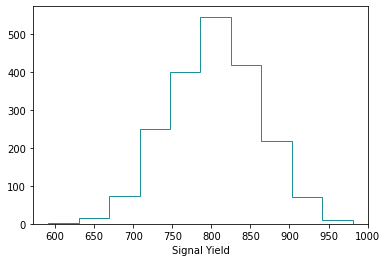

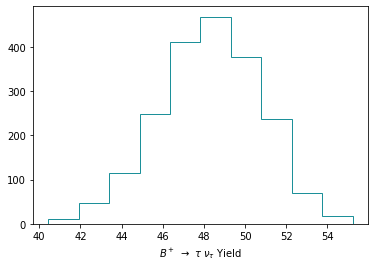

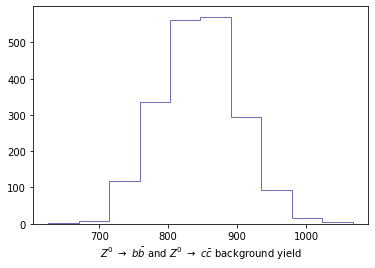

In [83]:
plt.figure()
plt.hist(bc_yield, histtype='step', color="#1c9099")
plt.xlabel('Signal Yield')
plt.plot()

plt.figure()
plt.hist(bu_yield, histtype='step', color="#1c9099")
plt.xlabel(r'$B^+$ $\rightarrow$ $\tau$ $\nu_\tau$ Yield')
plt.plot()

plt.figure()
plt.hist(bb_cc_yield, histtype='step', color="#756bb1")
plt.xlabel(r'$Z^0$ $\rightarrow$ $b\bar{b}$ and $Z^0$ $\rightarrow$ $c\bar{c}$ background yield')
plt.plot()
#counts_sig, bin_edges_sig = np.histogram(sig_yield)

In [ ]:
print(bu_yield)

In [ ]:
bkg_yield.max()

In [ ]:
len(sig_yield)

In [ ]:
np.sum(sig_yield == 0)

### Détermination de la moyenne pour les yields à l'aide d'une gaussienne

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 956.4                      │              Nfcn = 36               │
│ EDM = 2.26e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                  value    at limit
------------------  -------  ----------
mu_sig_[449863]         804       False
sigma_sig_[449863]    57.34       False


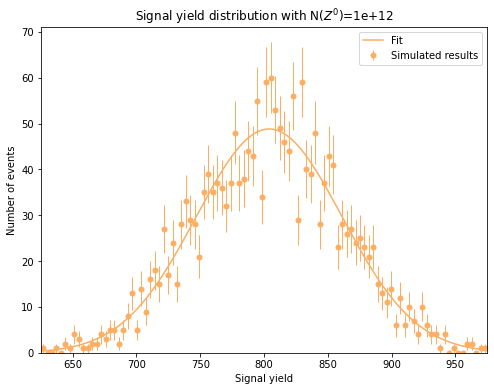

In [87]:
#Espace observable et data
min_sig = 625 #int(sig_yield.min())
max_sig = 975 #int(sig_yield.max()) + 1
obs = zfit.Space('x', limits=(min_sig,max_sig))
data = zfit.Data.from_numpy(obs=obs, array=bc_yield, weights=None)

#Définition des paramètres
rand_int = random.randint(0,1000000,size=1)
mu_sig_ = zfit.Parameter(f"mu_sig_{rand_int}", 800.)
sigma_sig_ = zfit.Parameter(f"sigma_sig_{rand_int}", 50.)

#Fits
gauss = zfit.pdf.Gauss(obs=obs, mu=mu_sig_, sigma=sigma_sig_)
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data )
minimizer = zfit.minimize.Minuit()
result_sig = minimizer.minimize(nll)

print(result_sig.info['original'])
print(result_sig.params)

#Plots

#Paramètre des histogrammes
nb_bins = 100
lower, upper = obs.limits
colour_bc = "#fdae61"

#Points du fit des yields de Bc+
x_plot_sig = np.linspace(lower[0][0], upper[0][0], num=1000)
y_plot_sig = zfit.run(gauss.pdf(x_plot_sig, norm_range=obs))

#Points de l'histogramme des yields fités de Bc+
counts_sig, bin_edges_sig = np.histogram(bc_yield, bins=nb_bins, range=(lower[0][0], upper[0][0]))

#Tracé du plot
plt.figure(figsize = [8,6])

mplhep.histplot((counts_sig, bin_edges_sig), 
                yerr = True, 
                color = colour_bc, 
                histtype='errorbar', 
                label="Simulated results")

plt.plot(x_plot_sig, 
         y_plot_sig * (len(bc_yield)/nb_bins*obs.area()), 
         color= colour_bc, 
         label= "Fit")

plt.xlabel("Signal yield")
plt.ylabel("Number of events")
plt.title("Signal yield distribution with N($Z^0$)={:.0e}".format(N_Z0))
plt.xlim(lower[0][0], upper[0][0])
plt.legend()

plt.show()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 70.75                      │              Nfcn = 72               │
│ EDM = 2.75e-07 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                 value    at limit
-----------------  -------  ----------
mu_bu_[224630]        48.3       False
sigma_bu_[224630]    2.444       False


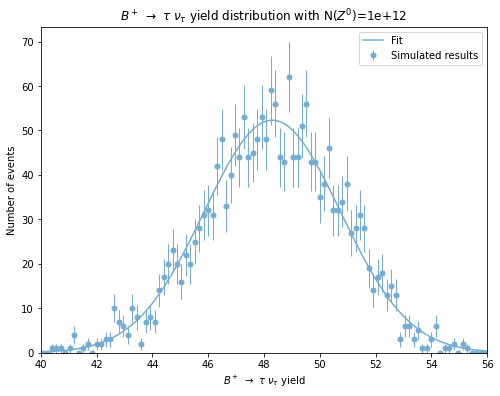

In [91]:
#Espace observable et data
min_bu = 40 #int(sig_yield.min())
max_bu = 56 #int(sig_yield.max())
obs_bu = zfit.Space('x', limits=(min_bu, max_bu))
data_bu = zfit.Data.from_numpy(obs=obs_bu, array=bu_yield, weights=None)

#Définition des paramètres
rand_int = random.randint(0,1000000,size=1)
mu_bu_ = zfit.Parameter(f"mu_bu_{rand_int}", 48.)
sigma_bu_ = zfit.Parameter(f"sigma_bu_{rand_int}", 50.)

#Fits
gauss = zfit.pdf.Gauss(obs=obs_bu, mu=mu_bu_, sigma=sigma_bu_)
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data_bu )
minimizer = zfit.minimize.Minuit()
result_bu = minimizer.minimize(nll)

print(result_bu.info['original'])
print(result_bu.params)

#Plots

#Paramètre des histogrammes
nb_bins = 100
lower, upper = obs_bu.limits
colour_bu = "#74add1"
label_bu = r'$B^+$ $\rightarrow$ $\tau$ $\nu_\tau$ yield'

#Points du fit des yields de B+
x_plot_bu = np.linspace(lower[0][0], upper[0][0], num=1000)
y_plot_bu = zfit.run(gauss.pdf(x_plot_bu, norm_range=obs_bu))

#Points de l'histogramme des yields de B+
counts_bu, bin_edges_bu = np.histogram(bu_yield, bins=nb_bins, range=(lower[0][0], upper[0][0]))

#Tracé du plot
plt.figure(figsize = [8,6])

mplhep.histplot((counts_bu, bin_edges_bu),
                yerr = True, 
                color = colour_bu, 
                histtype='errorbar', 
                label="Simulated results")

plt.plot(x_plot_bu, 
         y_plot_bu * (len(bu_yield)/nb_bins*obs_bu.area()), 
         color= colour_bu, 
         label= "Fit")

plt.xlabel(label_bu)
plt.ylabel("Number of events")
plt.title(r"$B^+$ $\rightarrow$ $\tau$ $\nu_\tau$ yield distribution with N($Z^0$)={:.0e}".format(N_Z0))
plt.xlim(lower[0][0], upper[0][0])

plt.legend()
plt.show()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 198.7                      │              Nfcn = 46               │
│ EDM = 3.52e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name                  value    at limit
------------------  -------  ----------
mu_bkg_[471446]       844.4       False
sigma_bkg_[816780]    55.41       False


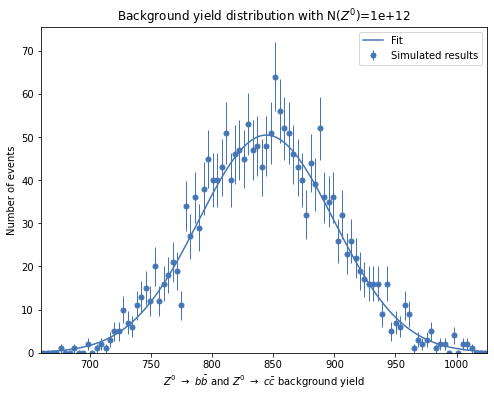

In [97]:
#Espace observable et data
min_bkg = 660 #int(bkg_yield.min())
max_bkg = 1025 #int(bkg_yield.max()) + 1
obs_bkg = zfit.Space('x', limits=(min_bkg,max_bkg))
data = zfit.Data.from_numpy(obs=obs_bkg, array=bb_cc_yield, weights=None)

#Définition des paramètres
rand_int = random.randint(0,1000000,size=1)
mu_bkg_ = zfit.Parameter(f"mu_bkg_{rand_int}", 800.)

rand_int = random.randint(0,1000000,size=1)
sigma_bkg_ = zfit.Parameter(f"sigma_bkg_{rand_int}", 50.)

#Fits
gauss = zfit.pdf.Gauss(obs=obs_bkg, mu=mu_bkg_, sigma=sigma_bkg_)
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data )
minimizer = zfit.minimize.Minuit()
result_bkg = minimizer.minimize(nll)

print(result_bkg.info['original'])
print(result_bkg.params)

#Plots

#Paramètre des histogrammes
nb_bins = 100
lower, upper = obs_bkg.limits
colour_bb_cc = "#4575b4"#"#abd9e9"
label_bb_cc = r'$Z^0$ $\rightarrow$ $b\bar{b}$ and $Z^0$ $\rightarrow$ $c\bar{c}$ background yield'

#Points du fit des yields de Z->bb et Z->cc
x_plot_bkg = np.linspace(lower[0][0], upper[0][0], num=1000)
y_plot_bkg = zfit.run(gauss.pdf(x_plot_bkg, norm_range=obs_bkg))

#Points de l'histogramme des yields de Z->bb et Z->cc
counts_bkg, bin_edges_bkg = np.histogram(bb_cc_yield, bins=nb_bins, range=(lower[0][0], upper[0][0]))

#Tracé du plot
plt.figure(figsize=[8,6])

mplhep.histplot((counts_bkg, bin_edges_bkg), 
                yerr = True, 
                color = colour_bb_cc, 
                histtype='errorbar', 
                label="Simulated results")

plt.plot(x_plot_bkg, 
         y_plot_bkg * (len(bb_cc_yield)/nb_bins*obs.area()), 
         color= colour_bb_cc, 
         label= "Fit")

plt.xlabel(label_bb_cc)
plt.ylabel("Number of events")
plt.title("Background yield distribution with N($Z^0$)={:.0e}".format(N_Z0))
plt.xlim(lower[0][0], upper[0][0])
plt.legend()
plt.show()
